# Benchmarks experiments notebook
This notebook is an accompanying notebook to the main script <code>experiments_scripts.py</code>. 
It can be used to tune the hyper-parameters ranges and for quick testing. To run this notebook and the script, first install <code>darts</code> and the [<code>ray</code> library](https://docs.ray.io/en/latest/ray-overview/installation.html). Install [<code>optuna</code> library](https://optuna.readthedocs.io/en/stable/installation.html) to use Optuna search algorithms.  

# read data, setup directories, transform 

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline 


from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler
from ray import tune

from datetime import datetime
import random
import os
from tqdm import tqdm
from darts.utils.utils import series2seq
from darts.dataprocessing.pipeline import Pipeline
from darts.metrics import mse, mae, smape, rmse, mape, mase
import torch
from pytorch_lightning.callbacks import Callback, EarlyStopping
from darts import TimeSeries
import numpy as np
import pickle
import json
import ray
from ray import tune, air
from ray.tune.search.optuna import OptunaSearch
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from darts.models.forecasting.torch_forecasting_model import (MixedCovariatesTorchModel, PastCovariatesTorchModel,
                                                              FutureCovariatesTorchModel)
from ray.tune.schedulers import ASHAScheduler
from ray.air import session
import matplotlib.pyplot as plt
import optuna
from csv import DictWriter
from darts.utils import missing_values

# data and models
from darts.datasets import ETTh1Dataset, ElectricityDataset
from darts.models import TCNModel, DLinearModel, NLinearModel, NHiTSModel
from builders import MODEL_BUILDERS


In [2]:
def generate_params_NHITS(trial):
    
    in_len = trial.suggest_int("in_len", 5* PERIOD_UNIT, 30*PERIOD_UNIT) 
    out_len = trial.suggest_int("out_len", 1, in_len - PERIOD_UNIT)
    num_stacks = trial.suggest_int("num_stacks", 2,5)
    num_blocks = trial.suggest_int("num_blocks", 1,3)
    num_layers = trial.suggest_int("num_layers", 2,5)
    activation = trial.suggest_categorical("activation", 
                                          ['ReLU','RReLU', 'PReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'Sigmoid'])
    MaxPool1d = trial.suggest_categorical("MaxPool1d", [False, True])
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])
    
    constants = {"layer_widths": 512, "pooling_kernel_sizes": None,
                "n_freq_downsample" : None, }

    return constants

def generate_params_NLINEAR(trial):
    
    in_len = trial.suggest_int("in_len", 5*PERIOD_UNIT, 30*PERIOD_UNIT) 
    out_len = trial.suggest_int("out_len", 1, in_len - PERIOD_UNIT)
    shared_weights = trial.suggest_categorical("shared_weights", [False, True])
    const_init = trial.suggest_categorical("const_init", [False, True])
    normalize = trial.suggest_categorical("normalize", [False, True])
    
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None

def generate_params_DLINEAR(trial):

    in_len = trial.suggest_int("in_len", 5*PERIOD_UNIT, 30*PERIOD_UNIT) 
    out_len = trial.suggest_int("out_len", 1, in_len - PERIOD_UNIT)
    kernel_size = trial.suggest_int("kernel_size", 5, 25)
    shared_weights = trial.suggest_categorical("shared_weights", [False, True])
    const_init = trial.suggest_categorical("const_init", [False, True])
    
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None


def generate_params_TCNMODEL(trial):
    
    in_len = trial.suggest_int("in_len", 5*PERIOD_UNIT, 30*PERIOD_UNIT) 
    out_len = trial.suggest_int("out_len", 1, in_len - PERIOD_UNIT)
    kernel_size = trial.suggest_int("kernel_size", 5, 25)
    num_filters = trial.suggest_int("num_filters", 5, 25)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    dilation_base = trial.suggest_int("dilation_base", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    add_encoders = trial.suggest_categorical("add_encoders", [False, True])

    return None


params_generators = {
    TCNModel.__name__: generate_params_TCNMODEL,
    DLinearModel.__name__:generate_params_DLINEAR,
    NLinearModel.__name__:generate_params_NLINEAR,
    NHiTSModel.__name__:generate_params_NHITS
}


## configure experiment

In [8]:
dataset = ETTh1Dataset
model_cl = DLinearModel#TCNModel #NHiTSModel#NLinearModel
random_seed = 42 

# data
PERIOD_UNIT = 24 
subset_size = int(365*1.5) * PERIOD_UNIT
split = 0.7
load_as_multivariate = False 
encoders_past = {"datetime_attribute": {"past": ["month", "week", "hour","dayofweek"]},
                "cyclic": {"past": ["month", "week", "hour", "dayofweek"]}} 
encoders_future = {"datetime_attribute": {"future": ["month", "week", "hour","dayofweek"]},
                    "cyclic": {"future": ["month", "week", "hour", "dayofweek"]}}

encoders = encoders_future if issubclass(model_cl, (MixedCovariatesTorchModel, FutureCovariatesTorchModel))\
            else encoders_past

# model training
fixed_params={
    "BATCH_SIZE" : 1024,
    "MAX_N_EPOCHS": 100,
    "NR_EPOCHS_VAL_PERIOD": 1,
    "MAX_SAMPLES_PER_TS": 1000, 
    "RANDOM_STATE": random_seed
}

train_with_metric = True # whether optimize models based on a metric or based on val_loss
eval_metric = smape
time_budget = 300 # in seconds


## setup logging directory

In [5]:
#Fix random states
#https://pytorch.org/docs/stable/notes/randomness.html
random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.use_deterministic_algorithms(True)

exp_start_time = datetime.now()
exp_name = f"{model_cl.__name__}_{exp_start_time.strftime('%Y-%m-%d')}_pid{os.getpid()}_seed{random_seed}"

# create directories 
experiment_root = os.path.join(os.getcwd(), f"benchmark_experiments/{dataset.__name__}")
experiment_dir = os.path.join(os.getcwd(), f"{experiment_root}/{exp_name}")
print(experiment_dir)
os.makedirs(experiment_dir, exist_ok=True)

/Users/elianemaalouf/PycharmProjects/darts_original/experiments/benchmark_experiments/ETTh1Dataset/DLinearModel_2023-01-28_pid87311_seed42


In [6]:
fields_names = ['experiment name','model', 'metric', 'metric on test-mean', 'metric on test-std', 'model training time', 'model inference time', 'seed', 'optimize with metric']

logging_file = f"{experiment_root}/logs.csv"

if not os.path.exists(logging_file):
    with open(logging_file, 'a') as f:
        writer = DictWriter(f, fieldnames=fields_names)
        writer.writeheader()
        f.close()
        
print(logging_file)

/Users/elianemaalouf/PycharmProjects/darts_original/experiments/benchmark_experiments/ETTh1Dataset/logs.csv


## read data and split

In [10]:

#read data 
if "multivariate" in dataset.__init__.__code__.co_varnames:
    data = dataset(multivariate=load_as_multivariate).load()
else:
    data = dataset().load()

data = series2seq(data)

data = [
    s[-subset_size:].astype(np.float32) for s in tqdm(data)
]


# split : train, validation , test (validation and test have same length)
all_splits = [list(s.split_after(split)) for s in data]
train_original = [split[0] for split in all_splits]
vals = [split[1] for split in all_splits]
vals = [list(s.split_after(0.5)) for s in vals]
val_original = [s[0] for s in vals]
test_original = [s[1] for s in vals]


train_len = len(train_original[0])
val_len = len(val_original[0])
test_len = len(test_original[0])
num_series = len(train_original)
n_components = train_original[0].n_components

print("number of series:", num_series)
print("number of components:", n_components)
print("training series length:", train_len)
print("validation series length:", val_len)
print("test series length:", test_len)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 180.93it/s]

number of series: 1
number of components: 7
training series length: 9189
validation series length: 1970
test series length: 1969


## Check missing values and transform data

In [11]:
# check if missing values and fill
for i in range(num_series):
    missing_ratio = missing_values.missing_values_ratio(train_original[i])
    print(f"missing values ratio in training series {i} = {missing_ratio}")
    print("filling training missing values by interpolation")
    if missing_ratio > 0.0:
        missing_values.fill_missing_values(train_original[i])
    
    missing_ratio = missing_values.missing_values_ratio(val_original[i])
    print(f"missing values ratio in validation series {i} = {missing_ratio}")
    print("filling validation missing values by interpolation")
    if missing_ratio > 0.0:
        missing_values.fill_missing_values(val_original[i])
    
    missing_ratio = missing_values.missing_values_ratio(test_original[i])
    print(f"missing values ratio in test series {i} = {missing_ratio}")
    print("filling test missing values by interpolation")
    if missing_ratio > 0.0:
        missing_values.fill_missing_values(test_original[i])
    

missing values ratio in training series 0 = 0.0
filling training missing values by interpolation
missing values ratio in validation series 0 = 0.0
filling validation missing values by interpolation
missing values ratio in test series 0 = 0.0
filling test missing values by interpolation


In [12]:
scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train_original)
val = scaler.transform(val_original)
test = scaler.transform(test_original)

## plot some data and checks

all components: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


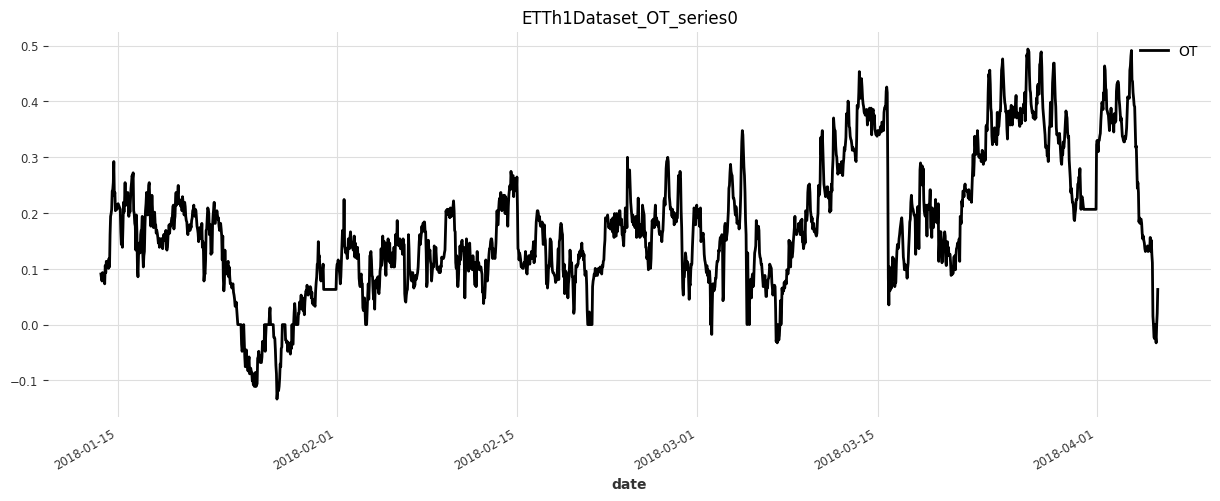

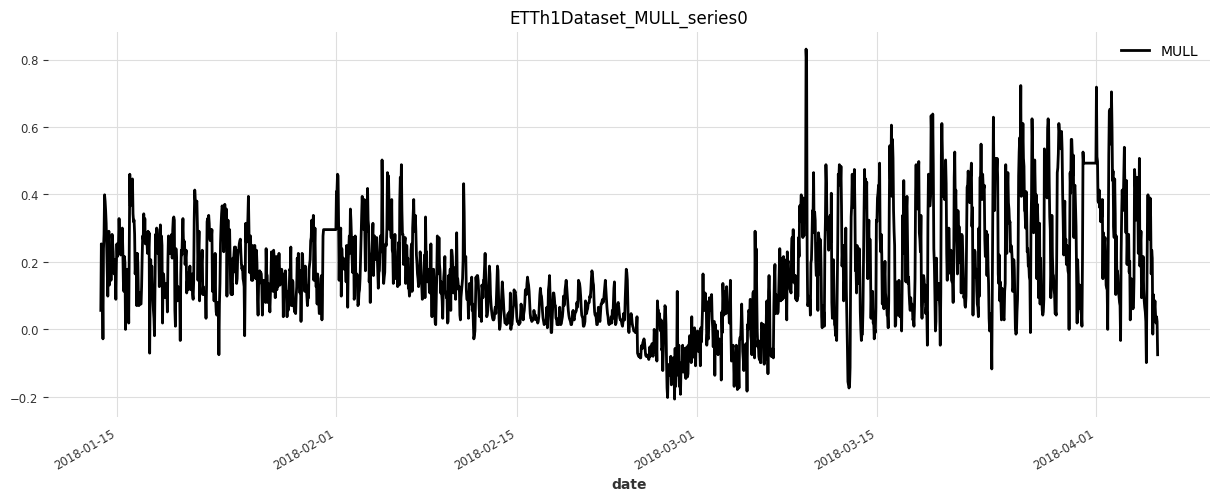

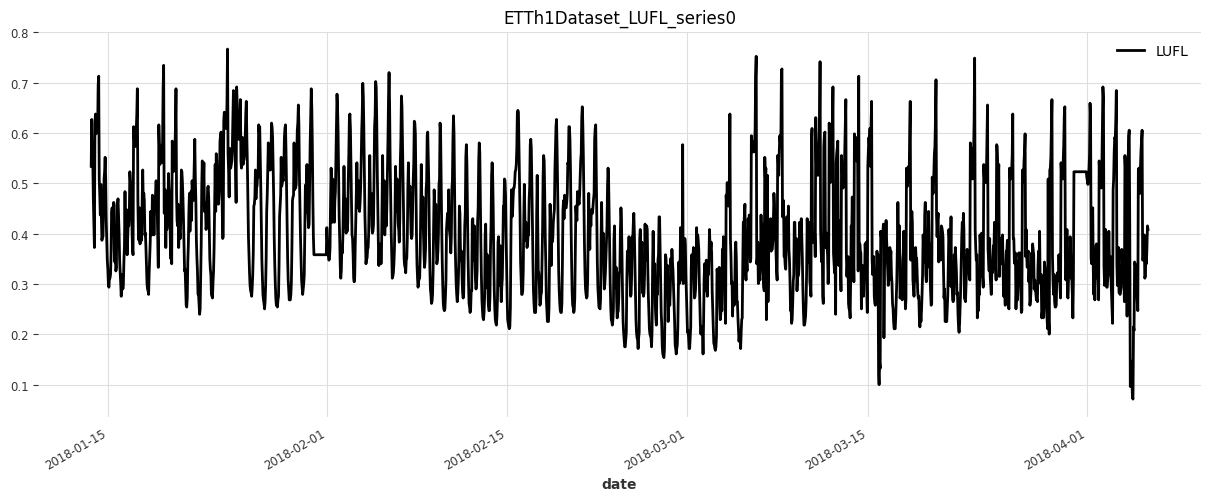

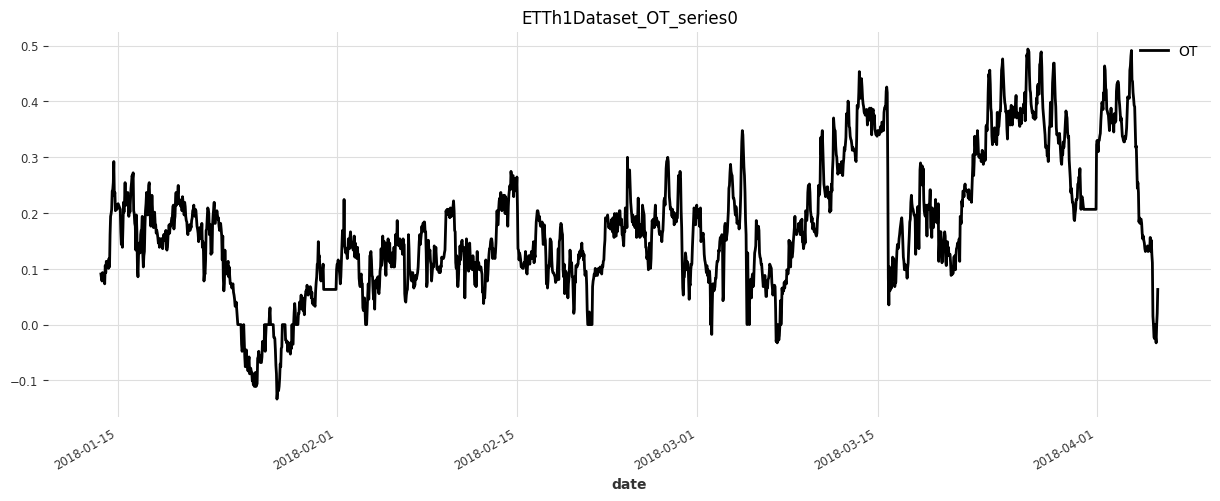

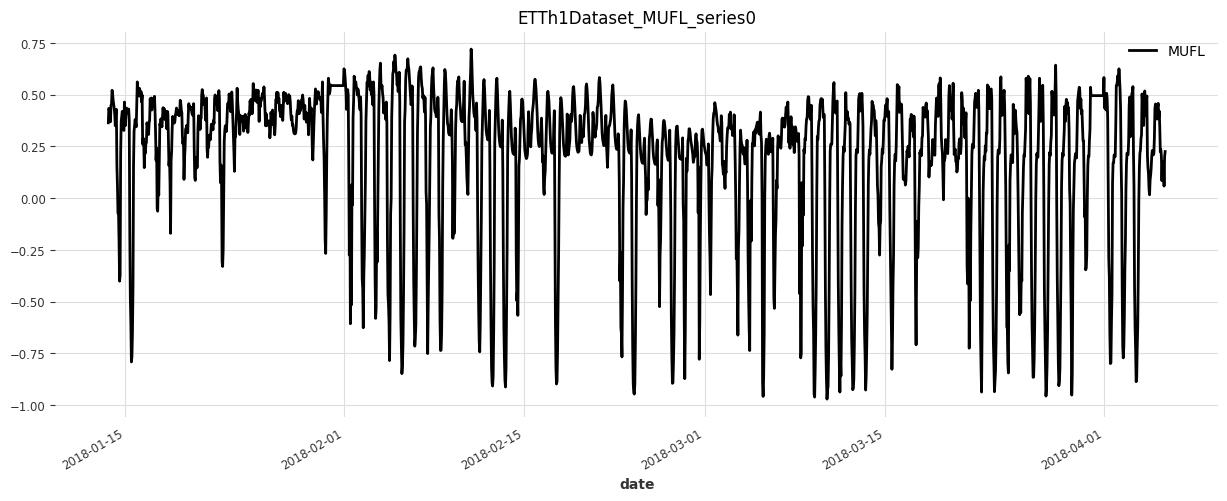

In [13]:
# pick series and components at random to plot 
max_series_to_plot = 5
max_comps_to_plot = 5


if n_components < max_comps_to_plot:
    max_comps_to_plot = n_components

comps_vec = np.random.randint(0, n_components, max_series_to_plot)
comp_names = train[0].columns.to_list()

if num_series < max_series_to_plot:
    max_series_to_plot = num_series

print("all components:", comp_names)
series_vec = np.random.randint(0, num_series, max_series_to_plot)

for idx in series_vec:
    for comp_id in comps_vec:
        comp_id = comp_names[comp_id]
        plt.figure(figsize=(15, 5))
        val[idx][comp_id].plot()
        plt.title(f"{dataset.__name__}_{comp_id}_series{idx}")
        plt.show()
        plt.close()


# setup optimiztation function and tuner

In [19]:
# objective function 

def objective_val_loss(config, model_cl, encoders, fixed_params, train=train, val=val):

    metrics = {"metric":"val_loss"}

    tuner_callbacks = [TuneReportCallback(metrics, on="validation_end")]

    model = MODEL_BUILDERS[model_cl.__name__](**config, fixed_params= fixed_params, encoders = encoders, 
                                              callbacks=tuner_callbacks)

    # train the model
    model.fit(
        series=train,
        val_series=val,
        max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"]
    )

def objective_metric(config, model_cl, metric, encoders, fixed_params, train=train, val=val):
    
    model = MODEL_BUILDERS[model_cl.__name__](**config, encoders = encoders, fixed_params=fixed_params)

    # train the model
    model.fit(
        series=train,
        val_series=val,
        max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"]
    )

    # use best model for subsequent evaluation
    model = model_cl.load_from_checkpoint(model_cl.__name__, work_dir = os.getcwd(), best = True)

    preds = model.predict(series=train, n=val_len)

    
    if metric.__name__ == "mase":
        metric_evals = metric(val, preds, train, n_jobs=-1, verbose=True)
    else:
        metric_evals = metric(val, preds, n_jobs=-1, verbose=True)

    metric_evals_reduced = np.mean(metric_evals) if metric_evals != np.nan else float("inf")

    session.report({"metric":metric_evals_reduced})
    

    
objective_metric_with_params = tune.with_parameters(objective_metric, model_cl=model_cl, metric = eval_metric, 
                                            encoders = encoders, fixed_params=fixed_params, train=train, val=val)

objective_val_loss_with_params = tune.with_parameters(objective_val_loss, model_cl=model_cl, 
                                            encoders = encoders, fixed_params=fixed_params, train=train, val=val)

search_alg = OptunaSearch(
    space = params_generators[model_cl.__name__],
    metric= "metric",
    mode= "min",
)

tuner =  tune.Tuner(
            trainable=objective_metric_with_params if train_with_metric else objective_val_loss_with_params,
            tune_config = tune.TuneConfig(
                search_alg = search_alg,
                num_samples = -1,
                time_budget_s = time_budget,
            ),
            run_config = air.RunConfig(
                                       local_dir = experiment_dir,
                                       name = f"{model_cl.__name__}_tuner_{eval_metric.__name__}")
        )

    

[I 2023-01-28 19:02:09,827] A new study created in memory with name: optuna


# run hyperparameters tuner

In [21]:
# run optimizer
tuner_results = tuner.fit()

(objective_metric pid=7110) GPU available: False, used: False
(objective_metric pid=7110) TPU available: False, using: 0 TPU cores
(objective_metric pid=7110) IPU available: False, using: 0 IPUs
(objective_metric pid=7110) HPU available: False, using: 0 HPUs
(objective_metric pid=7110) 
(objective_metric pid=7110)   | Name            | Type             | Params
(objective_metric pid=7110) -----------------------------------------------------
(objective_metric pid=7110) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7110) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7110) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7110) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7110) 4 | linear_seasonal | Linear           | 7.9 M 
(objective_metric pid=7110) 5 | linear_trend    | Linear           | 7.9 M 
(objective_metric pid=7110) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:02:21,650	ERROR trial_runner.py:1088 -- Trial objective_metric_4ec62234: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7110, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Trial name,date,experiment_id,hostname,node_ip,pid,timestamp,trial_id
objective_metric_00a66694,2023-01-28_19-02-25,481850df790342929fff030ab80b027a,eliane.maalouf,127.0.0.1,7142,1674928945,00a66694
objective_metric_014970a0,2023-01-28_19-04-43,75d2aa790939482a8b1646f3aea49d5c,eliane.maalouf,127.0.0.1,7653,1674929083,014970a0
objective_metric_06822bbf,2023-01-28_19-03-35,5888496112b04fb7b749c2628738679d,eliane.maalouf,127.0.0.1,7311,1674929015,06822bbf
objective_metric_077f9754,2023-01-28_19-06-52,1b844f4912ae4bee81bf0eab3a49b042,eliane.maalouf,127.0.0.1,8889,1674929212,077f9754
objective_metric_0b4bf953,2023-01-28_19-02-43,bd10f9104bfb43058415ce229d1cada0,eliane.maalouf,127.0.0.1,7240,1674928963,0b4bf953
objective_metric_0ec102ab,2023-01-28_19-05-35,1797ba05efdf45928d89037b373b200f,eliane.maalouf,127.0.0.1,8318,1674929135,0ec102ab
objective_metric_0f75a479,2023-01-28_19-02-45,2398f3d2b98c42cc80efc49e148e58b3,eliane.maalouf,127.0.0.1,7144,1674928965,0f75a479
objective_metric_101c81b7,2023-01-28_19-06-18,b375f1ab3e534486bcd8422eed0990df,eliane.maalouf,127.0.0.1,9188,1674929178,101c81b7
objective_metric_11214007,2023-01-28_19-04-51,9f01318059764560bc4c6234bde3d37c,eliane.maalouf,127.0.0.1,8384,1674929091,11214007
objective_metric_119d3c45,2023-01-28_19-03-21,5888496112b04fb7b749c2628738679d,eliane.maalouf,127.0.0.1,7311,1674929001,119d3c45


(objective_metric pid=7110) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7110)   warnings.warn('resource_tracker: There appear to be %d '


Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7143) GPU available: False, used: False
(objective_metric pid=7143) TPU available: False, using: 0 TPU cores
(objective_metric pid=7143) IPU available: False, using: 0 IPUs
(objective_metric pid=7143) HPU available: False, using: 0 HPUs
(objective_metric pid=7143) 
(objective_metric pid=7143)   | Name            | Type             | Params
(objective_metric pid=7143) -----------------------------------------------------
(objective_metric pid=7143) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7143) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7143) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7143) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7143) 4 | linear_seasonal | Linear           | 3.0 K 
(objective_metric pid=7143) 5 | linear_trend    | Linear           | 3.0 K 
(objective_metric pid=7143) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             


2023-01-28 19:02:27,167	ERROR trial_runner.py:1088 -- Trial objective_metric_71081be2: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7141, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

2023-01-28 19:02:27,177	ERROR trial_runner.py:1088 -- Trial objective_metric_00a66694: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7142, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

2023-01-28 19:02:27,227	ERROR trial_runner.py:1088 -- Trial objective_metric_738d20de: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7143, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

2023-01-28 19:02:27,371	ERROR trial_runner.py:1088 -- Trial objective_metric_79d41d58: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=7163, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, check

Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s, loss=89.4, train_loss=89.40]
Validation: 0it [00:00, ?it/s]44) 
(objective_metric pid=7144) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7144) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=89.4, train_loss=89.40, val_loss=6.960]        


(objective_metric pid=7144) Metric val_loss improved. New best score: 6.958


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.19it/s, loss=74.7, train_loss=60.00, val_loss=6.960]
Validation: 0it [00:00, ?it/s]44) 
(objective_metric pid=7144) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7144) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=74.7, train_loss=60.00, val_loss=5.040]        


(objective_metric pid=7144) Metric val_loss improved by 1.917 >= min_delta = 0.001. New best score: 5.041


Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.10it/s, loss=63, train_loss=39.60, val_loss=5.040]  
Validation: 0it [00:00, ?it/s]44) 
(objective_metric pid=7144) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7144) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=63, train_loss=39.60, val_loss=4.020]        


(objective_metric pid=7144) Metric val_loss improved by 1.018 >= min_delta = 0.001. New best score: 4.023


Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.16it/s, loss=53.9, train_loss=26.50, val_loss=4.020]
Validation: 0it [00:00, ?it/s]44) 
(objective_metric pid=7144) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7144) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=53.9, train_loss=26.50, val_loss=3.650]        


(objective_metric pid=7144) Metric val_loss improved by 0.373 >= min_delta = 0.001. New best score: 3.650
(objective_metric pid=7236) ValueError: Covariates have been provided, but the model has been built with shared_weights=True.Please set shared_weights=False to use covariates.
(objective_metric pid=7238) GPU available: False, used: False
(objective_metric pid=7238) TPU available: False, using: 0 TPU cores
(objective_metric pid=7238) IPU available: False, using: 0 IPUs
(objective_metric pid=7238) HPU available: False, using: 0 HPUs
(objective_metric pid=7238) 
(objective_metric pid=7238)   | Name            | Type             | Params
(objective_metric pid=7238) -----------------------------------------------------
(objective_metric pid=7238) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7238) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7238) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7238) 3 | decompositio

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7240) GPU available: False, used: False
(objective_metric pid=7240) TPU available: False, using: 0 TPU cores
(objective_metric pid=7240) IPU available: False, using: 0 IPUs
(objective_metric pid=7240) HPU available: False, using: 0 HPUs
(objective_metric pid=7240) 
(objective_metric pid=7240)   | Name            | Type             | Params
(objective_metric pid=7240) -----------------------------------------------------
(objective_metric pid=7240) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7240) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7240) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7240) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7240) 4 | linear_seasonal | Linear           | 1.8 M 
(objective_metric pid=7240) 5 | linear_trend    | Linear           | 1.8 M 
(objective_metric pid=7240) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:02:33,239	ERROR trial_runner.py:1088 -- Trial objective_metric_8fb4e5da: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7238, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7238) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7238)   warnings.warn('resource_tracker: There appear to be %d '


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:02:33,513	ERROR trial_runner.py:1088 -- Trial objective_metric_4ec8bd9d: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7242, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=0.0503, train_loss=0.0503]
Validation: 0it [00:00, ?it/s]39) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.18it/s, loss=46.9, train_loss=18.90, val_loss=3.650]
Validation: 0it [00:00, ?it/s]44) 
(objective_metric pid=7239) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0503, train_loss=0.0503, val_loss=0.0628]        


(objective_metric pid=7239) Metric val_loss improved. New best score: 0.063
(objective_metric pid=7242) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7242)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=7144) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=0.0481, train_loss=0.046, val_loss=0.0628] 
Validation: 0it [00:00, ?it/s]39) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.83it/s, loss=83.9, train_loss=83.90]
Validation: 0it [00:00, ?it/s]40) 
(objective_metric pid=7239) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0481, train_loss=0.046, val_loss=0.0607]        
(objective_metric pid=7144) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=46.9, train_loss=18.90, val_loss=3.670]        
(objective_metric pid=7240) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7239) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.061
(objective_metric pid=7240) Metric val_loss improved. New best score: 6.837
(objective_metric pid=7239) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.059


(objective_metric pid=7240) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=0.0463, train_loss=0.0427, val_loss=0.0607]
Validation: 0it [00:00, ?it/s]39) 
(objective_metric pid=7239) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=83.9, train_loss=83.90, val_loss=6.840]        
(objective_metric pid=7239) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=0.0448, train_loss=0.0404, val_loss=0.0592]
Validation: 0it [00:00, ?it/s]39) 
(objective_metric pid=7239) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=41.6, train_loss=15.00, val_loss=3.670]
Validation: 0it [00:00, ?it/s]44) 
(objective_metric pid=7239) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.73it/s, loss=58.1, train_loss=32.30, val_loss=6.840]
Validation: 0it [00:00, ?it/s]40) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0448, train_loss=0.0404, val_loss=0.0582]        
(objective_metric pid=7144) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_

(objective_metric pid=7240) Metric val_loss improved by 4.943 >= min_delta = 0.001. New best score: 1.894
(objective_metric pid=7239) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.058


(objective_metric pid=7144) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=0.0427, train_loss=0.0378, val_loss=0.0577]
Validation: 0it [00:00, ?it/s]39) 
(objective_metric pid=7239) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=41, train_loss=6.720, val_loss=1.890]  
Validation: 0it [00:00, ?it/s]40) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0427, train_loss=0.0378, val_loss=0.0575]        
(objective_metric pid=7240) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=0.0419, train_loss=0.0372, val_loss=0.0575]
Validation: 0it [00:00, ?it/s]39) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.22it/s, loss=37.5, train_loss=13.40, val_loss=3.890]
Validation: 0it [00:00, ?it/s]44) 
(objective_metric pid=7239) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7240) 
Epoch 2: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s, loss=41, train_loss=6.720, val_loss=0.282]
(objective_metric pid=7239) 
Epoch 6: 100%

(objective_metric pid=7240) Metric val_loss improved by 1.612 >= min_delta = 0.001. New best score: 0.282


(objective_metric pid=7144) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  3.49it/s, loss=0.0412, train_loss=0.0367, val_loss=0.0573]
Validation: 0it [00:00, ?it/s]39) 
(objective_metric pid=7239) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7144) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=37.5, train_loss=13.40, val_loss=4.180]
(objective_metric pid=7239) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=31.6, train_loss=3.450, val_loss=0.282]
Validation: 0it [00:00, ?it/s]40) 


(objective_metric pid=7144) Monitored metric val_loss did not improve in the last 3 records. Best score: 3.650. Signaling Trainer to stop.
(objective_metric pid=7239) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.058. Signaling Trainer to stop.
(objective_metric pid=7239) GPU available: False, used: False
(objective_metric pid=7239) TPU available: False, using: 0 TPU cores
(objective_metric pid=7239) IPU available: False, using: 0 IPUs
(objective_metric pid=7239) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 51.89it/s]
(objective_metric pid=7144) GPU available: False, used: False
(objective_metric pid=7144) TPU available: False, using: 0 TPU cores
(objective_metric pid=7144) IPU available: False, using: 0 IPUs
(objective_metric pid=7144) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 29.10it/s]


(objective_metric pid=7240) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7240) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.66it/s, loss=27.9, train_loss=13.00, val_loss=0.727]
Validation: 0it [00:00, ?it/s]40) 
(objective_metric pid=7240) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7240) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s, loss=27, train_loss=22.80, val_loss=1.530]  
Validation: 0it [00:00, ?it/s]40) 
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=7308) GPU available: False, used: False
(objective_metric pid=7308) TPU available: False, using: 0 TPU cores
(objective_metric pid=7308) IPU available: False, using: 0 IPUs
(objective_metric pid=7308) HPU available: False, using: 0 HPUs
(objective_metric pid=7308) 
(objective_metric pid=7308)   | Name            | Type             | Params
(objective_metric pid=7308) -----------------------------------------------------
(objective_metric pid=7308) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7308) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7308) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7308) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7308) 4 | linear_seasonal | Linear           | 9.4 M 
(objective_metric pid=7308) 5 | linear_trend    | Linear           | 9.4 M 
(objective_metric pid=7308) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

(objective_metric pid=7240) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=7240) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7240) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.282. Signaling Trainer to stop.
(objective_metric pid=7240) GPU available: False, used: False
(objective_metric pid=7240) TPU available: False, using: 0 TPU cores
(objective_metric pid=7240) IPU available: False, using: 0 IPUs
(objective_metric pid=7240) HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s] 
(objective_metric pid=7301) GPU available: False, used: False
(objective_metric pid=7301) TPU available: False, using: 0 TPU cores
(objective_metric pid=7301) IPU available: False, using: 0 IPUs
(objective_metric pid=7301) HPU available: False, using: 0 HPUs
(objective_metric pid=7301) 
(objective_metric pid=7301)   | Name            | Type             | Params
(objective_metric pid=7301) -----------------------------------------------------
(objective_metric pid=7301) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7301) 1 | train_met

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=7311) GPU available: False, used: False
(objective_metric pid=7311) TPU available: False, using: 0 TPU cores
(objective_metric pid=7311) IPU available: False, using: 0 IPUs
(objective_metric pid=7311) HPU available: False, using: 0 HPUs
(objective_metric pid=7311) 
(objective_metric pid=7311)   | Name            | Type             | Params
(objective_metric pid=7311) -----------------------------------------------------
(objective_metric pid=7311) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7311) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7311) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7311) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7311) 4 | linear_seasonal | Linear           | 10.8 K
(objective_metric pid=7311) 5 | linear_trend    | Linear           | 10.8 K
(objective_metric pid=7311) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7308) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7308)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=7310) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7310)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-28 19:02:40,848	ERROR trial_runner.py:1088 -- Trial objective_metric_4a3172ea: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7305, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:02:40,859	ERROR trial_runner.py:1088 -- Trial objective_metric_729c2986: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7301, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 


(objective_metric pid=7305) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7305)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=7301) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7301)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=0.2, train_loss=0.200]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7239) ValueError: Covariates have been provided, but the model has been built with shared_weights=True.Please set shared_weights=False to use covariates.
2023-01-28 19:02:41,182	ERROR trial_runner.py:1088 -- Trial objective_metric_5319d635: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=7239, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  Fi

(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved. New best score: 0.182


(objective_metric pid=7311) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  2.76it/s, loss=0.199, train_loss=0.198, val_loss=0.182]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.199, train_loss=0.198, val_loss=0.181]        


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.181


Sanity Checking: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  2.56it/s, loss=0.198, train_loss=0.196, val_loss=0.181]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7144) GPU available: False, used: False
(objective_metric pid=7144) TPU available: False, using: 0 TPU cores
(objective_metric pid=7144) IPU available: False, using: 0 IPUs
(objective_metric pid=7144) HPU available: False, using: 0 HPUs
(objective_metric pid=7144) 
(objective_metric pid=7144)   | Name            | Type             | Params
(objective_metric pid=7144) -----------------------------------------------------
(objective_metric pid=7144) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7144) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7144) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7144) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7144) 4 | linear_seasonal | Linear           | 1.4 M 
(objective_metric pid=7144) 5 | linear_trend    | Linear           | 1.4 M 
(objective_metric pid=7144) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

(objective_metric pid=7311) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=0.197, train_loss=0.194, val_loss=0.179]
Validation: 0it [00:00, ?it/s]11) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.197, train_loss=0.194, val_loss=0.178]        


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.178


Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=0.196, train_loss=0.192, val_loss=0.178]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.196, train_loss=0.192, val_loss=0.176]


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.176


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=84.7, train_loss=84.70]
Validation: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=0.195, train_loss=0.190, val_loss=0.176]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7240) GPU available: False, used: False
(objective_metric pid=7240) TPU available: False, using: 0 TPU cores
(objective_metric pid=7240) IPU available: False, using: 0 IPUs
(objective_metric pid=7240) HPU available: False, using: 0 HPUs
(objective_metric pid=7240) 
(objective_metric pid=7240)   | Name            | Type             | Params
(objective_metric pid=7240) -----------------------------------------------------
(objective_metric pid=7240) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7240) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7240) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7240) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7240) 4 | linear_seasonal | Linear           | 202 K 
(objective_metric pid=7240) 5 | linear_trend    | Linear           | 202 K 
(objective_metric pid=7240) -----------------------------------------------------
(objective_metri

(objective_metric pid=7144) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s, loss=0.195, train_loss=0.190, val_loss=0.174]
                                                                      
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.195, train_loss=0.190, val_loss=0.174]


(objective_metric pid=7144) Monitored metric val_loss did not improve in the last 4 records. Best score: 3.650. Signaling Trainer to stop.
(objective_metric pid=7144) GPU available: False, used: False
(objective_metric pid=7144) TPU available: False, using: 0 TPU cores
(objective_metric pid=7144) IPU available: False, using: 0 IPUs
(objective_metric pid=7144) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 2551.28it/s]
(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.173


(objective_metric pid=7144) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=0.194, train_loss=0.188, val_loss=0.174]
Validation: 0it [00:00, ?it/s]11) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.64it/s]
(objective_metric pid=7311) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=0.193, train_loss=0.186, val_loss=0.173]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.193, train_loss=0.186, val_loss=0.171]        


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.171


Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=0.192, train_loss=0.184, val_loss=0.171]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.192, train_loss=0.184, val_loss=0.170]


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.170


Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=0.191, train_loss=0.182, val_loss=0.170]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.168


(objective_metric pid=7311) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=0.19, train_loss=0.180, val_loss=0.168] 
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.19, train_loss=0.180, val_loss=0.167]        


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.167


Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=0.189, train_loss=0.178, val_loss=0.167]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.189, train_loss=0.178, val_loss=0.165]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.165


Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=0.188, train_loss=0.176, val_loss=0.165]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.164
(objective_metric pid=7390) GPU available: False, used: False
(objective_metric pid=7390) TPU available: False, using: 0 TPU cores
(objective_metric pid=7390) IPU available: False, using: 0 IPUs
(objective_metric pid=7390) HPU available: False, using: 0 HPUs
(objective_metric pid=7390) 
(objective_metric pid=7390)   | Name            | Type             | Params
(objective_metric pid=7390) -----------------------------------------------------
(objective_metric pid=7390) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7390) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7390) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7390) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7390) 4 | linear_seasonal | Linear           | 126 K 
(objective_metric pid=7390) 5 | linear_trend    | Linear           |

(objective_metric pid=7311) 
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=0.187, train_loss=0.174, val_loss=0.164]
Validation: 0it [00:00, ?it/s]11) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=7311) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
(objective_metric pid=7391) 
(objective_metric pid=7391)   | Name            | Type             | Params
(objective_metric pid=7391) -----------------------------------------------------
(objective_metric pid=7391) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7391) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7391) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7391) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7391) 4 | linear_seasonal | Linear           | 2.4 M 
(objective_metric pid=7391) 5 | linear_trend    | Linear           | 2.4 M 
(objective_metric pid=7391) -----------------------------------------------------
(objective_metric pid=7391) 4.7 M     Trainable params
(objective_metric pid=7

Sanity Checking: 0it [00:00, ?it/s]
Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=0.186, train_loss=0.172, val_loss=0.162]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=0.192, train_loss=0.192]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7393) GPU available: False, used: False
(objective_metric pid=7393) TPU available: False, using: 0 TPU cores
(objective_metric pid=7393) IPU available: False, using: 0 IPUs
(objective_metric pid=7393) HPU available: False, using: 0 HPUs
(objective_metric pid=7393) 
(objective_metric pid=7393)   | Name            | Type             | Params
(objective_metric pid=7393) -----------------------------------------------------
(objective_metric pid=7393) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7393) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7393) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7393) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7393) 4 | linear_seasonal | Linear           | 1.8 M 
(objective_metric pid=7393) 5 | linear_trend    | Linear           | 1.8 M 
(objective_metric pid=7393) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

(objective_metric pid=7311) 
Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.186, train_loss=0.172, val_loss=0.161]        
(objective_metric pid=7389) 
Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=0.185, train_loss=0.171, val_loss=0.161]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=0.188, train_loss=0.185, val_loss=0.175]
Validation: 0it [00:00, ?it/s]89) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=7311) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.185, train_loss=0.171, val_loss=0.159]        
(objective_metric pid=7389) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.188, train_loss=0.185, val_loss=0.170]        


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.159
(objective_metric pid=7389) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.170


Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=0.184, train_loss=0.169, val_loss=0.159]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0464, train_loss=0.0464]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=0.185, train_loss=0.178, val_loss=0.170]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.158
(objective_metric pid=7389) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.165


(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=0.183, train_loss=0.167, val_loss=0.158]
Validation: 0it [00:00, ?it/s]
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.66it/s, loss=84.2, train_loss=84.20]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.157
(objective_metric pid=7391) Metric val_loss improved. New best score: 0.060
(objective_metric pid=7389) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.161


(objective_metric pid=7311) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=0.182, train_loss=0.172, val_loss=0.165]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7393) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s, loss=0.0464, train_loss=0.0464, val_loss=0.0602]
(objective_metric pid=7389) 
Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=0.182, train_loss=0.165, val_loss=0.157]
Validation: 0it [00:00, ?it/s]11) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0464, train_loss=0.0464, val_loss=0.0602]        
(objective_metric pid=7393) 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s, loss=84.2, train_loss=84.20, val_loss=9.330]
(objective_metric pid=7311) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=0.179, train_loss=0.166, val_loss=0.161]
Validation: 0it [00:00, ?it/s]89) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s,

(objective_metric pid=7393) Metric val_loss improved. New best score: 9.330
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.155
(objective_metric pid=7389) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.156


(objective_metric pid=7389) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=0.181, train_loss=0.164, val_loss=0.155]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.154
(objective_metric pid=7389) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.152


(objective_metric pid=7311) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=0.175, train_loss=0.160, val_loss=0.156]
Validation: 0it [00:00, ?it/s]89) 
Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=0.179, train_loss=0.162, val_loss=0.154]
Validation: 0it [00:00, ?it/s]11) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0433, train_loss=0.0402, val_loss=0.0602]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7389) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=65.5, train_loss=46.90, val_loss=9.330]
Validation: 0it [00:00, ?it/s]93) 
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=0.172, train_loss=0.154, val_loss=0.152]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7393) 
Validation DataLo

(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.152
(objective_metric pid=7389) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.147
(objective_metric pid=7393) Metric val_loss improved by 4.521 >= min_delta = 0.001. New best score: 4.810


Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=0.177, train_loss=0.160, val_loss=0.152]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7389) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.172, train_loss=0.154, val_loss=0.147]
(objective_metric pid=7393) 
Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s, loss=65.5, train_loss=46.90, val_loss=4.810]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s, loss=0.0433, train_loss=0.0402, val_loss=0.0574]


(objective_metric pid=7391) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.057
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.151


(objective_metric pid=7311) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=0.169, train_loss=0.148, val_loss=0.147]
Validation: 0it [00:00, ?it/s]
Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=0.176, train_loss=0.158, val_loss=0.151]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7389) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.169, train_loss=0.148, val_loss=0.143]


(objective_metric pid=7389) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.143
2023-01-28 19:02:49,765	ERROR trial_runner.py:1088 -- Trial objective_metric_42320c2b: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7392, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks

(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.150
(objective_metric pid=7392) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7392)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=7422) GPU available: False, used: False
(objective_metric pid=7422) TPU available: False, using: 0 TPU cores
(objective_metric pid=7422) IPU available: False, using: 0 IPUs
(objective_metric pid=7422) HPU available: False, using: 0 HPUs
(objective_metric pid=7422) 
(objective_metric pid=7422)   | Name            | Type             | Params
(objective_metric pid=7422) -----------------------------------------------------
(objective_metric pid=7422) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7422) 1 | trai

(objective_metric pid=7311) 
Epoch 23:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.176, train_loss=0.158, val_loss=0.150]
Sanity Checking: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=0.167, train_loss=0.143, val_loss=0.143]
Validation: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7144) GPU available: False, used: False
(objective_metric pid=7144) TPU available: False, using: 0 TPU cores
(objective_metric pid=7144) IPU available: False, using: 0 IPUs
(objective_metric pid=7144) HPU available: False, using: 0 HPUs
(objective_metric pid=7144) 
(objective_metric pid=7144)   | Name            | Type             | Params
(objective_metric pid=7144) -----------------------------------------------------
(objective_metric pid=7144) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7144) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7144) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7144) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7144) 4 | linear_seasonal | Linear           | 2.1 M 
(objective_metric pid=7144) 5 | linear_trend    | Linear           | 2.1 M 
(objective_metric pid=7144) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=0.174, train_loss=0.157, val_loss=0.150]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.66it/s, loss=50.8, train_loss=21.20, val_loss=4.810]
Validation: 0it [00:00, ?it/s]93) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.51it/s, loss=0.0409, train_loss=0.0362, val_loss=0.0574]
Validation: 0it [00:00, ?it/s]91) 


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.148
(objective_metric pid=7422) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7422)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-28 19:02:50,334	ERROR trial_runner.py:1088 -- Trial objective_metric_6f2dfff5: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7144, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function

(objective_metric pid=7391) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=0.164, train_loss=0.138, val_loss=0.139]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7393) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7389) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.135


Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=0.172, train_loss=0.155, val_loss=0.148]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.164, train_loss=0.138, val_loss=0.135]       
(objective_metric pid=7311) 
Epoch 25:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.172, train_loss=0.155, val_loss=0.147]        
(objective_metric pid=7393) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=50.8, train_loss=21.20, val_loss=1.940]        


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.147
(objective_metric pid=7393) Metric val_loss improved by 2.869 >= min_delta = 0.001. New best score: 1.941
(objective_metric pid=7391) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.056


(objective_metric pid=7391) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=0.161, train_loss=0.133, val_loss=0.135]
Validation: 0it [00:00, ?it/s]89) 
Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=0.17, train_loss=0.153, val_loss=0.147] 
Validation: 0it [00:00, ?it/s]11) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0409, train_loss=0.0362, val_loss=0.0558]        
(objective_metric pid=7389) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.161, train_loss=0.133, val_loss=0.132]        


(objective_metric pid=7389) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.132


(objective_metric pid=7311) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=0.158, train_loss=0.128, val_loss=0.132]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.146


Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=0.168, train_loss=0.152, val_loss=0.146]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.80it/s, loss=39.8, train_loss=6.910, val_loss=1.940]
Validation: 0it [00:00, ?it/s]93) 
(objective_metric pid=7311) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=0.155, train_loss=0.124, val_loss=0.128]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7393) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7389) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.128
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.145


Epoch 27:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=0.167, train_loss=0.150, val_loss=0.145]
Validation: 0it [00:00, ?it/s]11) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0392, train_loss=0.0339, val_loss=0.0558]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.155, train_loss=0.124, val_loss=0.125]        
(objective_metric pid=7393) 
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s, loss=39.8, train_loss=6.910, val_loss=0.546]
(objective_metric pid=7311) 
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=0.153, train_loss=0.119, val_loss=0.125]
Validation: 0it [00:00, ?it/s]89) 
Epoch 4:   0%|        

(objective_metric pid=7389) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.125
(objective_metric pid=7393) Metric val_loss improved by 1.395 >= min_delta = 0.001. New best score: 0.546
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.143


Epoch 28:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=0.165, train_loss=0.149, val_loss=0.143]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7391) 
Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s, loss=0.0392, train_loss=0.0339, val_loss=0.0551]
(objective_metric pid=7389) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.153, train_loss=0.119, val_loss=0.121]        
(objective_metric pid=7311) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0392, train_loss=0.0339, val_loss=0.0551]        


(objective_metric pid=7389) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.121
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.142


Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=0.15, train_loss=0.115, val_loss=0.121] 
Validation: 0it [00:00, ?it/s]89) 
Epoch 29:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=0.163, train_loss=0.147, val_loss=0.142]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.15, train_loss=0.115, val_loss=0.118]        
(objective_metric pid=7311) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.83it/s, loss=32.3, train_loss=2.490, val_loss=0.546]
Validation: 0it [00:00, ?it/s]93) 


(objective_metric pid=7389) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.118
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.141


Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=0.148, train_loss=0.111, val_loss=0.118]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7393) 
Epoch 30:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=0.161, train_loss=0.146, val_loss=0.141]
Validation: 0it [00:00, ?it/s]11) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.63it/s, loss=0.0379, train_loss=0.0328, val_loss=0.0551]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7389) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.148, train_loss=0.111, val_loss=0.115]        
(objective_metric pid=7311) 
Epoch 31:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.161, train_loss=0.146, val_loss=0.140]        
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7393) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=32.3, train_loss=2.490, val_loss=0.262]        


(objective_metric pid=7389) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.115
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.140
(objective_metric pid=7393) Metric val_loss improved by 0.284 >= min_delta = 0.001. New best score: 0.262


Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=0.146, train_loss=0.107, val_loss=0.115]
Validation: 0it [00:00, ?it/s]89) 
Epoch 31:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=0.16, train_loss=0.144, val_loss=0.140] 
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.146, train_loss=0.107, val_loss=0.112]        
(objective_metric pid=7311) 
Epoch 32:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.16, train_loss=0.144, val_loss=0.138]        
(objective_metric pid=7391) 
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s, loss=0.0379, train_loss=0.0328, val_loss=0.0547]


(objective_metric pid=7389) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.112
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.138
(objective_metric pid=7391) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055


Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=0.143, train_loss=0.104, val_loss=0.112]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7389) 
Epoch 32:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=0.158, train_loss=0.143, val_loss=0.138]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.80it/s, loss=27.8, train_loss=5.210, val_loss=0.262]
Validation: 0it [00:00, ?it/s]93) 
(objective_metric pid=7311) 
Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=0.141, train_loss=0.100, val_loss=0.109]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7393) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7389) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.109
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.137


Epoch 33:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=0.156, train_loss=0.141, val_loss=0.137]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.141, train_loss=0.100, val_loss=0.107]        
(objective_metric pid=7393) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=27.8, train_loss=5.210, val_loss=0.572]        
(objective_metric pid=7311) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0369, train_loss=0.0321, val_loss=0.0547]
Validation: 0it [00:00, ?it/s]91) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=0.139, train_loss=0.0967, val_loss=0.107]
Validation: 0it [00:00, ?it/s]89) 


(objective_metric pid=7389) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.107
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.136


Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=0.155, train_loss=0.140, val_loss=0.136]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 35:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.155, train_loss=0.140, val_loss=0.135]        
(objective_metric pid=7389) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.139, train_loss=0.0967, val_loss=0.104]        


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.135
(objective_metric pid=7389) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.104


(objective_metric pid=7391) 
Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=0.134, train_loss=0.0935, val_loss=0.104]
Validation: 0it [00:00, ?it/s]89) 
Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=0.153, train_loss=0.138, val_loss=0.135]
Validation: 0it [00:00, ?it/s]11) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0369, train_loss=0.0321, val_loss=0.0544]        
(objective_metric pid=7389) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s, loss=25.4, train_loss=11.20, val_loss=0.572]
Validation: 0it [00:00, ?it/s]93) 
Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.134, train_loss=0.0935, val_loss=0.102]        


(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.102


(objective_metric pid=7311) 
Epoch 36:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.153, train_loss=0.138, val_loss=0.134]
(objective_metric pid=7393) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.134
(objective_metric pid=7481) GPU available: False, used: False
(objective_metric pid=7481) TPU available: False, using: 0 TPU cores
(objective_metric pid=7481) IPU available: False, using: 0 IPUs
(objective_metric pid=7481) HPU available: False, using: 0 HPUs
(objective_metric pid=7481) 
(objective_metric pid=7481)   | Name            | Type             | Params
(objective_metric pid=7481) -----------------------------------------------------
(objective_metric pid=7481) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7481) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7481) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7481) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7481) 4 | linear_seasonal | Linear           | 16.4 K
(objective_metric pid=7481) 5 | linear_trend    | Linear           |

Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=0.129, train_loss=0.0904, val_loss=0.102]
Validation: 0it [00:00, ?it/s]89) 
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=0.151, train_loss=0.137, val_loss=0.134]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7393) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=25.4, train_loss=11.20, val_loss=0.975]        


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.133
2023-01-28 19:02:54,612	ERROR trial_runner.py:1088 -- Trial objective_metric_cacad0ef: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7481, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks

(objective_metric pid=7311) 
Epoch 37:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.151, train_loss=0.137, val_loss=0.133]
(objective_metric pid=7389) 
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.129, train_loss=0.0904, val_loss=0.0994]


(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.099
(objective_metric pid=7481) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7481)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=0.15, train_loss=0.135, val_loss=0.133] 
Validation: 0it [00:00, ?it/s]11) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0362, train_loss=0.0316, val_loss=0.0544]
Validation: 0it [00:00, ?it/s]91) 
Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=0.125, train_loss=0.0875, val_loss=0.0994]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7311) 
Epoch 38:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.15, train_loss=0.135, val_loss=0.132]        
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 23:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.125, train_loss=0.0875, val_loss=0.0972]        


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.132
(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.097


Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=0.148, train_loss=0.134, val_loss=0.132]
Validation: 0it [00:00, ?it/s]
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=0.12, train_loss=0.0847, val_loss=0.0972] 
Validation: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.64it/s, loss=24.3, train_loss=16.70, val_loss=0.975]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s, loss=0.0362, train_loss=0.0316, val_loss=0.0541]
(objective_metric pid=7311) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0362, train_loss=0.0316, val_loss=0.0541]
(objective_metric pid=7389) 
Epoch 24:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.12, train_loss=0.0847, val_loss=0.095]
(objective_metric pid=7393) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.130
(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.095


Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=0.147, train_loss=0.133, val_loss=0.130]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=0.116, train_loss=0.0821, val_loss=0.095]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7393) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s, loss=24.3, train_loss=16.70, val_loss=1.160]
(objective_metric pid=7311) 
Epoch 40:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.147, train_loss=0.133, val_loss=0.129]


(objective_metric pid=7393) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.262. Signaling Trainer to stop.
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.129
(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.093
(objective_metric pid=7393) GPU available: False, used: False
(objective_metric pid=7393) TPU available: False, using: 0 TPU cores
(objective_metric pid=7393) IPU available: False, using: 0 IPUs
(objective_metric pid=7393) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 48.57it/s]


(objective_metric pid=7389) 
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=0.145, train_loss=0.131, val_loss=0.129]
Validation: 0it [00:00, ?it/s]
Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=0.112, train_loss=0.0795, val_loss=0.093]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.128
(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.091


(objective_metric pid=7311) 
Epoch 41:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.145, train_loss=0.131, val_loss=0.128]        
(objective_metric pid=7389) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0355, train_loss=0.031, val_loss=0.0541] 
Validation: 0it [00:00, ?it/s]91) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=0.144, train_loss=0.130, val_loss=0.128]
Validation: 0it [00:00, ?it/s]11) 
Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=0.108, train_loss=0.0771, val_loss=0.091]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7311) 
Epoch 42:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.144, train_loss=0.130, val_loss=0.127]        
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.127
(objective_metric pid=7391) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054
(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.089


(objective_metric pid=7391) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s, loss=0.0355, train_loss=0.031, val_loss=0.0535]
(objective_metric pid=7389) 
Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=0.142, train_loss=0.129, val_loss=0.127]
Validation: 0it [00:00, ?it/s]
Epoch 27:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=0.104, train_loss=0.0748, val_loss=0.0891]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.126
(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.087


(objective_metric pid=7311) 
Epoch 43:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.142, train_loss=0.129, val_loss=0.126]        
(objective_metric pid=7389) 
Epoch 43:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=0.141, train_loss=0.127, val_loss=0.126]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 28:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.104, train_loss=0.0748, val_loss=0.0873]        
(objective_metric pid=7311) 
Epoch 28:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=0.101, train_loss=0.0726, val_loss=0.0873]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7311) 
Epoch 44:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.141, train_loss=0.127, val_loss=0.125]        
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.125
(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.086


Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=0.0349, train_loss=0.0303, val_loss=0.0535]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7389) 
Epoch 44:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=0.139, train_loss=0.126, val_loss=0.125]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.124
(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.084


(objective_metric pid=7311) 
Epoch 29:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=0.0975, train_loss=0.0705, val_loss=0.0855]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7389) 
Epoch 45:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=0.138, train_loss=0.125, val_loss=0.124]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7391) 
Epoch 8: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s, loss=0.0349, train_loss=0.0303, val_loss=0.0528]
(objective_metric pid=7311) 
Epoch 30:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=0.0943, train_loss=0.0685, val_loss=0.0839]
Validation: 0it [00:00, ?it/s]89) 


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.123
(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.082


(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 46:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=0.136, train_loss=0.124, val_loss=0.123]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Epoch 31:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=0.0912, train_loss=0.0667, val_loss=0.0823]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7311) 
Epoch 47:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.136, train_loss=0.124, val_loss=0.122]        
(objective_metric pid=7389) 
Epoch 47:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=0.135, train_loss=0.122, val_loss=0.122]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 32:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0912, train_loss=0.0667, val_loss=0.0808]        
(objective_metric pid=7311) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.32it/s, loss=0.0344, train_loss=0.0294, val_loss=0.0528]
Validatio

(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.081
(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.121


(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 48:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=0.134, train_loss=0.121, val_loss=0.121]
Validation: 0it [00:00, ?it/s]
Epoch 33:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0883, train_loss=0.0649, val_loss=0.0793]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 49:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.134, train_loss=0.121, val_loss=0.120]


(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.079


(objective_metric pid=7391) 
Epoch 33:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=0.0855, train_loss=0.0632, val_loss=0.0793]
Validation: 0it [00:00, ?it/s]
Epoch 49:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=0.132, train_loss=0.120, val_loss=0.120]
Validation: 0it [00:00, ?it/s]
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0344, train_loss=0.0294, val_loss=0.052]
(objective_metric pid=7389) 
Epoch 34:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0855, train_loss=0.0632, val_loss=0.078]


(objective_metric pid=7391) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.052
(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.078
(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.119


(objective_metric pid=7311) 
Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=0.0828, train_loss=0.0616, val_loss=0.078]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7389) 
Epoch 50:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=0.131, train_loss=0.119, val_loss=0.119]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 35:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0828, train_loss=0.0616, val_loss=0.0767]        
(objective_metric pid=7311) 
Epoch 51:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.131, train_loss=0.119, val_loss=0.118]        
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.077
(objective_metric pid=7510) GPU available: False, used: False
(objective_metric pid=7510) TPU available: False, using: 0 TPU cores
(objective_metric pid=7510) IPU available: False, using: 0 IPUs
(objective_metric pid=7510) HPU available: False, using: 0 HPUs
(objective_metric pid=7510) 
(objective_metric pid=7510)   | Name            | Type             | Params
(objective_metric pid=7510) -----------------------------------------------------
(objective_metric pid=7510) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7510) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7510) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7510) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7510) 4 | linear_seasonal | Linear           | 1.9 M 
(objective_metric pid=7510) 5 | linear_trend    | Linear           |

Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0339, train_loss=0.0285, val_loss=0.052]
Validation: 0it [00:00, ?it/s]
Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=0.0803, train_loss=0.060, val_loss=0.0767] 
Validation: 0it [00:00, ?it/s]
Epoch 51:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=0.13, train_loss=0.118, val_loss=0.118] 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 36:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0803, train_loss=0.060, val_loss=0.0754]
Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.075
(objective_metric pid=7511) GPU available: False, used: False
(objective_metric pid=7511) TPU available: False, using: 0 TPU cores
(objective_metric pid=7511) IPU available: False, using: 0 IPUs
(objective_metric pid=7511) HPU available: False, using: 0 HPUs
(objective_metric pid=7511) 
(objective_metric pid=7511)   | Name            | Type             | Params
(objective_metric pid=7511) -----------------------------------------------------
(objective_metric pid=7511) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7511) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7511) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7511) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7511) 4 | linear_seasonal | Linear           | 604 K 
(objective_metric pid=7511) 5 | linear_trend    | Linear           |

(objective_metric pid=7311) 
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=0.0778, train_loss=0.0586, val_loss=0.0754]
Validation: 0it [00:00, ?it/s]
Epoch 52:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=0.128, train_loss=0.116, val_loss=0.117]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7391) 
Epoch 10: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s, loss=0.0339, train_loss=0.0285, val_loss=0.0511]
(objective_metric pid=7389) 
Epoch 37:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0778, train_loss=0.0586, val_loss=0.0742]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.074


(objective_metric pid=7311) 
Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=0.0755, train_loss=0.0573, val_loss=0.0742]
Validation: 0it [00:00, ?it/s]89) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 53:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=0.127, train_loss=0.115, val_loss=0.116]
Validation: 0it [00:00, ?it/s]11) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=0.172, train_loss=0.172]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=0.0733, train_loss=0.056, val_loss=0.0731] 
Validation: 0it [00:00, ?it/s]89) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.183, train_loss=0.183]
Validation: 0it [00:00, ?it/s]10) 
(objective_metric pid=7511) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(obj

(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.073
(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.115


Epoch 54:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=0.126, train_loss=0.114, val_loss=0.115]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7511) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.172, train_loss=0.172, val_loss=0.122]
(objective_metric pid=7311) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0333, train_loss=0.0277, val_loss=0.0511]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7389) 
Epoch 39:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0733, train_loss=0.056, val_loss=0.072]
(objective_metric pid=7510) 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s, loss=0.183, train_loss=0.183, val_loss=0.0843]
(objective_metric pid=7311) 
Epoch 55:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.126, train_loss=0.114, val_loss=0.115]


(objective_metric pid=7511) Metric val_loss improved. New best score: 0.122
(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.072
(objective_metric pid=7510) Metric val_loss improved. New best score: 0.084


(objective_metric pid=7391) 
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=0.0712, train_loss=0.0548, val_loss=0.072]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=0.15, train_loss=0.129, val_loss=0.122] 
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.071
2023-01-28 19:03:01,335	ERROR trial_runner.py:1088 -- Trial objective_metric_c453479a: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7508, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks

Epoch 55:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=0.125, train_loss=0.113, val_loss=0.115]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 40:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0712, train_loss=0.0548, val_loss=0.071]        
(objective_metric pid=7511) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 56:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.125, train_loss=0.113, val_loss=0.114]        
(objective_metric pid=7391) 
Epoch 11: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s, loss=0.0333, train_loss=0.0277, val_loss=0.0501]
(objective_metric pid=7511) 
Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s, loss=0.15, train_loss=0.129, val_loss=0.0994]
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.114
(objective_metric pid=7391) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.050
(objective_metric pid=7511) Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.099
(objective_metric pid=7508) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7508)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=7525) GPU available: False, used: False
(objective_metric pid=7525) TPU available: False, using: 0 TPU cores
(objective_metric pid=7525) IPU available: False, using: 0 IPUs
(objective_metric pid=7525) HPU available: False, using: 0 HPUs
(objective_metric pid=7525) 
(objective_metric pid=7525)   | Name            | Type    

Epoch 56:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=0.123, train_loss=0.112, val_loss=0.114]
Validation: 0it [00:00, ?it/s]
Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=0.0692, train_loss=0.0536, val_loss=0.071]
Validation: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:03:01,693	ERROR trial_runner.py:1088 -- Trial objective_metric_8004f462: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7525, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 41:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0692, train_loss=0.0536, val_loss=0.070]
(objective_metric pid=7311) 
Epoch 57:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.123, train_loss=0.112, val_loss=0.113]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7393) GPU available: False, used: False
(objective_metric pid=7393) TPU available: False, using: 0 TPU cores
(objective_metric pid=7393) IPU available: False, using: 0 IPUs
(objective_metric pid=7393) HPU available: False, using: 0 HPUs
(objective_metric pid=7393) 
(objective_metric pid=7393)   | Name            | Type             | Params
(objective_metric pid=7393) -----------------------------------------------------
(objective_metric pid=7393) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7393) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7393) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7393) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7393) 4 | linear_seasonal | Linear           | 12.6 M
(objective_metric pid=7393) 5 | linear_trend    | Linear           | 12.6 M
(objective_metric pid=7393) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=0.0673, train_loss=0.0525, val_loss=0.070]
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=0.134, train_loss=0.102, val_loss=0.0994]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.36it/s, loss=0.127, train_loss=0.0715, val_loss=0.0843]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7525) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7525)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 57:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=0.122, train_loss=0.111, val_loss=0.113]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7389) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7510) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7511) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.112
(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.069
(objective_metric pid=7511) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.087
2023-01-28 19:03:02,229	ERROR trial_runner.py:1088 -- Trial objective_metric_a3240ef2: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7393, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/

(objective_metric pid=7311) 
Epoch 58:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.122, train_loss=0.111, val_loss=0.112]
(objective_metric pid=7389) 
Epoch 42:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0673, train_loss=0.0525, val_loss=0.0691]
(objective_metric pid=7511) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.134, train_loss=0.102, val_loss=0.0872]


(objective_metric pid=7510) Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.073


Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0329, train_loss=0.0269, val_loss=0.0501]
Validation: 0it [00:00, ?it/s]91) 
Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=0.0655, train_loss=0.0515, val_loss=0.0691]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7510) 
Epoch 58:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=0.121, train_loss=0.110, val_loss=0.112]
Validation: 0it [00:00, ?it/s]11) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 43:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0655, train_loss=0.0515, val_loss=0.0682]        
(objective_metric pid=7311) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=0.123, train_loss=0.0885, val_loss=0.0872]
Validation: 0it [00:00, ?it/s]11) 
Epoch 59:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=0.12, train_loss=0.109, val_loss=0.11

(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.067
(objective_metric pid=7511) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.084
(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.110


Epoch 60:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=0.118, train_loss=0.108, val_loss=0.110]
Validation: 0it [00:00, ?it/s]11) 
Epoch 44:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=0.0622, train_loss=0.0497, val_loss=0.0674]
Validation: 0it [00:00, ?it/s]89) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.105, train_loss=0.0615, val_loss=0.0729]
(objective_metric pid=7511) 
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 44: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s, loss=0.0622, train_loss=0.0497, val_loss=0.0666]
(objective_metric pid=7510) 
Validation: 0it [00:00, ?it/s]10) 
Epoch 45:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0622, train_loss=0.0497, val_loss=0.0666]        
(objective_metric pid=7311) 
Epoch 61:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.118, train_loss=0.108, val_loss=0.109]        
(objective_metric pid=7510) 
V

(objective_metric pid=7511) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.072


Epoch 61:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=0.117, train_loss=0.107, val_loss=0.109]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.105, train_loss=0.0615, val_loss=0.0808]        
(objective_metric pid=7311) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=0.108, train_loss=0.0703, val_loss=0.0722]
Validation: 0it [00:00, ?it/s]11) 


(objective_metric pid=7389) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.066
(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.109


Epoch 46:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=0.0592, train_loss=0.048, val_loss=0.0658] 
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7511) 
Epoch 62:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=0.116, train_loss=0.106, val_loss=0.109]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7391) 
Epoch 13: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s, loss=0.0324, train_loss=0.0262, val_loss=0.0482]
(objective_metric pid=7389) 
Epoch 47:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0592, train_loss=0.048, val_loss=0.0651]        
(objective_metric pid=7511) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.108, train_loss=0.0703, val_loss=0.0607]
(objective_metric pid=7311) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0324, train_loss=0.0262, val_loss=0.0482]        


(objective_metric pid=7391) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.048
(objective_metric pid=7511) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.061


Epoch 47:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=0.0578, train_loss=0.0472, val_loss=0.0651]
Validation: 0it [00:00, ?it/s]89) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.69it/s, loss=0.0981, train_loss=0.076, val_loss=0.0808]
Validation: 0it [00:00, ?it/s]10) 
Epoch 63:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=0.115, train_loss=0.105, val_loss=0.108]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 48:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0578, train_loss=0.0472, val_loss=0.0644]        
(objective_metric pid=7510) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=0.1, train_loss=0.0533, val_loss=0.0607]  
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Epoch 64:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.115, train_loss=0.105, val_loss=0.107]        
(objective_metric pid=7511) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.064
(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.107


Epoch 48:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=0.0565, train_loss=0.0465, val_loss=0.0644]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7510) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0981, train_loss=0.076, val_loss=0.0801]        
(objective_metric pid=7511) 
Epoch 64:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=0.114, train_loss=0.104, val_loss=0.107]
Validation: 0it [00:00, ?it/s]11) 
Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0319, train_loss=0.0256, val_loss=0.0482]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7389) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1, train_loss=0.0533, val_loss=0.0602]        
(objective_metric pid=7311) 
Epoch 65:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.114, train_loss=0.104, val_loss=0.106]        
(objective_metric pid=7391) 
Epoch 49:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=0.0553, train_loss=0.0458, val_loss=0.0637]
Validation: 0it [00:00, ?it

(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.063
(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.105


Epoch 66:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=0.112, train_loss=0.102, val_loss=0.105]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7510) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=0.0904, train_loss=0.0598, val_loss=0.0668]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.37it/s]
(objective_metric pid=7311) 
Epoch 51:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=0.053, train_loss=0.0446, val_loss=0.0625] 
Validation: 0it [00:00, ?it/s]89) 
Epoch 67:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=0.111, train_loss=0.101, val_loss=0.105]
Validation: 0it [00:00, ?it/s]11) 
(objective_me

(objective_metric pid=7510) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.069
(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.104
(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.062
(objective_metric pid=7511) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.061. Signaling Trainer to stop.
(objective_metric pid=7511) GPU available: False, used: False
(objective_metric pid=7511) TPU available: False, using: 0 TPU cores
(objective_metric pid=7511) IPU available: False, using: 0 IPUs
(objective_metric pid=7511) HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s]


Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0315, train_loss=0.0251, val_loss=0.0473]
Validation: 0it [00:00, ?it/s]91) 
Epoch 52:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=0.052, train_loss=0.044, val_loss=0.0619] 
Validation: 0it [00:00, ?it/s]89) 
Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=0.11, train_loss=0.100, val_loss=0.104] 
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 52: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s, loss=0.052, train_loss=0.044, val_loss=0.0614]
                                                                      
Epoch 53:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.052, train_loss=0.044, val_loss=0.0614]        


100%|██████████| 1/1 [00:00<00:00, 22.40it/s]


(objective_metric pid=7311) 
Epoch 69:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.11, train_loss=0.100, val_loss=0.103]        
(objective_metric pid=7391) 
Epoch 53:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=0.051, train_loss=0.0435, val_loss=0.0614]
Validation: 0it [00:00, ?it/s]89) 
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=0.109, train_loss=0.0991, val_loss=0.103]
Validation: 0it [00:00, ?it/s]11) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0315, train_loss=0.0251, val_loss=0.0463]        
(objective_metric pid=7389) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.31it/s, loss=0.0879, train_loss=0.0593, val_loss=0.0693]
Validation: 0it [00:00, ?it/s]10) 


(objective_metric pid=7391) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.046
(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.061


(objective_metric pid=7311) 
Epoch 70:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.109, train_loss=0.0991, val_loss=0.102]
(objective_metric pid=7510) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.102


Epoch 54:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=0.0501, train_loss=0.043, val_loss=0.0608]
Validation: 0it [00:00, ?it/s]89) 
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=0.108, train_loss=0.0982, val_loss=0.102]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 55:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0501, train_loss=0.043, val_loss=0.0603]        
(objective_metric pid=7311) 
Epoch 71:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.108, train_loss=0.0982, val_loss=0.102]        
(objective_metric pid=7510) 
Epoch 55:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=0.0492, train_loss=0.0425, val_loss=0.0603]
Validation: 0it [00:00, ?it/s]89) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0879, train_loss=0.0593, val_loss=0.0588]        


(objective_metric pid=7510) Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.059


Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=0.106, train_loss=0.0973, val_loss=0.102]
Validation: 0it [00:00, ?it/s]11) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=0.0311, train_loss=0.0247, val_loss=0.0463]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7389) 
Epoch 56:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0492, train_loss=0.0425, val_loss=0.0598]        
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 72:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.106, train_loss=0.0973, val_loss=0.101]        


(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.060
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.101


Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=0.105, train_loss=0.0964, val_loss=0.101]
Validation: 0it [00:00, ?it/s]11) 
Epoch 56:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=0.0484, train_loss=0.042, val_loss=0.0598] 
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7391) 
Epoch 16: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s, loss=0.0311, train_loss=0.0247, val_loss=0.0454]
(objective_metric pid=7389) 
Epoch 57:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0484, train_loss=0.042, val_loss=0.0594]        
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=0.104, train_loss=0.0955, val_loss=0.100]
Validation: 0it [00:00, ?it/s]11) 
Epoch 57:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=0.0476, train_loss=0.0416, val_loss=0.0594]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7311) 
Validation DataLoader 0:   

(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.099


Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=0.104, train_loss=0.0947, val_loss=0.0994]
Validation: 0it [00:00, ?it/s]11) 
Epoch 58:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=0.0468, train_loss=0.0412, val_loss=0.0589]
(objective_metric pid=7389) 
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7510) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s, loss=0.0816, train_loss=0.0444, val_loss=0.0546]
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s, loss=0.0307, train_loss=0.0242, val_loss=0.0454]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7389) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0816, train_loss=0.0444, val_loss=0.0546]        


(objective_metric pid=7510) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.055
(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.058


Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=0.103, train_loss=0.0938, val_loss=0.0987]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 59:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=0.0461, train_loss=0.0408, val_loss=0.0585]
Validation: 0it [00:00, ?it/s]89) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=7311) 
Epoch 76:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.103, train_loss=0.0938, val_loss=0.098]        
(objective_metric pid=7389) 
Epoch 60:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0461, train_loss=0.0408, val_loss=0.058]        


(objective_metric pid=7587) GPU available: False, used: False
(objective_metric pid=7587) TPU available: False, using: 0 TPU cores
(objective_metric pid=7587) IPU available: False, using: 0 IPUs
(objective_metric pid=7587) HPU available: False, using: 0 HPUs
(objective_metric pid=7587) 
(objective_metric pid=7587)   | Name            | Type             | Params
(objective_metric pid=7587) -----------------------------------------------------
(objective_metric pid=7587) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7587) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7587) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7587) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7587) 4 | linear_seasonal | Linear           | 31.3 K
(objective_metric pid=7587) 5 | linear_trend    | Linear           | 31.3 K
(objective_metric pid=7587) -----------------------------------------------------
(objective_metri

(objective_metric pid=7391) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7391) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.045
(objective_metric pid=7586) GPU available: False, used: False
(objective_metric pid=7586) TPU available: False, using: 0 TPU cores
(objective_metric pid=7586) IPU available: False, using: 0 IPUs
(objective_metric pid=7586) HPU available: False, using: 0 HPUs
(objective_metric pid=7586) 
(objective_metric pid=7586)   | Name            | Type             | Params
(objective_metric pid=7586) -----------------------------------------------------
(objective_metric pid=7586) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7586) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7586) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7586) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7586) 4 | linear_seasonal | Linear           | 23.3 K
(objective_metric pid=7586) 5 | linear_trend    | Linear           |

Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=0.102, train_loss=0.093, val_loss=0.098] 
Validation: 0it [00:00, ?it/s]11) 
Epoch 60:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=0.0455, train_loss=0.0404, val_loss=0.058]
Validation: 0it [00:00, ?it/s]89) 
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0764, train_loss=0.0398, val_loss=0.0546]
Validation: 0it [00:00, ?it/s]10) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 77:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.102, train_loss=0.093, val_loss=0.0973]        


(objective_metric pid=7587) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7587)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=7389) 
Epoch 61:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0455, train_loss=0.0404, val_loss=0.0576]        
(objective_metric pid=7510) 
Epoch 77:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=0.101, train_loss=0.0922, val_loss=0.0973]
Validation: 0it [00:00, ?it/s]11) 
Epoch 61:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=0.0449, train_loss=0.0401, val_loss=0.0576]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7311) 
Epoch 78:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.101, train_loss=0.0922, val_loss=0.0967]        
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7510) 
Epoch 7: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s, loss=0.0764, train_loss=0.0398, val_loss=0.0551]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  3.26it/s, loss=0.162, train_loss=0.162]
Validation: 0it [00:00, ?it/s]86) 


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.097
(objective_metric pid=7511) GPU available: False, used: False
(objective_metric pid=7511) TPU available: False, using: 0 TPU cores
(objective_metric pid=7511) IPU available: False, using: 0 IPUs
(objective_metric pid=7511) HPU available: False, using: 0 HPUs
(objective_metric pid=7511) 
(objective_metric pid=7511)   | Name            | Type             | Params
(objective_metric pid=7511) -----------------------------------------------------
(objective_metric pid=7511) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7511) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7511) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7511) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7511) 4 | linear_seasonal | Linear           | 19.5 K
(objective_metric pid=7511) 5 | linear_trend    | Linear           |

(objective_metric pid=7389) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0764, train_loss=0.0398, val_loss=0.0551]        
(objective_metric pid=7586) 
Epoch 78:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=0.0997, train_loss=0.0913, val_loss=0.0967]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0304, train_loss=0.0238, val_loss=0.0446]
Validation: 0it [00:00, ?it/s]91) 
Epoch 62:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=0.0443, train_loss=0.0397, val_loss=0.0572]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 79:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0997, train_loss=0.0913, val_loss=0.096]        
(objective_metric pid=7389) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=7586) 
Epoch 79:  50%|█████     | 1/2

(objective_metric pid=7586) Metric val_loss improved. New best score: 0.136


(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Epoch 63:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=0.0437, train_loss=0.0394, val_loss=0.0569]
Validation: 0it [00:00, ?it/s]89) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=0.191, train_loss=0.191]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0304, train_loss=0.0238, val_loss=0.0438]        
(objective_metric pid=7389) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  2.64it/s, loss=0.15, train_loss=0.138, val_loss=0.136] 
Validation: 0it [00:00, ?it/s]86) 


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.095
(objective_metric pid=7511) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.061. Signaling Trainer to stop.


(objective_metric pid=7389) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.28it/s, loss=0.0726, train_loss=0.0422, val_loss=0.0551]
Validation: 0it [00:00, ?it/s]10) 
(objective_metric pid=7511) 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s, loss=0.191, train_loss=0.191, val_loss=0.157]
(objective_metric pid=7586) 
Epoch 80:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=0.0979, train_loss=0.0897, val_loss=0.0953]
Validation: 0it [00:00, ?it/s]11) 
Epoch 64:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=0.0432, train_loss=0.0391, val_loss=0.0565]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7510) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 20.32it/s]
(objective_metric pid=7586) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.15, train_loss=0.138, val_loss=0.119]        
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 81:   0%|          | 0/2 [00:00<?, ?i

(objective_metric pid=7511) GPU available: False, used: False
(objective_metric pid=7511) TPU available: False, using: 0 TPU cores
(objective_metric pid=7511) IPU available: False, using: 0 IPUs
(objective_metric pid=7511) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 2702.52it/s]
(objective_metric pid=7586) Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 0.119


(objective_metric pid=7389) 
Epoch 65:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0432, train_loss=0.0391, val_loss=0.0561]


(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.056


Epoch 81:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=0.097, train_loss=0.089, val_loss=0.0947]  
Validation: 0it [00:00, ?it/s]11) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7510) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=0.139, train_loss=0.117, val_loss=0.119]
Validation: 0it [00:00, ?it/s]86) 
Epoch 65:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=0.0427, train_loss=0.0388, val_loss=0.0561]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7311) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  1.39it/s, loss=0.03, train_loss=0.0234, val_loss=0.0438]  
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7389) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0726, train_loss=0.0422, val_loss=0.0555]        
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.139, train_loss

(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.094
(objective_metric pid=7586) Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.105


Epoch 82:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=0.0962, train_loss=0.0882, val_loss=0.0941]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 66:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0427, train_loss=0.0388, val_loss=0.0558]        
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 83:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0962, train_loss=0.0882, val_loss=0.0934]        
(objective_metric pid=7391) 
Epoch 66:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=0.0422, train_loss=0.0385, val_loss=0.0558]
Validation: 0it [00:00, ?it/s]89) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=0.129, train_loss=0.099, val_loss=0.105]
Validation: 0it [00:00, ?it/s]86) 
Epoch 83:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=0.0953, train_loss=0.0874, val_loss=0.0934

(objective_metric pid=7391) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.043


(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.129, train_loss=0.099, val_loss=0.0938]        
(objective_metric pid=7311) 
Epoch 67:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=0.0417, train_loss=0.0382, val_loss=0.0555]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7510) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7586) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.094
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.093


Epoch 84:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=0.0944, train_loss=0.0867, val_loss=0.0928]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7389) 
Epoch 68:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0417, train_loss=0.0382, val_loss=0.0551]        
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7510) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=0.12, train_loss=0.0844, val_loss=0.0938]
Validation: 0it [00:00, ?it/s]86) 
Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=0.0413, train_loss=0.038, val_loss=0.0551] 
Validation: 0it [00:00, ?it/s]89) 


(objective_metric pid=7389) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055
(objective_metric pid=7510) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.055. Signaling Trainer to stop.


(objective_metric pid=7311) 
Epoch 85:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0944, train_loss=0.0867, val_loss=0.0922]        
(objective_metric pid=7389) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s, loss=0.0288, train_loss=0.0231, val_loss=0.0431]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7389) 
Epoch 69:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0413, train_loss=0.038, val_loss=0.0548]        
(objective_metric pid=7586) 
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s, loss=0.12, train_loss=0.0844, val_loss=0.0842]
                                                                      
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s, loss=0.12, train_loss=0.0844, val_loss=0.0842]


(objective_metric pid=7510) GPU available: False, used: False
(objective_metric pid=7510) TPU available: False, using: 0 TPU cores
(objective_metric pid=7510) IPU available: False, using: 0 IPUs
(objective_metric pid=7510) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 49.23it/s]
(objective_metric pid=7586) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.084


Epoch 85:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=0.0936, train_loss=0.0859, val_loss=0.0922]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7391) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.12, train_loss=0.0844, val_loss=0.0842]        
(objective_metric pid=7311) 
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=0.0409, train_loss=0.0377, val_loss=0.0548]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7311) 
Epoch 86:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0936, train_loss=0.0859, val_loss=0.0916]        
(objective_metric pid=7389) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.092


(objective_metric pid=7391) 
Epoch 20: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0288, train_loss=0.0231, val_loss=0.0424]
(objective_metric pid=7389) 
Epoch 86:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=0.0928, train_loss=0.0852, val_loss=0.0916]
Validation: 0it [00:00, ?it/s]11) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.86it/s, loss=0.112, train_loss=0.0726, val_loss=0.0842]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7311) 
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=0.0405, train_loss=0.0375, val_loss=0.0545]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7389) 
Epoch 70: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s, loss=0.0405, train_loss=0.0375, val_loss=0.0542]
Predicting: 0it [00:00, ?it/s]=7389) 
(objective_metric pid=7586) 
Epoch 87:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=0.0919, train_loss=0.0845, val_loss=

(objective_metric pid=7389) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.055. Signaling Trainer to stop.
(objective_metric pid=7586) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.076
(objective_metric pid=7389) GPU available: False, used: False
(objective_metric pid=7389) TPU available: False, using: 0 TPU cores
(objective_metric pid=7389) IPU available: False, using: 0 IPUs
(objective_metric pid=7389) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 54.04it/s]


(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=0.105, train_loss=0.0631, val_loss=0.0762]
Validation: 0it [00:00, ?it/s]86) 


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.090


Epoch 88:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=0.0911, train_loss=0.0838, val_loss=0.0904]
Validation: 0it [00:00, ?it/s]
Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  1.40it/s, loss=0.028, train_loss=0.0227, val_loss=0.0424] 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 89:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0911, train_loss=0.0838, val_loss=0.0898]
(objective_metric pid=7586) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.105, train_loss=0.0631, val_loss=0.0698]
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7586) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.070


Epoch 89:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=0.0903, train_loss=0.0831, val_loss=0.0898]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=0.0989, train_loss=0.0557, val_loss=0.0698]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.089
(objective_metric pid=7391) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042


(objective_metric pid=7391) 
Epoch 90:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=0.0895, train_loss=0.0824, val_loss=0.0892]
Validation: 0it [00:00, ?it/s]
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.028, train_loss=0.0227, val_loss=0.0418]
(objective_metric pid=7586) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0989, train_loss=0.0557, val_loss=0.0647]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7586) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.065


(objective_metric pid=7311) 
Epoch 91:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=0.0887, train_loss=0.0817, val_loss=0.0886]
Validation: 0it [00:00, ?it/s]11) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=0.0934, train_loss=0.050, val_loss=0.0647] 
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7311) 
Epoch 92:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0887, train_loss=0.0817, val_loss=0.0881]        
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0934, train_loss=0.050, val_loss=0.0607]        


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.088
(objective_metric pid=7586) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.061


Epoch 92:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=0.088, train_loss=0.081, val_loss=0.0881]  
Validation: 0it [00:00, ?it/s]11) 
Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s, loss=0.0273, train_loss=0.0224, val_loss=0.0418]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=0.0887, train_loss=0.0457, val_loss=0.0607]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7391) 
Epoch 22: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s, loss=0.0273, train_loss=0.0224, val_loss=0.0414]
(objective_metric pid=7586) 
Epoch 93:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=0.0872, train_loss=0.0803, val_loss=0.0875]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7311) 
Epoch 23:   0%|          | 0/2 [00:0

(objective_metric pid=7586) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.058
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.087


Epoch 94:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=0.0865, train_loss=0.0797, val_loss=0.0869]
Validation: 0it [00:00, ?it/s]11) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=0.0845, train_loss=0.0426, val_loss=0.0575]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7311) 
Epoch 95:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0865, train_loss=0.0797, val_loss=0.0864]        
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 95:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=0.0857, train_loss=0.079, val_loss=0.0864] 
Validation: 0it [00:00, ?it/s]11) 
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0267, train_loss=0.0221, val_loss=0.0414]
Validation: 0it [00:00, ?it/s]91) 


(objective_metric pid=7586) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.055


(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=0.0808, train_loss=0.0404, val_loss=0.0551]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Epoch 96:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0857, train_loss=0.079, val_loss=0.0859]
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.086
(objective_metric pid=7652) GPU available: False, used: False
(objective_metric pid=7652) TPU available: False, using: 0 TPU cores
(objective_metric pid=7652) IPU available: False, using: 0 IPUs
(objective_metric pid=7652) HPU available: False, using: 0 HPUs
(objective_metric pid=7652) 
(objective_metric pid=7652)   | Name            | Type             | Params
(objective_metric pid=7652) -----------------------------------------------------
(objective_metric pid=7652) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7652) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7652) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7652) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7652) 4 | linear_seasonal | Linear           | 1.2 M 
(objective_metric pid=7652) 5 | linear_trend    | Linear           |

Epoch 96:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=0.085, train_loss=0.0784, val_loss=0.0859]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7586) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Epoch 23: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s, loss=0.0267, train_loss=0.0221, val_loss=0.041]
(objective_metric pid=7311) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=0.0776, train_loss=0.0388, val_loss=0.0532]
Validation: 0it [00:00, ?it/s]86) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             


(objective_metric pid=7511) ValueError: Covariates have been provided, but the model has been built with shared_weights=True.Please set shared_weights=False to use covariates.
2023-01-28 19:03:17,261	ERROR trial_runner.py:1088 -- Trial objective_metric_7cd3f9b9: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=7511, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  Fi

Epoch 97:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=0.0843, train_loss=0.0778, val_loss=0.0853]
Validation: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 
(objective_metric pid=7586) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0776, train_loss=0.0388, val_loss=0.0518]
Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=7311) 
Epoch 98:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0843, train_loss=0.0778, val_loss=0.0848]


(objective_metric pid=7586) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052
(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.085
2023-01-28 19:03:17,651	ERROR trial_runner.py:1088 -- Trial objective_metric_5c3aedc8: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7389, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in 

Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=0.143, train_loss=0.143]
Validation: 0it [00:00, ?it/s]10) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s, loss=0.181, train_loss=0.181]
Validation: 0it [00:00, ?it/s]52) 
Epoch 98:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=0.0836, train_loss=0.0771, val_loss=0.0848]
Validation: 0it [00:00, ?it/s]11) 
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=0.0747, train_loss=0.0378, val_loss=0.0518]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7311) 
Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  1.35it/s, loss=0.0261, train_loss=0.0218, val_loss=0.041]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7510) 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  4.82it/s, loss=0.143, train_loss=0.143, val_loss=0.143]
(objective_metric pid=7586) 
(objective_metric pid=7652) 
Epoch 99:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0836, train_loss=0.0771, val_loss=0.0843]        
(objective_metric p

(objective_metric pid=7510) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.055. Signaling Trainer to stop.
(objective_metric pid=7510) GPU available: False, used: False
(objective_metric pid=7510) TPU available: False, using: 0 TPU cores
(objective_metric pid=7510) IPU available: False, using: 0 IPUs
(objective_metric pid=7510) HPU available: False, using: 0 HPUs
(objective_metric pid=7652) Metric val_loss improved. New best score: 0.145
(objective_metric pid=7586) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.051


(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 107.91it/s]
(objective_metric pid=7391) 
Epoch 24: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s, loss=0.0261, train_loss=0.0218, val_loss=0.0407]


(objective_metric pid=7311) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.084
(objective_metric pid=7311) `Trainer.fit` stopped: `max_epochs=100` reached.
(objective_metric pid=7311) GPU available: False, used: False
(objective_metric pid=7311) TPU available: False, using: 0 TPU cores
(objective_metric pid=7311) IPU available: False, using: 0 IPUs
(objective_metric pid=7311) HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.041
100%|██████████| 1/1 [00:00<00:00, 891.46it/s]


Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=0.0722, train_loss=0.0371, val_loss=0.0506]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s, loss=0.165, train_loss=0.150, val_loss=0.145]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7652) 
Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=0.07, train_loss=0.0365, val_loss=0.0496]  
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7652) 
Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  1.39it/s, loss=0.0256, train_loss=0.0215, val_loss=0.0407]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7652) Metric val_loss improved by 0.018 >= min_delta = 0.001. New best score: 0.126


(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 


(objective_metric pid=7586) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.049


(objective_metric pid=7391) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=0.068, train_loss=0.0361, val_loss=0.0488]
Validation: 0it [00:00, ?it/s]86) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.93it/s, loss=0.151, train_loss=0.124, val_loss=0.126]
Validation: 0it [00:00, ?it/s]52) 
Epoch 26:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0256, train_loss=0.0215, val_loss=0.0404]        
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.068, train_loss=0.0361, val_loss=0.0481]        
(objective_metric pid=7652) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.151, train_loss=0.124, val_loss=0.111]        


(objective_metric pid=7652) Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.111


Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s, loss=0.0251, train_loss=0.0213, val_loss=0.0404]
(objective_metric pid=7391) 
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:03:20,882	ERROR trial_runner.py:1088 -- Trial objective_metric_e83c4ae8: Error processing event.
ray.exceptions.RayTaskError(ReferenceError): ray::ImplicitFunc.train() (pid=7510, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, c

Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0662, train_loss=0.0357, val_loss=0.0481]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7586) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.73it/s, loss=0.139, train_loss=0.103, val_loss=0.111]
Validation: 0it [00:00, ?it/s]52) 


(objective_metric pid=7586) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047


(objective_metric pid=7391) 
Epoch 26: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0251, train_loss=0.0213, val_loss=0.0402]
(objective_metric pid=7586) 
Epoch 27:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0251, train_loss=0.0213, val_loss=0.0402]        
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.139, train_loss=0.103, val_loss=0.0992]        


(objective_metric pid=7652) Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.099


Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=0.0646, train_loss=0.0352, val_loss=0.0473]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0646, train_loss=0.0352, val_loss=0.0467]        


(objective_metric pid=7311) GPU available: False, used: False
(objective_metric pid=7311) TPU available: False, using: 0 TPU cores
(objective_metric pid=7311) IPU available: False, using: 0 IPUs
(objective_metric pid=7311) HPU available: False, using: 0 HPUs
(objective_metric pid=7311) 
(objective_metric pid=7311)   | Name            | Type             | Params
(objective_metric pid=7311) -----------------------------------------------------
(objective_metric pid=7311) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7311) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7311) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7311) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7311) 4 | linear_seasonal | Linear           | 2.4 M 
(objective_metric pid=7311) 5 | linear_trend    | Linear           | 2.4 M 
(objective_metric pid=7311) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 27:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0246, train_loss=0.021, val_loss=0.0402] 
Validation: 0it [00:00, ?it/s]91) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  2.14it/s, loss=0.129, train_loss=0.086, val_loss=0.0992]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7391) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=0.0631, train_loss=0.0347, val_loss=0.0467]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Epoch 27: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s, loss=0.0246, train_loss=0.021, val_loss=0.0401]
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 27: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s, loss=0.0246, train_loss=0.021, val_loss=0.0401]
(objective_metric pid=7586) 
Epoch 20:   0%|          | 0/2 [00:00

(objective_metric pid=7391) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.041. Signaling Trainer to stop.
(objective_metric pid=7652) Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.089
(objective_metric pid=7586) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.64it/s]


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 29.25it/s]


Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=0.0567, train_loss=0.0342, val_loss=0.046]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7586) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.35it/s, loss=0.119, train_loss=0.0728, val_loss=0.0894]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7586) 
Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0567, train_loss=0.0342, val_loss=0.0453]        
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7652) Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.082


(objective_metric pid=7652) 
Epoch 0:  50%|█████     | 1/2 [00:03<00:03,  3.98s/it, loss=119, train_loss=119.0]
Validation: 0it [00:00, ?it/s]53) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.10s/it, loss=0.0463, train_loss=0.0463]
Validation: 0it [00:00, ?it/s]11) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.119, train_loss=0.0728, val_loss=0.0818]        
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=0.0515, train_loss=0.0336, val_loss=0.0453]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0515, train_loss=0.0336, val_loss=0.0447]        


(objective_metric pid=7586) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.045
(objective_metric pid=7311) Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.061


(objective_metric pid=7311) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.26it/s, loss=0.111, train_loss=0.0627, val_loss=0.0818]
Validation: 0it [00:00, ?it/s]52) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0463, train_loss=0.0463, val_loss=0.0612]        
(objective_metric pid=7652) 
Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  1.70it/s, loss=0.0473, train_loss=0.033, val_loss=0.0447] 
Validation: 0it [00:00, ?it/s]86) 


(objective_metric pid=7652) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.076


(objective_metric pid=7652) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s, loss=0.111, train_loss=0.0627, val_loss=0.076]
(objective_metric pid=7586) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.111, train_loss=0.0627, val_loss=0.076]        
(objective_metric pid=7586) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.30it/s, loss=0.044, train_loss=0.0418, val_loss=0.0612] 
Validation: 0it [00:00, ?it/s]11) 
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=0.044, train_loss=0.0324, val_loss=0.0441]
Validation: 0it [00:00, ?it/s]86) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=0.104, train_loss=0.0552, val_loss=0.076]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7653) 
Epoch 0: 100%|██████████| 2/2 [00:05<00:00,  2.97s/it, loss=119, train_loss=119.0, val_loss=7.040]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1

(objective_metric pid=7653) Metric val_loss improved. New best score: 7.044


(objective_metric pid=7586) 
Epoch 24:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.044, train_loss=0.0324, val_loss=0.0436]
(objective_metric pid=7311) 
Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s, loss=0.044, train_loss=0.0418, val_loss=0.059]
(objective_metric pid=7652) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.104, train_loss=0.0552, val_loss=0.0716]


(objective_metric pid=7586) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.044
(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.059
(objective_metric pid=7652) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.072


Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  3.11it/s, loss=0.0413, train_loss=0.0318, val_loss=0.0436]
Validation: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7726) GPU available: False, used: False
(objective_metric pid=7726) TPU available: False, using: 0 TPU cores
(objective_metric pid=7726) IPU available: False, using: 0 IPUs
(objective_metric pid=7726) HPU available: False, using: 0 HPUs
(objective_metric pid=7726) 
(objective_metric pid=7726)   | Name            | Type             | Params
(objective_metric pid=7726) -----------------------------------------------------
(objective_metric pid=7726) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7726) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7726) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7726) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7726) 4 | linear_seasonal | Linear           | 28.6 K
(objective_metric pid=7726) 5 | linear_trend    | Linear           | 28.6 K
(objective_metric pid=7726) -----------------------------------------------------
(objective_metri

(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  2.19it/s, loss=0.0982, train_loss=0.0499, val_loss=0.0716]
Validation: 0it [00:00, ?it/s]
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7730) GPU available: False, used: False
(objective_metric pid=7730) TPU available: False, using: 0 TPU cores
(objective_metric pid=7730) IPU available: False, using: 0 IPUs
(objective_metric pid=7730) HPU available: False, using: 0 HPUs
(objective_metric pid=7730) 
(objective_metric pid=7730)   | Name            | Type             | Params
(objective_metric pid=7730) -----------------------------------------------------
(objective_metric pid=7730) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7730) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7730) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7730) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7730) 4 | linear_seasonal | Linear           | 1.7 M 
(objective_metric pid=7730) 5 | linear_trend    | Linear           | 1.7 M 
(objective_metric pid=7730) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

(objective_metric pid=7652) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.0422, train_loss=0.0384, val_loss=0.059]
Validation: 0it [00:00, ?it/s]11) 
Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=0.0393, train_loss=0.0313, val_loss=0.043]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7652) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0982, train_loss=0.0499, val_loss=0.0684]        
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=0.173, train_loss=0.173]
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7652) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.068


(objective_metric pid=7586) 
Epoch 26:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0393, train_loss=0.0313, val_loss=0.0426]
(objective_metric pid=7311) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  2.49it/s, loss=0.093, train_loss=0.0461, val_loss=0.0684] 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7726) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.173, train_loss=0.173, val_loss=0.141]


(objective_metric pid=7311) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.057
(objective_metric pid=7726) Metric val_loss improved. New best score: 0.141


Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=0.0377, train_loss=0.0307, val_loss=0.0426]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  3.03it/s, loss=0.16, train_loss=0.148, val_loss=0.141] 
(objective_metric pid=7726) 
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7586) 
Epoch 27:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0377, train_loss=0.0307, val_loss=0.0421]        
(objective_metric pid=7652) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.093, train_loss=0.0461, val_loss=0.0661]       
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.16, train_loss=0.148, val_loss=0.124]        


(objective_metric pid=7586) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042
(objective_metric pid=7652) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.066
(objective_metric pid=7726) Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.124


Epoch 27:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=0.0364, train_loss=0.0302, val_loss=0.0421]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7586) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=0.0885, train_loss=0.0436, val_loss=0.0661]
Validation: 0it [00:00, ?it/s]52) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.0407, train_loss=0.0361, val_loss=0.0574]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7586) 
Epoch 28:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0364, train_loss=0.0302, val_loss=0.0418]        
(objective_metric pid=7652) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=0.149, train_loss=0.126, val_loss=0.124]
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 28:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=0.0354, train_loss=0.0297, val_loss=0.0418]
Validation: 0it [00:00, ?it

(objective_metric pid=7652) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.064
(objective_metric pid=7726) Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.109


Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0407, train_loss=0.0361, val_loss=0.0565]        
(objective_metric pid=7586) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  3.46it/s, loss=0.138, train_loss=0.107, val_loss=0.109]
Validation: 0it [00:00, ?it/s]26) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=0.0846, train_loss=0.0419, val_loss=0.0644]
Validation: 0it [00:00, ?it/s]52) 
Epoch 29:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=0.0346, train_loss=0.0293, val_loss=0.0414]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.138, train_loss=0.107, val_loss=0.0966]        
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 11: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s, loss=0.0846, train_loss=0.0419, val_loss=0.0631]


(objective_metric pid=7726) Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.097
(objective_metric pid=7652) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.063
2023-01-28 19:03:28,720	ERROR trial_runner.py:1088 -- Trial objective_metric_1e4c5478: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7730, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in 

(objective_metric pid=7586) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0846, train_loss=0.0419, val_loss=0.0631]


(objective_metric pid=7586) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.041
(objective_metric pid=7777) GPU available: False, used: False
(objective_metric pid=7777) TPU available: False, using: 0 TPU cores
(objective_metric pid=7777) IPU available: False, using: 0 IPUs
(objective_metric pid=7777) HPU available: False, using: 0 HPUs
(objective_metric pid=7777) 
(objective_metric pid=7777)   | Name            | Type             | Params
(objective_metric pid=7777) -----------------------------------------------------
(objective_metric pid=7777) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7777) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7777) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7777) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7777) 4 | linear_seasonal | Linear           | 50.8 K
(objective_metric pid=7777) 5 | linear_trend    | Linear           |

Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=0.129, train_loss=0.0909, val_loss=0.0966]
Validation: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7730) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=7730)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0394, train_loss=0.0346, val_loss=0.0565]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7726) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 30:  50%|█████     | 1/2 [00:00<00:00,  2.39it/s, loss=0.0339, train_loss=0.0289, val_loss=0.0411]
Validation: 0it [00:00, ?it/s]86) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  2.33it/s, loss=0.0812, train_loss=0.0408, val_loss=0.0631]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7726) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.129, train_loss=0.0909, val_loss=0.086]        
(objective_metric pid=7311) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch

(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
(objective_metric pid=7391) 
(objective_metric pid=7391)   | Name            | Type             | Params
(objective_metric pid=7391) -----------------------------------------------------
(objective_metric pid=7391) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7391) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7391) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7391) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7391) 4 | linear_seasonal | Linear           | 50.0 K
(objective_metric pid=7391) 5 | linear_trend    | Linear           | 50.0 K
(objective_metric pid=7391) -----------------------------------------------------
(objective_metri

(objective_metric pid=7652) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0394, train_loss=0.0346, val_loss=0.0559]
(objective_metric pid=7586) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0812, train_loss=0.0408, val_loss=0.062]


(objective_metric pid=7652) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.062


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=7653) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=0.12, train_loss=0.0778, val_loss=0.086] 
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7726) 
Epoch 31:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=0.0333, train_loss=0.0286, val_loss=0.0409]
Validation: 0it [00:00, ?it/s]86) 
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  2.18it/s, loss=0.0783, train_loss=0.040, val_loss=0.062] 
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7726) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.12, train_loss=0.0778, val_loss=0.0773]        
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.16it/s, loss=0.0403, train_loss=0.0403]
Validation: 0it [00:00, ?it/s]77) 


(objective_metric pid=7726) Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.077


Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.36it/s, loss=0.0385, train_loss=0.0337, val_loss=0.0559]
Validation: 0it [00:00, ?it/s]11) 
(objective_metric pid=7586) 
Epoch 32:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0333, train_loss=0.0286, val_loss=0.0407]        
(objective_metric pid=7652) 
Epoch 13: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s, loss=0.0783, train_loss=0.040, val_loss=0.0612]
(objective_metric pid=7311) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=0.12, train_loss=0.0778, val_loss=0.0773]
(objective_metric pid=7777) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  2.15it/s, loss=0.113, train_loss=0.0672, val_loss=0.0773]
Validation: 0it [00:00, ?it/s]26) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.12it/s, loss=0.0407, train_loss=0.0407]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Epoch 32:  50%|█████     | 1/2 [00:00<00:00,  2.50it/

(objective_metric pid=7777) Metric val_loss improved. New best score: 0.059
(objective_metric pid=7726) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.070


(objective_metric pid=7586) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.62it/s]
(objective_metric pid=7391) 
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0407, train_loss=0.0407, val_loss=0.0599]
                                                                      
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0407, train_loss=0.0407, val_loss=0.0599]
(objective_metric pid=7652) 
Epoch 14: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s, loss=0.0757, train_loss=0.0394, val_loss=0.0604]


(objective_metric pid=7586) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.041. Signaling Trainer to stop.
(objective_metric pid=7586) GPU available: False, used: False
(objective_metric pid=7586) TPU available: False, using: 0 TPU cores
(objective_metric pid=7586) IPU available: False, using: 0 IPUs
(objective_metric pid=7586) HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.041. Signaling Trainer to stop.
100%|██████████| 1/1 [00:00<00:00, 20.18it/s]
(objective_metric pid=7652) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.060


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 43.44it/s]
(objective_metric pid=7653) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.106, train_loss=0.0587, val_loss=0.0702]
Validation: 0it [00:00, ?it/s]26) 


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1201.81it/s]
(objective_metric pid=7653) Metric val_loss improved by 1.002 >= min_delta = 0.001. New best score: 6.043


(objective_metric pid=7726) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.03it/s, loss=0.0398, train_loss=0.0393, val_loss=0.0592]
Validation: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.06it/s, loss=0.0377, train_loss=0.0331, val_loss=0.0555]
Validation: 0it [00:00, ?it/s]
Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  1.98it/s, loss=0.0734, train_loss=0.0389, val_loss=0.0604]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7726) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.106, train_loss=0.0587, val_loss=0.0645]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7726) Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.065


(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 15: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s, loss=0.0734, train_loss=0.0389, val_loss=0.0596]
(objective_metric pid=7777) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0398, train_loss=0.0393, val_loss=0.0583]        
(objective_metric pid=7311) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  2.44it/s, loss=0.1, train_loss=0.0521, val_loss=0.0645]  
Validation: 0it [00:00, ?it/s]26) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0377, train_loss=0.0331, val_loss=0.0553]        
(objective_metric pid=7726) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=0.0713, train_loss=0.0383, val_loss=0.0596]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7726) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.1, train_loss=0.0521, val_

(objective_metric pid=7726) Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.060
(objective_metric pid=7652) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.059


(objective_metric pid=7652) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=0.0394, train_loss=0.0385, val_loss=0.0583]
Validation: 0it [00:00, ?it/s]77) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.39it/s, loss=0.0371, train_loss=0.0326, val_loss=0.0553]
Validation: 0it [00:00, ?it/s]11) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.93it/s, loss=0.0947, train_loss=0.047, val_loss=0.060]
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7311) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=0.0695, train_loss=0.0377, val_loss=0.0589]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7777) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0394, train_loss=0.0385, val_loss=0.0575]        


(objective_metric pid=7777) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.058
(objective_metric pid=7726) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.056
(objective_metric pid=7311) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.056. Signaling Trainer to stop.


(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0947, train_loss=0.047, val_loss=0.0565]       
(objective_metric pid=7311) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s, loss=0.0371, train_loss=0.0326, val_loss=0.0551]
(objective_metric pid=7652) 
Epoch 18:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0695, train_loss=0.0377, val_loss=0.0581]        


(objective_metric pid=7311) GPU available: False, used: False
(objective_metric pid=7311) TPU available: False, using: 0 TPU cores
(objective_metric pid=7311) IPU available: False, using: 0 IPUs
(objective_metric pid=7311) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1718.27it/s]


Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  2.01it/s, loss=0.09, train_loss=0.0432, val_loss=0.0565] 
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7726) 
Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  2.27it/s, loss=0.0678, train_loss=0.037, val_loss=0.0581] 
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.11it/s, loss=0.039, train_loss=0.0378, val_loss=0.0575] 
Validation: 0it [00:00, ?it/s]77) 


(objective_metric pid=7726) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.054


(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=0.0859, train_loss=0.0405, val_loss=0.0538]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7777) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.039, train_loss=0.0378, val_loss=0.0568]


(objective_metric pid=7652) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.057


(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=0.0662, train_loss=0.0363, val_loss=0.0573]
Validation: 0it [00:00, ?it/s]52) 


(objective_metric pid=7726) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.052


(objective_metric pid=7652) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=0.0386, train_loss=0.0371, val_loss=0.0568]
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7652) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=0.0822, train_loss=0.0386, val_loss=0.0518]
Validation: 0it [00:00, ?it/s]26) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0662, train_loss=0.0363, val_loss=0.0565]        
(objective_metric pid=7726) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0822, train_loss=0.0386, val_loss=0.0503]        
(objective_metric pid=7777) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0386, train_loss=0.0371, val_loss=0.0561]        


(objective_metric pid=7726) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.050
(objective_metric pid=7777) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.056


Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=0.0589, train_loss=0.0355, val_loss=0.0565]
Validation: 0it [00:00, ?it/s]
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=0.079, train_loss=0.0373, val_loss=0.0503] 
Validation: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:03<00:03,  3.53s/it, loss=74.8, train_loss=37.90, val_loss=6.040]
(objective_metric pid=7653) 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7652) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.056
(objective_metric pid=7726) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


(objective_metric pid=7652) 
Epoch 20: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s, loss=0.0589, train_loss=0.0355, val_loss=0.0557]
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s, loss=0.0383, train_loss=0.0365, val_loss=0.0561]
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7777) 
Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=0.0762, train_loss=0.0364, val_loss=0.0491]
Validation: 0it [00:00, ?it/s]26) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=0.0532, train_loss=0.0347, val_loss=0.0557]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0762, train_loss=0.0364, val_

(objective_metric pid=7837) GPU available: False, used: False
(objective_metric pid=7837) TPU available: False, using: 0 TPU cores
(objective_metric pid=7837) IPU available: False, using: 0 IPUs
(objective_metric pid=7837) HPU available: False, using: 0 HPUs
(objective_metric pid=7837) 
(objective_metric pid=7837)   | Name            | Type             | Params
(objective_metric pid=7837) -----------------------------------------------------
(objective_metric pid=7837) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7837) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7837) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7837) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7837) 4 | linear_seasonal | Linear           | 2.5 M 
(objective_metric pid=7837) 5 | linear_trend    | Linear           | 2.5 M 
(objective_metric pid=7837) -----------------------------------------------------
(objective_metri

(objective_metric pid=7726) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0737, train_loss=0.0358, val_loss=0.0474]        
(objective_metric pid=7777) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7726) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.047


Sanity Checking: 0it [00:00, ?it/s]
Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  2.00it/s, loss=0.0487, train_loss=0.0338, val_loss=0.0549]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7311) GPU available: False, used: False
(objective_metric pid=7311) TPU available: False, using: 0 TPU cores
(objective_metric pid=7311) IPU available: False, using: 0 IPUs
(objective_metric pid=7311) HPU available: False, using: 0 HPUs
(objective_metric pid=7311) 
(objective_metric pid=7311)   | Name            | Type             | Params
(objective_metric pid=7311) -----------------------------------------------------
(objective_metric pid=7311) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7311) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7311) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7311) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7311) 4 | linear_seasonal | Linear           | 2.3 M 
(objective_metric pid=7311) 5 | linear_trend    | Linear           | 2.3 M 
(objective_metric pid=7311) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
(objective_metric pid=7391) 
(objective_metric pid=7391)   | Name            | Type             | Params
(objective_metric pid=7391) -----------------------------------------------------
(objective_metric pid=7391) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7391) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7391) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7391) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7391) 4 | linear_seasonal | Linear           | 2.1 M 
(objective_metric pid=7391) 5 | linear_trend    | Linear           | 2.1 M 
(objective_metric pid=7391) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  2.99it/s, loss=0.0714, train_loss=0.0352, val_loss=0.0474]
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7777) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0379, train_loss=0.036, val_loss=0.0548]        
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 22: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s, loss=0.0487, train_loss=0.0338, val_loss=0.0541]
(objective_metric pid=7653) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             


(objective_metric pid=7652) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.054


Epoch 23:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0487, train_loss=0.0338, val_loss=0.0541]        
(objective_metric pid=7726) 
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=0.0452, train_loss=0.033, val_loss=0.0541] 
Validation: 0it [00:00, ?it/s]52) 
Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=0.0694, train_loss=0.0347, val_loss=0.0468]
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=7652) 
Epoch 23: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s, loss=0.0452, train_loss=0.033, val_loss=0.0533]
(objective_metric pid=7726) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.13it/s, loss=0.0376, train_loss=0.0355, val_loss=0.0548]
Validation: 0it [00:00, ?it/s]77) 
Epoch 24:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0452, train_loss=0.033, val_loss=

(objective_metric pid=7726) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  2.16it/s, loss=0.0675, train_loss=0.0342, val_loss=0.0462]
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7777) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, loss=0.0463, train_loss=0.0463]
Validation: 0it [00:00, ?it/s]37) 
Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=0.0425, train_loss=0.0321, val_loss=0.0533]
Validation: 0it [00:00, ?it/s]52) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.12s/it, loss=0.0467, train_loss=0.0467]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 24: 100%|██████████| 2/2 [00:00<00:00,  2.90

(objective_metric pid=7652) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.053


(objective_metric pid=7391) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  2.81it/s, loss=0.0658, train_loss=0.0337, val_loss=0.0456]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7837) 
Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=0.0404, train_loss=0.0313, val_loss=0.0525]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7726) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.0373, train_loss=0.035, val_loss=0.0541] 
Validation: 0it [00:00, ?it/s]
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0463, train_loss=0.0463, val_loss=0.0606]


(objective_metric pid=7391) Monitored metric val_loss did not improve in the last 5 records. Best score: 0.041. Signaling Trainer to stop.
(objective_metric pid=7837) Metric val_loss improved. New best score: 0.061


Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.48s/it, loss=0.0462, train_loss=0.0462]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0658, train_loss=0.0337, val_loss=0.045]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1792.44it/s]
(objective_metric pid=7726) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.045


(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 26:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0404, train_loss=0.0313, val_loss=0.0518]
(objective_metric pid=7777) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0373, train_loss=0.035, val_loss=0.0535]


(objective_metric pid=7777) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054


Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=0.0588, train_loss=0.0332, val_loss=0.045]
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7726) 
Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=0.0388, train_loss=0.0305, val_loss=0.0518]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7726) 
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.0438, train_loss=0.0412, val_loss=0.0606]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=7586) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=0.0462, train_loss=0.0462, val_loss=0.0572]
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.39it/s, loss=0.037, train_loss=0.0346, val_loss=0.0535]
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7652) 
Epoch 26: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s, loss=0.0388, train_loss=0.0305, val_loss=0.0511

(objective_metric pid=7586) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.041. Signaling Trainer to stop.
(objective_metric pid=7652) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.051


Epoch 27:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0388, train_loss=0.0305, val_loss=0.0511]
(objective_metric pid=7777) 
Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  1.86it/s, loss=0.0531, train_loss=0.0327, val_loss=0.0445]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7837) 
Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0438, train_loss=0.0412, val_loss=0.058]


(objective_metric pid=7837) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.058
(objective_metric pid=7586) GPU available: False, used: False
(objective_metric pid=7586) TPU available: False, using: 0 TPU cores
(objective_metric pid=7586) IPU available: False, using: 0 IPUs
(objective_metric pid=7586) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 650.99it/s]


Epoch 3:  50%|█████     | 1/2 [00:03<00:03,  3.28s/it, loss=62.6, train_loss=26.10, val_loss=6.520]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Epoch 27:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=0.0375, train_loss=0.0298, val_loss=0.0511]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7726) 
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0531, train_loss=0.0327, val_loss=0.044]


(objective_metric pid=7726) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.044


(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  2.66it/s, loss=0.0484, train_loss=0.0321, val_loss=0.044]
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.0368, train_loss=0.0341, val_loss=0.0529]
Validation: 0it [00:00, ?it/s]77) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.31it/s, loss=0.0417, train_loss=0.0376, val_loss=0.058]
Validation: 0it [00:00, ?it/s]37) 
Epoch 28:  50%|█████     | 1/2 [00:00<00:00,  2.56it/s, loss=0.0365, train_loss=0.0291, val_loss=0.0505]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric

(objective_metric pid=7777) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052
(objective_metric pid=7652) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.050
(objective_metric pid=7837) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.056


(objective_metric pid=7777) 
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=0.0447, train_loss=0.0316, val_loss=0.0436]
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7652) 
Epoch 29:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0365, train_loss=0.0291, val_loss=0.0499]        
(objective_metric pid=7837) 
Epoch 2: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s, loss=0.0417, train_loss=0.0376, val_loss=0.0563]
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Epoch 29:  50%|█████     | 1/2 [00:00<00:00,  2.28it/s, loss=0.0356, train_loss=0.0284, val_loss=0.0499]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7653) 
Epoch 3: 100%|██████████| 2/2 [00:04<00:00,  2.47s/it, loss=62.6, train_loss=26.10, val_loss=7.530]
(objective_metric pid=7652) 
Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  2.84it/s, loss=0.0417, train_loss=0.0311, val_loss=0.0432]
(objective_metric pid=7726) 
Validation:

(objective_metric pid=7726) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.043


(objective_metric pid=7777) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0365, train_loss=0.0337, val_loss=0.0518]        
(objective_metric pid=7837) 
Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=0.0393, train_loss=0.0306, val_loss=0.0428]
Validation: 0it [00:00, ?it/s]26) 
Epoch 30:  50%|█████     | 1/2 [00:00<00:00,  2.42it/s, loss=0.0348, train_loss=0.0279, val_loss=0.0493]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.67it/s, loss=0.04, train_loss=0.0351, val_loss=0.0553]


(objective_metric pid=7837) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055


(objective_metric pid=7726) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  1.76it/s, loss=0.0363, train_loss=0.0333, val_loss=0.0518]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7652) 
Epoch 31:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0348, train_loss=0.0279, val_loss=0.0488]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7652) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=0.0375, train_loss=0.0302, val_loss=0.0425]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0363, train_loss=0.0333, val_loss=0.0513]


(objective_metric pid=7777) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.051


Epoch 31:  50%|█████     | 1/2 [00:00<00:00,  2.67it/s, loss=0.0341, train_loss=0.0274, val_loss=0.0488]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7726) 
Epoch 27:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0375, train_loss=0.0302, val_loss=0.0422]        
(objective_metric pid=7652) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0387, train_loss=0.0335, val_loss=0.0553]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=7652) 
Epoch 27:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=0.036, train_loss=0.0298, val_loss=0.0422] 
Validation: 0it [00:00, ?it/s]26) 
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7896) GPU available: False, used: False
(objective_metric pid=7896) TPU available: False, using: 0 TPU cores
(objective_metric pid=7896) IPU available: False, using: 0 IPUs
(objective_metric pid=7896) HPU available: False, using: 0 HPUs
(objective_metric pid=7896) 
(objective_metric pid=7896)   | Name            | Type             | Params
(objective_metric pid=7896) -----------------------------------------------------
(objective_metric pid=7896) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7896) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7896) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7896) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7896) 4 | linear_seasonal | Linear           | 4.6 M 
(objective_metric pid=7896) 5 | linear_trend    | Linear           | 4.6 M 
(objective_metric pid=7896) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=7726) 
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  1.76it/s, loss=0.036, train_loss=0.0329, val_loss=0.0513] 
Validation: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
(objective_metric pid=7391) 
(objective_metric pid=7391)   | Name            | Type             | Params
(objective_metric pid=7391) -----------------------------------------------------
(objective_metric pid=7391) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7391) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7391) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7391) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7391) 4 | linear_seasonal | Linear           | 2.1 M 
(objective_metric pid=7391) 5 | linear_trend    | Linear           | 2.1 M 
(objective_metric pid=7391) -----------------------------------------------------
(objective_metri

(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7726) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.28it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 32:  50%|█████     | 1/2 [00:00<00:00,  2.10it/s, loss=0.0334, train_loss=0.0269, val_loss=0.0484]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7777) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0387, train_loss=0.0335, val_loss=0.0546]        
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7726) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.043. Signaling Trainer to stop.
(objective_metric pid=7726) GPU available: False, used: False
(objective_metric pid=7726) TPU available: False, using: 0 TPU cores
(objective_metric pid=7726) IPU available: False, using: 0 IPUs
(objective_metric pid=7726) HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) GPU available: False, used: False
(objective_metric pid=7586) TPU available: False, using: 0 TPU cores
(objective_metric pid=7586) IPU available: False, using: 0 IPUs
(objective_metric pid=7586) HPU available: False, using: 0 HPUs
(objective_metric pid=7586) 
(objective_metric pid=7586)   | Name            | Type             | Params
(objective_metric pid=7586) -----------------------------------------------------
(objective_metric pid=7586) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7586) 1 | train_metr

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  1.47it/s, loss=0.0358, train_loss=0.0325, val_loss=0.0507]
Validation: 0it [00:00, ?it/s]77) 
Epoch 33:  50%|█████     | 1/2 [00:00<00:00,  1.89it/s, loss=0.0327, train_loss=0.0265, val_loss=0.048]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7777) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.0377, train_loss=0.0326, val_loss=0.0546]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=7652) 
Epoch 33: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s, loss=0.0327, train_loss=0.0265, val_loss=0.0476]
(objective_metric pid=7777) 
Epoch 34:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0327, train_loss=0.0265, val_loss=0.0476]

(objective_metric pid=7652) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.048
(objective_metric pid=7777) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.050


(objective_metric pid=7837) 
Epoch 4:  50%|█████     | 1/2 [00:03<00:03,  3.45s/it, loss=54.8, train_loss=23.60, val_loss=7.530]
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7391) 
Validation: 0it [00:00, ?it/s]91) 
Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  1.94it/s, loss=0.0321, train_loss=0.0262, val_loss=0.0476]
Validation: 0it [00:00, ?it/s]52) 
Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  1.39it/s, loss=0.0356, train_loss=0.0322, val_loss=0.0502]
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 35:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0321, train_loss=0.0262, val_loss=0.0473

(objective_metric pid=7391) Monitored metric val_loss did not improve in the last 6 records. Best score: 0.041. Signaling Trainer to stop.


(objective_metric pid=7652) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, loss=0.0465, train_loss=0.0465, val_loss=0.0584]
(objective_metric pid=7652) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.27it/s, loss=0.0354, train_loss=0.0318, val_loss=0.0497]
Validation: 0it [00:00, ?it/s]77) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.00it/s]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, loss=0.0369, train_loss=0.032, val_loss=0.054]


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1531.89it/s]
(objective_metric pid=7837) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054
(objective_metric pid=7777) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


(objective_metric pid=7777) 
Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.72s/it, loss=0.0464, train_loss=0.0464]
Validation: 0it [00:00, ?it/s]96) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0354, train_loss=0.0318, val_loss=0.0492]        
(objective_metric pid=7896) 
Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.54s/it, loss=0.0464, train_loss=0.0464]
Validation: 0it [00:00, ?it/s]86) 
Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  2.31it/s, loss=0.0308, train_loss=0.0256, val_loss=0.047]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Epoch 4: 100%|██████████| 2/2 [00:05<00:00,  2.77s/it, loss=54.8, train_loss=23.60, val_loss=8.420]


(objective_metric pid=7653) Monitored metric val_loss did not improve in the last 3 records. Best score: 6.043. Signaling Trainer to stop.
(objective_metric pid=7652) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.048. Signaling Trainer to stop.


(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7652) 
Epoch 36: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s, loss=0.0308, train_loss=0.0256, val_loss=0.0467]


(objective_metric pid=7652) GPU available: False, used: False
(objective_metric pid=7652) TPU available: False, using: 0 TPU cores
(objective_metric pid=7652) IPU available: False, using: 0 IPUs
(objective_metric pid=7652) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 37.15it/s]


Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s, loss=0.0351, train_loss=0.0314, val_loss=0.0492]
Validation: 0it [00:00, ?it/s]77) 
Epoch 4: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it, loss=54.8, train_loss=23.60, val_loss=8.420]
(objective_metric pid=7777) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.04it/s, loss=0.0362, train_loss=0.0315, val_loss=0.054]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7896) 
Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.88s/it, loss=0.0464, train_loss=0.0464, val_loss=0.0569]


(objective_metric pid=7896) Metric val_loss improved. New best score: 0.057


(objective_metric pid=7586) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Epoch 18:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0351, train_loss=0.0314, val_loss=0.0487]
(objective_metric pid=7837) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s, loss=0.0362, train_loss=0.0315, val_loss=0.0538]


(objective_metric pid=7586) Monitored metric val_loss did not improve in the last 5 records. Best score: 0.041. Signaling Trainer to stop.
(objective_metric pid=7653) GPU available: False, used: False
(objective_metric pid=7653) TPU available: False, using: 0 TPU cores
(objective_metric pid=7653) IPU available: False, using: 0 IPUs
(objective_metric pid=7653) HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s]


Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0464, train_loss=0.0464, val_loss=0.0569]


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.50it/s]


(objective_metric pid=7586) GPU available: False, used: False
(objective_metric pid=7586) TPU available: False, using: 0 TPU cores
(objective_metric pid=7586) IPU available: False, using: 0 IPUs
(objective_metric pid=7586) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1326.05it/s]


Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  1.14it/s, loss=0.0349, train_loss=0.031, val_loss=0.0487] 
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=7777) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.06it/s, loss=0.0356, train_loss=0.031, val_loss=0.0538] 
Validation: 0it [00:00, ?it/s]37) 
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7586) GPU available: False, used: False
(objective_metric pid=7586) TPU available: False, using: 0 TPU cores
(objective_metric pid=7586) IPU available: False, using: 0 IPUs
(objective_metric pid=7586) HPU available: False, using: 0 HPUs
(objective_metric pid=7586) 
(objective_metric pid=7586)   | Name            | Type             | Params
(objective_metric pid=7586) -----------------------------------------------------
(objective_metric pid=7586) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7586) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7586) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7586) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7586) 4 | linear_seasonal | Linear           | 2.3 M 
(objective_metric pid=7586) 5 | linear_trend    | Linear           | 2.3 M 
(objective_metric pid=7586) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.65s/it, loss=0.0412, train_loss=0.0359, val_loss=0.0569]
Validation: 0it [00:00, ?it/s]96) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  1.37it/s, loss=0.0347, train_loss=0.0307, val_loss=0.0482]
Validation: 0it [00:00, ?it/s]77) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0356, train_loss=0.031, val_loss=0.0534]        
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=7777) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0347, train_loss=0.0307, val_loss=0.0477]        


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
(objective_metric pid=7391) 
(objective_metric pid=7391)   | Name            | Type             | Params
(objective_metric pid=7391) -----------------------------------------------------
(objective_metric pid=7391) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7391) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7391) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7391) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7391) 4 | linear_seasonal | Linear           | 6.5 M 
(objective_metric pid=7391) 5 | linear_trend    | Linear           | 6.5 M 
(objective_metric pid=7391) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7896) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.19it/s, loss=0.0351, train_loss=0.0305, val_loss=0.0534]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7896) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.055


Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0342, train_loss=0.0303, val_loss=0.0477]
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7837) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=7777) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.26s/it, loss=0.0466, train_loss=0.0466]
Validation: 0it [00:00, ?it/s]86) 
(objective_metric pid=7777) 
Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0342, train_loss=0.0303, val_loss=0.0472]        
(objective_metric pid=7837) 
Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s, loss=0.0351, train_loss=0.0305, val_loss=0.053]


(objective_metric pid=7837) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.053


Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0351, train_loss=0.0305, val_loss=0.053]       
(objective_metric pid=7586) 
Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  1.27it/s, loss=0.0337, train_loss=0.030, val_loss=0.0472] 
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7586) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it, loss=0.0466, train_loss=0.0466, val_loss=0.0576]
(objective_metric pid=7777) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  1.20it/s, loss=0.0346, train_loss=0.0299, val_loss=0.053]
Validation: 0it [00:00, ?it/s]37) 
Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.39s/it, loss=0.0384, train_loss=0.033, val_loss=0.0547] 
Validation: 0it [00:00, ?it/s]96) 


(objective_metric pid=7586) Monitored metric val_loss did not improve in the last 6 records. Best score: 0.041. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it, loss=0.0466, train_loss=0.0466, val_loss=0.0576]
(objective_metric pid=7777) 
Epoch 21: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s, loss=0.0337, train_loss=0.030, val_loss=0.0468]
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0337, train_loss=0.030, val_loss=0.0468]        
(objective_metric pid=7837) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.99it/s]
(objective_metric pid=7837) 
Epoch 10: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0346, train_loss=0.0299, val_loss=0.0524]


(objective_metric pid=7586) GPU available: False, used: False
(objective_metric pid=7586) TPU available: False, using: 0 TPU cores
(objective_metric pid=7586) IPU available: False, using: 0 IPUs
(objective_metric pid=7586) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1242.02it/s]


Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0346, train_loss=0.0299, val_loss=0.0524]
(objective_metric pid=7896) 
Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  1.19it/s, loss=0.0333, train_loss=0.0296, val_loss=0.0468]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=7652) GPU available: False, used: False
(objective_metric pid=7652) TPU available: False, using: 0 TPU cores
(objective_metric pid=7652) IPU available: False, using: 0 IPUs
(objective_metric pid=7652) HPU available: False, using: 0 HPUs
(objective_metric pid=7652) 
(objective_metric pid=7652)   | Name            | Type             | Params
(objective_metric pid=7652) -----------------------------------------------------
(objective_metric pid=7652) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7652) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7652) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7652) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7652) 4 | linear_seasonal | Linear           | 8.2 M 
(objective_metric pid=7652) 5 | linear_trend    | Linear           | 8.2 M 
(objective_metric pid=7652) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=7777) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0384, train_loss=0.033, val_loss=0.0545]


(objective_metric pid=7777) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


(objective_metric pid=7777) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  1.15it/s, loss=0.0342, train_loss=0.0292, val_loss=0.0524]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=7837) 
Epoch 0:  50%|█████     | 1/2 [00:03<00:03,  3.28s/it, loss=90.3, train_loss=90.30]
Validation: 0it [00:00, ?it/s]26) 
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=0.0329, train_loss=0.0293, val_loss=0.0463]
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 11: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s, loss=0.0342, train_loss=0.0292, val_loss=0.0518]


(objective_metric pid=7837) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052


(objective_metric pid=7726) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0342, train_loss=0.0292, val_loss=0.0518]        
(objective_metric pid=7777) 
Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, loss=0.0369, train_loss=0.0324, val_loss=0.0545]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7653) GPU available: False, used: False
(objective_metric pid=7653) TPU available: False, using: 0 TPU cores
(objective_metric pid=7653) IPU available: False, using: 0 IPUs
(objective_metric pid=7653) HPU available: False, using: 0 HPUs
(objective_metric pid=7653) 
(objective_metric pid=7653)   | Name            | Type             | Params
(objective_metric pid=7653) -----------------------------------------------------
(objective_metric pid=7653) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7653) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7653) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7653) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7653) 4 | linear_seasonal | Linear           | 2.2 M 
(objective_metric pid=7653) 5 | linear_trend    | Linear           | 2.2 M 
(objective_metric pid=7653) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0325, train_loss=0.029, val_loss=0.0459] 
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7777) 
Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.93s/it, loss=88.8, train_loss=88.80]
Validation: 0it [00:00, ?it/s]91) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  1.06it/s, loss=0.0337, train_loss=0.0285, val_loss=0.0518]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=7896) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=7726) 
Epoch 0: 100%|██████████| 2/2 [00:04<00:00,  2.36s/it, loss=90.3, train_loss=90.30, val_loss=9.570]
(objective_metric pid=7777) 
Epoch 25:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0325, train_loss=0.029, val_loss=0.0455]        
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7726) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.043. Signaling Trainer to stop.


(objective_metric pid=7391) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7586) GPU available: False, used: False
(objective_metric pid=7586) TPU available: False, using: 0 TPU cores
(objective_metric pid=7586) IPU available: False, using: 0 IPUs
(objective_metric pid=7586) HPU available: False, using: 0 HPUs
(objective_metric pid=7586) 
(objective_metric pid=7586)   | Name            | Type             | Params
(objective_metric pid=7586) -----------------------------------------------------
(objective_metric pid=7586) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7586) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7586) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7586) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7586) 4 | linear_seasonal | Linear           | 2.3 M 
(objective_metric pid=7586) 5 | linear_trend    | Linear           | 2.3 M 
(objective_metric pid=7586) -----------------------------------------------------
(objective_metri

(objective_metric pid=7837) 
Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  1.27it/s, loss=0.0321, train_loss=0.0287, val_loss=0.0455]
Validation: 0it [00:00, ?it/s]77) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             


(objective_metric pid=7726) GPU available: False, used: False
(objective_metric pid=7726) TPU available: False, using: 0 TPU cores
(objective_metric pid=7726) IPU available: False, using: 0 IPUs
(objective_metric pid=7726) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 655.67it/s]


(objective_metric pid=7777) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.15it/s]
(objective_metric pid=7391) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, loss=0.0465, train_loss=0.0465]
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7777) 
Epoch 26:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0321, train_loss=0.0287, val_loss=0.0451]        


(objective_metric pid=7391) Monitored metric val_loss did not improve in the last 7 records. Best score: 0.041. Signaling Trainer to stop.
(objective_metric pid=7777) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.045


(objective_metric pid=7653) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.07it/s, loss=0.0463, train_loss=0.0463]
Validation: 0it [00:00, ?it/s]86) 
Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.0333, train_loss=0.0278, val_loss=0.0511]
Validation: 0it [00:00, ?it/s]37) 
Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.73s/it, loss=0.0358, train_loss=0.0312, val_loss=0.0539]
(objective_metric pid=7896) 
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7586) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, loss=0.0465, train_loss=0.0465, val_loss=0.0586]
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7653) Metric val_loss improved by 5.984 >= min_delta = 0.001. New best score: 0.059
(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs


Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  1.09it/s, loss=0.0317, train_loss=0.0284, val_loss=0.0451]
Validation: 0it [00:00, ?it/s]
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0465, train_loss=0.0465, val_loss=0.0586]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 1105.22it/s]
(objective_metric pid=7586) Monitored metric val_loss did not improve in the last 7 records. Best score: 0.041. Signaling Trainer to stop.
(objective_metric pid=7837) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.050


(objective_metric pid=7586) 
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=0.0463, train_loss=0.0463, val_loss=0.0589]
(objective_metric pid=7837) 
Epoch 13: 100%|██████████| 2/2 [00:01<00:00,  1.15it/s, loss=0.0333, train_loss=0.0278, val_loss=0.0504]
(objective_metric pid=7777) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0333, train_loss=0.0278, val_loss=0.0504]        
(objective_metric pid=7896) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.17it/s]


(objective_metric pid=7896) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.052
(objective_metric pid=7586) GPU available: False, used: False
(objective_metric pid=7586) TPU available: False, using: 0 TPU cores
(objective_metric pid=7586) IPU available: False, using: 0 IPUs
(objective_metric pid=7586) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 377.22it/s]


Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0358, train_loss=0.0312, val_loss=0.0523]        
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 27:  50%|█████     | 1/2 [00:01<00:01,  1.14s/it, loss=0.0313, train_loss=0.0281, val_loss=0.0447]
Validation: 0it [00:00, ?it/s]77) 
Epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.08s/it, loss=0.0329, train_loss=0.0272, val_loss=0.0504]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=7652) 
Validation: 0it [00:00, ?it/s]52) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7586) GPU available: False, used: False
(objective_metric pid=7586) TPU available: False, using: 0 TPU cores
(objective_metric pid=7586) IPU available: False, using: 0 IPUs
(objective_metric pid=7586) HPU available: False, using: 0 HPUs
(objective_metric pid=7586) 
(objective_metric pid=7586)   | Name            | Type             | Params
(objective_metric pid=7586) -----------------------------------------------------
(objective_metric pid=7586) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7586) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7586) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7586) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7586) 4 | linear_seasonal | Linear           | 2.2 M 
(objective_metric pid=7586) 5 | linear_trend    | Linear           | 2.2 M 
(objective_metric pid=7586) -----------------------------------------------------
(objective_metri

Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.89s/it, loss=0.0425, train_loss=0.0385, val_loss=0.0586]
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7777) 
Epoch 27: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s, loss=0.0313, train_loss=0.0281, val_loss=0.0443]
(objective_metric pid=7652) 
Epoch 28:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0313, train_loss=0.0281, val_loss=0.0443]        
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 5:  50%|█████     | 1/2 [00:01<00:01,  1.89s/it, loss=0.0347, train_loss=0.029, val_loss=0.0523] 
Validation: 0it [00:00, ?it/s]96) 
Epoch 28:  50%|█████     | 1/2 [00:00<00:00,  1.42it/s, loss=0.031, train_loss=0.0278, val_loss=0.0443] 
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7653) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.056
(objective_metric pid=7726) GPU available: False, used: False
(objective_metric pid=7726) TPU available: False, using: 0 TPU cores
(objective_metric pid=7726) IPU available: False, using: 0 IPUs
(objective_metric pid=7726) HPU available: False, using: 0 HPUs
(objective_metric pid=7726) 
(objective_metric pid=7726)   | Name            | Type             | Params
(objective_metric pid=7726) -----------------------------------------------------
(objective_metric pid=7726) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7726) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7726) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7726) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7726) 4 | linear_seasonal | Linear           | 3.1 M 
(objective_metric pid=7726) 5 | linear_trend    | Linear           |

(objective_metric pid=7653) 
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.37s/it, loss=0.0425, train_loss=0.0385, val_loss=0.0558]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0425, train_loss=0.0385, val_loss=0.0558]        
(objective_metric pid=7777) 
Epoch 28: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s, loss=0.031, train_loss=0.0278, val_loss=0.0439]
                                                                      
Epoch 29:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.031, train_loss=0.0278, val_loss=0.0439]        


(objective_metric pid=7777) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.044


Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  1.02it/s, loss=0.0325, train_loss=0.0266, val_loss=0.0496]
Validation: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7896) 
Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it, loss=0.0347, train_loss=0.029, val_loss=0.0505]


(objective_metric pid=7896) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.050


(objective_metric pid=7837) 
Epoch 15: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, loss=0.0325, train_loss=0.0266, val_loss=0.0489]
                                                                      
Epoch 29:  50%|█████     | 1/2 [00:00<00:00,  1.15it/s, loss=0.0306, train_loss=0.0275, val_loss=0.0439]
Validation: 0it [00:00, ?it/s]
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0325, train_loss=0.0266, val_loss=0.0489]


(objective_metric pid=7837) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.049


(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Epoch 30:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0306, train_loss=0.0275, val_loss=0.0436]        
(objective_metric pid=7652) 
Epoch 16:  50%|█████     | 1/2 [00:01<00:01,  1.13s/it, loss=0.0321, train_loss=0.0261, val_loss=0.0489]
Validation: 0it [00:00, ?it/s]37) 
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 30:  50%|█████     | 1/2 [00:00<00:00,  1.09it/s, loss=0.0303, train_loss=0.0273, val_loss=0.0436]
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
(objective_metric pid=7391) 
(objective_metric pid=7391)   | Name            | Type             | Params
(objective_metric pid=7391) -----------------------------------------------------
(objective_metric pid=7391) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7391) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7391) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7391) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7391) 4 | linear_seasonal | Linear           | 1.9 M 
(objective_metric pid=7391) 5 | linear_trend    | Linear           | 1.9 M 
(objective_metric pid=7391) -----------------------------------------------------
(objective_metri

(objective_metric pid=7777) 
Epoch 2:  50%|█████     | 1/2 [00:02<00:02,  2.75s/it, loss=0.0398, train_loss=0.0344, val_loss=0.0558]
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7837) 
Epoch 6:  50%|█████     | 1/2 [00:01<00:01,  1.92s/it, loss=0.0335, train_loss=0.0268, val_loss=0.0505]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7777) 
Epoch 31:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0303, train_loss=0.0273, val_loss=0.0432]        
(objective_metric pid=7653) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0321, train_loss=0.0261, val_loss=0.0481]        
(objective_metric pid=7896) 
Epoch 31:  50%|█████     | 1/2 [00:00<00:00,  1.06it/s, loss=0.0299, train_loss=0.027, val_loss=0.0432] 
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7896) 
Epoch 6: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it, loss=0.0335, train_loss=0.0268, val_loss=0.0487]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7896) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.049


Epoch 17:  50%|█████     | 1/2 [00:01<00:01,  1.15s/it, loss=0.0318, train_loss=0.0256, val_loss=0.0481]
Validation: 0it [00:00, ?it/s]
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Epoch 2: 100%|██████████| 2/2 [00:04<00:00,  2.15s/it, loss=0.0398, train_loss=0.0344, val_loss=0.0548]
(objective_metric pid=7777) 
Epoch 32:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0299, train_loss=0.027, val_loss=0.0429]
(objective_metric pid=7837) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


(objective_metric pid=7652) GPU available: False, used: False
(objective_metric pid=7652) TPU available: False, using: 0 TPU cores
(objective_metric pid=7652) IPU available: False, using: 0 IPUs
(objective_metric pid=7652) HPU available: False, using: 0 HPUs
(objective_metric pid=7777) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.043
100%|██████████| 1/1 [00:00<00:00, 784.13it/s]


Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0398, train_loss=0.0344, val_loss=0.0548]        
(objective_metric pid=7837) 
Epoch 17: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s, loss=0.0318, train_loss=0.0256, val_loss=0.0474]


(objective_metric pid=7837) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047


Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.85s/it, loss=0.0462, train_loss=0.0462]
Validation: 0it [00:00, ?it/s]26) 
Validation: 0it [00:00, ?it/s]77) 
Epoch 18:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0318, train_loss=0.0256, val_loss=0.0474]        
(objective_metric pid=7777) 
Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.60s/it, loss=0.0468, train_loss=0.0468]
Validation: 0it [00:00, ?it/s]91) 
(objective_metric pid=7726) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Epoch 33:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0296, train_loss=0.0268, val_loss=0.0425]        
(objective_metric pid=7391) 
Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.70s/it, loss=0.0325, train_loss=0.0252, val_loss=0.0487]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7726) 
Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  1.19it/s, loss=0.0314, train_loss=0.0252, val_loss=0.0474]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=78

(objective_metric pid=7726) Monitored metric val_loss did not improve in the last 5 records. Best score: 0.043. Signaling Trainer to stop.


Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.59s/it, loss=0.038, train_loss=0.0328, val_loss=0.0548] 
Validation: 0it [00:00, ?it/s]53) 
Epoch 33:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=0.0293, train_loss=0.0266, val_loss=0.0425]
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Epoch 0: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it, loss=0.0462, train_loss=0.0462, val_loss=0.0587]
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7391) 
Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it, loss=0.0468, train_loss=0.0468, val_loss=0.0595]
(objective_metric pid=7777) 
Epoch 33: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s, loss=0.0293, train_loss=0.0266, val_loss=0.0422]
                                                                      
Epoch 34:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0293, train

(objective_metric pid=7391) Monitored metric val_loss did not improve in the last 8 records. Best score: 0.041. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.81s/it, loss=0.0468, train_loss=0.0468, val_loss=0.0595]
(objective_metric pid=7896) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0314, train_loss=0.0252, val_loss=0.0466]
(objective_metric pid=7653) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 14.58it/s]


(objective_metric pid=7896) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.047
(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055
(objective_metric pid=7726) GPU available: False, used: False
(objective_metric pid=7726) TPU available: False, using: 0 TPU cores
(objective_metric pid=7726) IPU available: False, using: 0 IPUs
(objective_metric pid=7726) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1131.15it/s]


Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  1.25it/s, loss=0.029, train_loss=0.0263, val_loss=0.0422] 
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1327.73it/s]
(objective_metric pid=7777) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.043. Signaling Trainer to stop.
(objective_metric pid=7777) GPU available: False, used: False
(objective_metric pid=7777) TPU available: False, using: 0 TPU cores
(objective_metric pid=7777) IPU available: False, using: 0 IPUs
(objective_metric pid=7777) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 22.27it/s]


(objective_metric pid=7777) 
Epoch 19:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it, loss=0.0311, train_loss=0.0248, val_loss=0.0466]
Validation: 0it [00:00, ?it/s]37) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.13it/s, loss=0.0369, train_loss=0.0322, val_loss=0.0545]
Validation: 0it [00:00, ?it/s]53) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.25it/s]
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s, loss=0.0369, train_loss=0.0322, val_loss=0.0542]
(objective_metric pid=7837) 
Epoch 19: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s, loss=0.0311, train_loss=0.0248, val_loss=0.0459]


(objective_metric pid=7837) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


Epoch 8:  50%|█████     | 1/2 [00:01<00:01,  1.79s/it, loss=0.0316, train_loss=0.0242, val_loss=0.0471]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7896) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=0.036, train_loss=0.0315, val_loss=0.0542] 
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7896) 
Epoch 8: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it, loss=0.0316, train_loss=0.0242, val_loss=0.0454]
(objective_metric pid=7653) 
Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  1.15it/s, loss=0.03, train_loss=0.0244, val_loss=0.0459]  
Validation: 0it [00:00, ?it/s]37) 


(objective_metric pid=7896) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.045


(objective_metric pid=7837) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0316, train_loss=0.0242, val_loss=0.0454]


(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054


(objective_metric pid=7653) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.036, train_loss=0.0315, val_loss=0.0535]        
(objective_metric pid=7837) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.30it/s, loss=0.0352, train_loss=0.0305, val_loss=0.0535]
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7653) 
Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  1.31it/s, loss=0.0291, train_loss=0.0241, val_loss=0.0453]
Validation: 0it [00:00, ?it/s]37) 
Epoch 9:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, loss=0.0308, train_loss=0.0234, val_loss=0.0454]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.053
(objective_metric pid=7837) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.045


(objective_metric pid=7653) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s, loss=0.0352, train_loss=0.0305, val_loss=0.0525]
(objective_metric pid=7837) 
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0291, train_loss=0.0241, val_loss=0.0447]        
(objective_metric pid=7896) 
Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.02it/s, loss=0.0308, train_loss=0.0234, val_loss=0.0438]


(objective_metric pid=7896) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.044


Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0344, train_loss=0.0293, val_loss=0.0525]
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7653) 
Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0285, train_loss=0.0237, val_loss=0.0447]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  2.00it/s, loss=0.0344, train_loss=0.0293, val_loss=0.0513]


(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.051


Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0344, train_loss=0.0293, val_loss=0.0513]        
(objective_metric pid=7837) 
Epoch 10:  50%|█████     | 1/2 [00:01<00:01,  1.09s/it, loss=0.03, train_loss=0.0228, val_loss=0.0438]  
Validation: 0it [00:00, ?it/s]96) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.68it/s, loss=0.0337, train_loss=0.028, val_loss=0.0513] 
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0279, train_loss=0.0234, val_loss=0.0441]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=7653) 
Epoch 8: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s, loss=0.0337, train_loss=0.028, val_loss=0.050]
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.050


Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0337, train_loss=0.028, val_loss=0.050]
(objective_metric pid=7896) 
Epoch 10: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, loss=0.03, train_loss=0.0228, val_loss=0.0424]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7896) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042
(objective_metric pid=8096) GPU available: False, used: False
(objective_metric pid=8096) TPU available: False, using: 0 TPU cores
(objective_metric pid=8096) IPU available: False, using: 0 IPUs
(objective_metric pid=8096) HPU available: False, using: 0 HPUs
(objective_metric pid=8096) 
(objective_metric pid=8096)   | Name            | Type             | Params
(objective_metric pid=8096) -----------------------------------------------------
(objective_metric pid=8096) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8096) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8096) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8096) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8096) 4 | linear_seasonal | Linear           | 3.4 M 
(objective_metric pid=8096) 5 | linear_trend    | Linear           |

(objective_metric pid=7837) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.03, train_loss=0.0228, val_loss=0.0424]


(objective_metric pid=7837) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.044
(objective_metric pid=7726) GPU available: False, used: False
(objective_metric pid=7726) TPU available: False, using: 0 TPU cores
(objective_metric pid=7726) IPU available: False, using: 0 IPUs
(objective_metric pid=7726) HPU available: False, using: 0 HPUs
(objective_metric pid=7726) 
(objective_metric pid=7726)   | Name            | Type             | Params
(objective_metric pid=7726) -----------------------------------------------------
(objective_metric pid=7726) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7726) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7726) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7726) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7726) 4 | linear_seasonal | Linear           | 1.7 M 
(objective_metric pid=7726) 5 | linear_trend    | Linear           |

Epoch 24:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0279, train_loss=0.0234, val_loss=0.0436]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=7652) GPU available: False, used: False
(objective_metric pid=7652) TPU available: False, using: 0 TPU cores
(objective_metric pid=7652) IPU available: False, using: 0 IPUs
(objective_metric pid=7652) HPU available: False, using: 0 HPUs
(objective_metric pid=7652) 
(objective_metric pid=7652)   | Name            | Type             | Params
(objective_metric pid=7652) -----------------------------------------------------
(objective_metric pid=7652) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7652) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7652) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7652) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7652) 4 | linear_seasonal | Linear           | 3.3 M 
(objective_metric pid=7652) 5 | linear_trend    | Linear           | 3.3 M 
(objective_metric pid=7652) -----------------------------------------------------
(objective_metri

Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.41it/s, loss=0.0331, train_loss=0.0269, val_loss=0.050]
Validation: 0it [00:00, ?it/s]53) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=7653) 
Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  1.28it/s, loss=0.0273, train_loss=0.0231, val_loss=0.0436]
Validation: 0it [00:00, ?it/s]37) 


(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0331, train_loss=0.0269, val_loss=0.0486]       
(objective_metric pid=7837) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.25it/s, loss=0.0473, train_loss=0.0473]
Validation: 0it [00:00, ?it/s]26) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.0473, train_loss=0.0473]
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7837) 
Epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, loss=0.0294, train_loss=0.0221, val_loss=0.0424]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7726) 
Epoch 25:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0273, train_loss=0.0231, val_loss=0.0431]        
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7777) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  1.49it/s, loss=0.0324, train_loss=0.026, val_loss=0.0486] 
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7653) 
Epoch 0:  50%|█████     | 1/2 

(objective_metric pid=7726) Monitored metric val_loss did not improve in the last 6 records. Best score: 0.043. Signaling Trainer to stop.
(objective_metric pid=7777) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.043. Signaling Trainer to stop.
(objective_metric pid=7896) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.041
(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047


(objective_metric pid=7391) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, loss=0.046, train_loss=0.046]
(objective_metric pid=7652) 
Validation: 0it [00:00, ?it/s]
Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  1.15it/s, loss=0.0269, train_loss=0.0228, val_loss=0.0431]
Validation: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.52it/s]


(objective_metric pid=7777) GPU available: False, used: False
(objective_metric pid=7777) TPU available: False, using: 0 TPU cores
(objective_metric pid=7777) IPU available: False, using: 0 IPUs
(objective_metric pid=7777) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 969.11it/s]
(objective_metric pid=7726) GPU available: False, used: False
(objective_metric pid=7726) TPU available: False, using: 0 TPU cores
(objective_metric pid=7726) IPU available: False, using: 0 IPUs
(objective_metric pid=7726) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1487.87it/s]


(objective_metric pid=7837) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0294, train_loss=0.0221, val_loss=0.0412]
(objective_metric pid=7391) 
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s, loss=0.047, train_loss=0.047, val_loss=0.0604]
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it, loss=0.0464, train_loss=0.0464, val_loss=0.0588]


(objective_metric pid=7391) Monitored metric val_loss did not improve in the last 9 records. Best score: 0.041. Signaling Trainer to stop.
(objective_metric pid=8096) Metric val_loss improved. New best score: 0.059


Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.047, train_loss=0.047, val_loss=0.0604]
(objective_metric pid=7837) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=0.0318, train_loss=0.0252, val_loss=0.0472]
Validation: 0it [00:00, ?it/s]53) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.03it/s]
(objective_metric pid=7652) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, loss=0.046, train_loss=0.046, val_loss=0.0588]
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1368.45it/s]
(objective_metric pid=7652) Monitored metric val_loss did not improve in the last 5 records. Best score: 0.048. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.26s/it, loss=0.046, train_loss=0.046, val_loss=0.0588]
(objective_metric pid=7653) 
Epoch 11: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s, loss=0.0318, train_loss=0.0252, val_loss=0.0459]


(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  1.01it/s, loss=0.0264, train_loss=0.0226, val_loss=0.0427]
(objective_metric pid=7837) 
Validation: 0it [00:00, ?it/s]37) 
Epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.73s/it, loss=0.0288, train_loss=0.0215, val_loss=0.0412]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.78s/it, loss=0.0424, train_loss=0.0384, val_loss=0.0588]
Validation: 0it [00:00, ?it/s]96) 


(objective_metric pid=7391) GPU available: False, used: False
(objective_metric pid=7391) TPU available: False, using: 0 TPU cores
(objective_metric pid=7391) IPU available: False, using: 0 IPUs
(objective_metric pid=7391) HPU available: False, using: 0 HPUs
(objective_metric pid=7391) 
(objective_metric pid=7391)   | Name            | Type             | Params
(objective_metric pid=7391) -----------------------------------------------------
(objective_metric pid=7391) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7391) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7391) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7391) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7391) 4 | linear_seasonal | Linear           | 3.7 M 
(objective_metric pid=7391) 5 | linear_trend    | Linear           | 3.7 M 
(objective_metric pid=7391) -----------------------------------------------------
(objective_metri

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 40.83it/s]
(objective_metric pid=7837) 
Epoch 27:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0264, train_loss=0.0226, val_loss=0.0423]


(objective_metric pid=7837) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042
2023-01-28 19:04:22,599	ERROR trial_runner.py:1088 -- Trial objective_metric_af66362b: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7391, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks

(objective_metric pid=8096) 
Epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, loss=0.0312, train_loss=0.0246, val_loss=0.0459]
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7896) 
Epoch 12: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it, loss=0.0288, train_loss=0.0215, val_loss=0.0403]
(objective_metric pid=7653) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0288, train_loss=0.0215, val_loss=0.0403]        


(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.045


(objective_metric pid=7653) 
Epoch 27:  50%|█████     | 1/2 [00:00<00:00,  1.00it/s, loss=0.0259, train_loss=0.0223, val_loss=0.0423]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 1: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it, loss=0.0424, train_loss=0.0384, val_loss=0.0559]


(objective_metric pid=8096) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.056
(objective_metric pid=7777) GPU available: False, used: False
(objective_metric pid=7777) TPU available: False, using: 0 TPU cores
(objective_metric pid=7777) IPU available: False, using: 0 IPUs
(objective_metric pid=7777) HPU available: False, using: 0 HPUs
(objective_metric pid=7777) 
(objective_metric pid=7777)   | Name            | Type             | Params
(objective_metric pid=7777) -----------------------------------------------------
(objective_metric pid=7777) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7777) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7777) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7777) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7777) 4 | linear_seasonal | Linear           | 3.3 M 
(objective_metric pid=7777) 5 | linear_trend    | Linear           |

Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  1.22it/s, loss=0.0307, train_loss=0.024, val_loss=0.0446] 
Validation: 0it [00:00, ?it/s]53) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 27: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s, loss=0.0259, train_loss=0.0223, val_loss=0.042]
(objective_metric pid=7653) 
Epoch 28:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0259, train_loss=0.0223, val_loss=0.042]        
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=7652) GPU available: False, used: False
(objective_metric pid=7652) TPU available: False, using: 0 TPU cores
(objective_metric pid=7652) IPU available: False, using: 0 IPUs
(objective_metric pid=7652) HPU available: False, using: 0 HPUs
(objective_metric pid=7652) 
(objective_metric pid=7652)   | Name            | Type             | Params
(objective_metric pid=7652) -----------------------------------------------------
(objective_metric pid=7652) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7652) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7652) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7652) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7652) 4 | linear_seasonal | Linear           | 3.4 M 
(objective_metric pid=7652) 5 | linear_trend    | Linear           | 3.4 M 
(objective_metric pid=7652) -----------------------------------------------------
(objective_metri

Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.47s/it, loss=0.0282, train_loss=0.021, val_loss=0.0403] 
Validation: 0it [00:00, ?it/s]
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Epoch 13: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0307, train_loss=0.024, val_loss=0.0435]


(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.043


Epoch 28:  50%|█████     | 1/2 [00:00<00:00,  1.27it/s, loss=0.0255, train_loss=0.0221, val_loss=0.042]
Validation: 0it [00:00, ?it/s]37) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7896) 
Epoch 13: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it, loss=0.0282, train_loss=0.021, val_loss=0.0397]


(objective_metric pid=7896) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.040


Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=0.0303, train_loss=0.0235, val_loss=0.0435]
Validation: 0it [00:00, ?it/s]53) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0282, train_loss=0.021, val_loss=0.0397]        
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.59s/it, loss=0.0397, train_loss=0.0343, val_loss=0.0559]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7653) 
Epoch 29:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0255, train_loss=0.0221, val_loss=0.0417]        
(objective_metric pid=8096) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042


Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0303, train_loss=0.0235, val_loss=0.0424]        
(objective_metric pid=8096) 
Epoch 29:  50%|█████     | 1/2 [00:00<00:00,  1.29it/s, loss=0.0251, train_loss=0.0218, val_loss=0.0417]
Validation: 0it [00:00, ?it/s]37) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.30s/it, loss=0.0462, train_loss=0.0462]
Validation: 0it [00:00, ?it/s]52) 
Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  1.37it/s, loss=0.0298, train_loss=0.0231, val_loss=0.0424]
Validation: 0it [00:00, ?it/s]53) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.48s/it, loss=0.0463, train_loss=0.0463]
Validation: 0it [00:00, ?it/s]77) 
(objective_metric pid=7837) 
Epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.26s/it, loss=0.0277, train_loss=0.0204, val_loss=0.0397]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00

(objective_metric pid=7837) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.042. Signaling Trainer to stop.


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7896) 
Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=0.038, train_loss=0.0329, val_loss=0.055] 
Validation: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]
(objective_metric pid=7777) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it, loss=0.0463, train_loss=0.0463, val_loss=0.0586]
(objective_metric pid=8096) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7837) GPU available: False, used: False
(objective_metric pid=7837) TPU available: False, using: 0 TPU cores
(objective_metric pid=7837) IPU available: False, using: 0 IPUs
(objective_metric pid=7837) HPU available: False, using: 0 HPUs
(objective_metric pid=7777) Monitored metric val_loss did not improve in the last 5 records. Best score: 0.043. Signaling Trainer to stop.
100%|██████████| 1/1 [00:00<00:00, 15.28it/s]
(objective_metric pid=7652) Monitored metric val_loss did not improve in the last 6 records. Best score: 0.048. Signaling Trainer to stop.


(objective_metric pid=7652) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.09it/s, loss=0.0294, train_loss=0.0226, val_loss=0.0414]
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=8096) 
Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s, loss=0.038, train_loss=0.0329, val_loss=0.0548]


(objective_metric pid=8096) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055


Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it, loss=0.0462, train_loss=0.0462, val_loss=0.0583]
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7777) GPU available: False, used: False
(objective_metric pid=7777) TPU available: False, using: 0 TPU cores
(objective_metric pid=7777) IPU available: False, using: 0 IPUs
(objective_metric pid=7777) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1506.03it/s]
(objective_metric pid=7653) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.041


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.29it/s]
(objective_metric pid=7653) 
Epoch 16: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s, loss=0.0294, train_loss=0.0226, val_loss=0.0406]


(objective_metric pid=7652) GPU available: False, used: False
(objective_metric pid=7652) TPU available: False, using: 0 TPU cores
(objective_metric pid=7652) IPU available: False, using: 0 IPUs
(objective_metric pid=7652) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1524.09it/s]


Epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.76s/it, loss=0.0272, train_loss=0.020, val_loss=0.0393] 
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7896) 
Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, loss=0.0369, train_loss=0.0324, val_loss=0.0548]
Validation: 0it [00:00, ?it/s]96) 
Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  1.06it/s, loss=0.029, train_loss=0.0222, val_loss=0.0406] 
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7653) 
Epoch 17: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s, loss=0.029, train_loss=0.0222, val_loss=0.040]
(objective_metric pid=7896) 
Epoch 15: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it, loss=0.0272, train_loss=0.020, val_loss=0.0392]
(objective_metric pid=8096) 
Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  1.32it/s, loss=0.0286, train

(objective_metric pid=7653) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.040


Epoch 16:  50%|█████     | 1/2 [00:01<00:01,  1.27s/it, loss=0.0268, train_loss=0.0196, val_loss=0.0392]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=7896) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0282, train_loss=0.0215, val_loss=0.0395]
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7896) 
Epoch 16: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s, loss=0.0268, train_loss=0.0196, val_loss=0.0392]
(objective_metric pid=7653) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 16: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, loss=0.0268, train_loss=0.0196, val_loss=0.0392]


(objective_metric pid=7896) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.040. Signaling Trainer to stop.
(objective_metric pid=8224) GPU available: False, used: False
(objective_metric pid=8225) GPU available: False, used: False
(objective_metric pid=8225) TPU available: False, using: 0 TPU cores
(objective_metric pid=8225) IPU available: False, using: 0 IPUs
(objective_metric pid=8225) HPU available: False, using: 0 HPUs
(objective_metric pid=8224) TPU available: False, using: 0 TPU cores
(objective_metric pid=8224) IPU available: False, using: 0 IPUs
(objective_metric pid=8224) HPU available: False, using: 0 HPUs
(objective_metric pid=8224) 
(objective_metric pid=8224)   | Name            | Type             | Params
(objective_metric pid=8224) -----------------------------------------------------
(objective_metric pid=8224) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8224) 1 | train_metrics   | MetricCollection | 0     
(obj

(objective_metric pid=7653) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0282, train_loss=0.0215, val_loss=0.0392]        
Sanity Checking: 0it [00:00, ?it/s]) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]


(objective_metric pid=7837) GPU available: False, used: False
(objective_metric pid=7837) TPU available: False, using: 0 TPU cores
(objective_metric pid=7837) IPU available: False, using: 0 IPUs
(objective_metric pid=7837) HPU available: False, using: 0 HPUs
(objective_metric pid=7837) 
(objective_metric pid=7837)   | Name            | Type             | Params
(objective_metric pid=7837) -----------------------------------------------------
(objective_metric pid=7837) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7837) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7837) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7837) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7837) 4 | linear_seasonal | Linear           | 3.5 M 
(objective_metric pid=7837) 5 | linear_trend    | Linear           | 3.5 M 
(objective_metric pid=7837) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 6:  50%|█████     | 1/2 [00:01<00:01,  1.08s/it, loss=0.0353, train_loss=0.0307, val_loss=0.0539]
Validation: 0it [00:00, ?it/s]96) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  1.29it/s, loss=0.027, train_loss=0.0211, val_loss=0.0392] 
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7653) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=8096) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0353, train_loss=0.0307, val_loss=0.0529]        
(objective_metric pid=7653) 
Epoch 20: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s, loss=0.027, train_loss=0.0211, val_loss=0.0389]


(objective_metric pid=8096) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.053


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.38it/s, loss=0.0469, train_loss=0.0469]
Validation: 0it [00:00, ?it/s]
Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.027, train_loss=0.0211, val_loss=0.0389]
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7652) Monitored metric val_loss did not improve in the last 7 records. Best score: 0.048. Signaling Trainer to stop.


(objective_metric pid=7652) 
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s, loss=0.0469, train_loss=0.0469, val_loss=0.0608]


(objective_metric pid=7652) GPU available: False, used: False
(objective_metric pid=7652) TPU available: False, using: 0 TPU cores
(objective_metric pid=7652) IPU available: False, using: 0 IPUs
(objective_metric pid=7652) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1795.51it/s]


Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  1.28it/s, loss=0.0261, train_loss=0.0208, val_loss=0.0389]
Validation: 0it [00:00, ?it/s]53) 
(objective_metric pid=7653) 
Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=0.0345, train_loss=0.0294, val_loss=0.0529]
Validation: 0it [00:00, ?it/s]96) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7653) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.040. Signaling Trainer to stop.
(objective_metric pid=8096) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052


(objective_metric pid=7653) 
Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.19s/it, loss=0.0461, train_loss=0.0461]
Validation: 0it [00:00, ?it/s]24) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.97s/it, loss=0.0463, train_loss=0.0463]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=8096) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.0345, train_loss=0.0294, val_loss=0.0518]
                                                                      
(objective_metric pid=8224) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.0345, train_loss=0.0294, val_loss=0.0518]
(objective_metric pid=7837) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.85s/it, loss=0.0463, train_loss=0.0463]
Validation: 0it [00:00, ?it/s]77) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0345, train_loss=0.0294, val_loss=0.0518]        
(objective_metric pid=7777) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 0: 100%|

(objective_metric pid=7837) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.042. Signaling Trainer to stop.
(objective_metric pid=8224) Metric val_loss improved. New best score: 0.058
(objective_metric pid=7653) GPU available: False, used: False
(objective_metric pid=7653) TPU available: False, using: 0 TPU cores
(objective_metric pid=7653) IPU available: False, using: 0 IPUs
(objective_metric pid=7653) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 178.50it/s]


Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0461, train_loss=0.0461, val_loss=0.0581]        


(objective_metric pid=7777) Monitored metric val_loss did not improve in the last 6 records. Best score: 0.043. Signaling Trainer to stop.
(objective_metric pid=7837) GPU available: False, used: False
(objective_metric pid=7837) TPU available: False, using: 0 TPU cores
(objective_metric pid=7837) IPU available: False, using: 0 IPUs
(objective_metric pid=7837) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 388.94it/s]


(objective_metric pid=7777) 
Epoch 8:  50%|█████     | 1/2 [00:01<00:01,  1.10s/it, loss=0.0338, train_loss=0.028, val_loss=0.0518] 
Validation: 0it [00:00, ?it/s]96) 
Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it, loss=0.0463, train_loss=0.0463, val_loss=0.0602]
(objective_metric pid=8096) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7777) GPU available: False, used: False
(objective_metric pid=7777) TPU available: False, using: 0 TPU cores
(objective_metric pid=7777) IPU available: False, using: 0 IPUs
(objective_metric pid=7777) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1137.28it/s]
(objective_metric pid=8096) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.051


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.05it/s]
(objective_metric pid=8096) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.09s/it, loss=0.0417, train_loss=0.0373, val_loss=0.0581]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0338, train_loss=0.028, val_loss=0.0506]        
(objective_metric pid=8224) 
Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.0417, train_loss=0.0373, val_loss=0.0554]


(objective_metric pid=8224) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.055


Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.11it/s, loss=0.0331, train_loss=0.0269, val_loss=0.0506]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=8096) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.08it/s, loss=0.039, train_loss=0.0335, val_loss=0.0554] 
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8096) 
Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s, loss=0.0331, train_loss=0.0269, val_loss=0.0493]
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8096) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0331, train_loss=0.0269, val_loss=0.0493]       
(objective_metric pid=8224) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  1.22it/s, loss=0.0324, train_loss=0.0259, val_loss=0.0493]
Validation: 0it [00:00, ?it/s]96) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.12it/s, loss=0.0374, train_loss=0.0326, val_loss=0.0548]
Validation: 0it [00:00, ?it/s]24) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0324, train_loss=0.0259, val_loss=0.0481]        
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8096) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.048


(objective_metric pid=8224) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  1.22it/s, loss=0.0318, train_loss=0.0251, val_loss=0.0481]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=8096) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 11: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s, loss=0.0318, train_loss=0.0251, val_loss=0.0469]
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=8096) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047
(objective_metric pid=8318) GPU available: False, used: False
(objective_metric pid=8318) TPU available: False, using: 0 TPU cores
(objective_metric pid=8318) IPU available: False, using: 0 IPUs
(objective_metric pid=8318) HPU available: False, using: 0 HPUs
(objective_metric pid=8318) 
(objective_metric pid=8318)   | Name            | Type             | Params
(objective_metric pid=8318) -----------------------------------------------------
(objective_metric pid=8318) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8318) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8318) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8318) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8318) 4 | linear_seasonal | Linear           | 3.7 M 
(objective_metric pid=8318) 5 | linear_trend    | Linear           |

Sanity Checking: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.00it/s, loss=0.0363, train_loss=0.032, val_loss=0.0546] 
Validation: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7837) GPU available: False, used: False
(objective_metric pid=7837) TPU available: False, using: 0 TPU cores
(objective_metric pid=7837) IPU available: False, using: 0 IPUs
(objective_metric pid=7837) HPU available: False, using: 0 HPUs
(objective_metric pid=7837) 
(objective_metric pid=7837)   | Name            | Type             | Params
(objective_metric pid=7837) -----------------------------------------------------
(objective_metric pid=7837) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7837) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7837) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7837) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7837) 4 | linear_seasonal | Linear           | 3.9 M 
(objective_metric pid=7837) 5 | linear_trend    | Linear           | 3.9 M 
(objective_metric pid=7837) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:04:43,666	ERROR trial_runner.py:1088 -- Trial objective_metric_014970a0: Error processing event.
ray.exceptions.RayTaskError(ReferenceError): ray::ImplicitFunc.train() (pid=7653, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, c

Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=8224) 
Epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.02s/it, loss=0.0313, train_loss=0.0244, val_loss=0.0469]
Validation: 0it [00:00, ?it/s]96) 


2023-01-28 19:04:44,626	ERROR trial_runner.py:1088 -- Trial objective_metric_25e1f005: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7896, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=8096) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0363, train_loss=0.032, val_loss=0.054]        
(objective_metric pid=8096) 
Epoch 12: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s, loss=0.0313, train_loss=0.0244, val_loss=0.0457]


(objective_metric pid=8096) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.04s/it, loss=0.0461, train_loss=0.0461]
(objective_metric pid=8318) 
Validation: 0it [00:00, ?it/s]18) 
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  1.01it/s, loss=0.0307, train_loss=0.0238, val_loss=0.0457]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 5:  50%|█████     | 1/2 [00:01<00:01,  1.92s/it, loss=0.0354, train_loss=0.031, val_loss=0.054]
Validation: 0it [00:00, ?it/s]24) 
Epoch 0:  50%|█████     | 1/2 [00:02<00:02,  2.26s/it, loss=0.0462, train_loss=0.0462]
Validation: 0it [00:00, ?it/s]37) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.32s/it, loss=0.0461, train_loss=0.0461, val_loss=0.0595]


(objective_metric pid=8318) Metric val_loss improved. New best score: 0.059
(objective_metric pid=8096) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.045


(objective_metric pid=8096) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.64s/it, loss=88.8, train_loss=88.80]
Validation: 0it [00:00, ?it/s]52) 
(objective_metric pid=8224) 
Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it, loss=0.0354, train_loss=0.031, val_loss=0.0529]
(objective_metric pid=7652) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=7837) 
Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it, loss=0.0462, train_loss=0.0462, val_loss=0.0596]


(objective_metric pid=8224) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.053
(objective_metric pid=7837) Monitored metric val_loss did not improve in the last 5 records. Best score: 0.042. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.74s/it, loss=0.0462, train_loss=0.0462, val_loss=0.0596]
(objective_metric pid=7837) 
Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  1.05it/s, loss=0.0302, train_loss=0.0233, val_loss=0.0446]
Validation: 0it [00:00, ?it/s]96) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.09s/it, loss=0.0428, train_loss=0.0394, val_loss=0.0595]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8096) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7837) GPU available: False, used: False
(objective_metric pid=7837) TPU available: False, using: 0 TPU cores
(objective_metric pid=7837) IPU available: False, using: 0 IPUs
(objective_metric pid=7837) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 2748.56it/s]
(objective_metric pid=7652) Monitored metric val_loss did not improve in the last 8 records. Best score: 0.048. Signaling Trainer to stop.


(objective_metric pid=7652) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.39s/it, loss=88.8, train_loss=88.80, val_loss=12.30]
(objective_metric pid=8096) 
Epoch 14: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s, loss=0.0302, train_loss=0.0233, val_loss=0.0435]
(objective_metric pid=8318) 
Epoch 1: 100%|██████████| 2/2 [00:01<00:00,  1.22it/s, loss=0.0428, train_loss=0.0394, val_loss=0.0567]


(objective_metric pid=8096) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.044
(objective_metric pid=8318) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.057


Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0302, train_loss=0.0233, val_loss=0.0435]


(objective_metric pid=7652) GPU available: False, used: False
(objective_metric pid=7652) TPU available: False, using: 0 TPU cores
(objective_metric pid=7652) IPU available: False, using: 0 IPUs
(objective_metric pid=7652) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1322.71it/s]


Epoch 6:  50%|█████     | 1/2 [00:01<00:01,  1.24s/it, loss=0.0346, train_loss=0.0294, val_loss=0.0529]
Validation: 0it [00:00, ?it/s]24) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0428, train_loss=0.0394, val_loss=0.0567]        
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  1.07it/s, loss=0.0298, train_loss=0.0228, val_loss=0.0435]
Validation: 0it [00:00, ?it/s]96) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0346, train_loss=0.0294, val_loss=0.0516]        


(objective_metric pid=8224) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052


Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it, loss=0.0403, train_loss=0.0354, val_loss=0.0567]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0298, train_loss=0.0228, val_loss=0.0426]        
(objective_metric pid=8318) 
Epoch 2: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s, loss=0.0403, train_loss=0.0354, val_loss=0.0553]


(objective_metric pid=8318) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055


Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.04it/s, loss=0.0337, train_loss=0.0279, val_loss=0.0516]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.15it/s, loss=0.0293, train_loss=0.0223, val_loss=0.0426]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=8224) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.35it/s, loss=0.0337, train_loss=0.0279, val_loss=0.0501]


(objective_metric pid=8224) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.050


(objective_metric pid=8096) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0337, train_loss=0.0279, val_loss=0.0501]        
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.02it/s, loss=0.0386, train_loss=0.0334, val_loss=0.0553]
Validation: 0it [00:00, ?it/s]18) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8379) GPU available: False, used: False
(objective_metric pid=8379) TPU available: False, using: 0 TPU cores
(objective_metric pid=8379) IPU available: False, using: 0 IPUs
(objective_metric pid=8379) HPU available: False, using: 0 HPUs
(objective_metric pid=8379) 
(objective_metric pid=8379)   | Name            | Type             | Params
(objective_metric pid=8379) -----------------------------------------------------
(objective_metric pid=8379) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8379) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8379) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8379) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8379) 4 | linear_seasonal | Linear           | 2.5 M 
(objective_metric pid=8379) 5 | linear_trend    | Linear           | 2.5 M 
(objective_metric pid=8379) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=8318) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=7652) GPU available: False, used: False
(objective_metric pid=7652) TPU available: False, using: 0 TPU cores
(objective_metric pid=7652) IPU available: False, using: 0 IPUs
(objective_metric pid=7652) HPU available: False, using: 0 HPUs
(objective_metric pid=7652) 
(objective_metric pid=7652)   | Name            | Type             | Params
(objective_metric pid=7652) -----------------------------------------------------
(objective_metric pid=7652) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=7652) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=7652) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=7652) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=7652) 4 | linear_seasonal | Linear           | 903 K 
(objective_metric pid=7652) 5 | linear_trend    | Linear           | 903 K 
(objective_metric pid=7652) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 16: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s, loss=0.0293, train_loss=0.0223, val_loss=0.0418]


2023-01-28 19:04:51,716	ERROR trial_runner.py:1088 -- Trial objective_metric_11214007: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8384, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

2023-01-28 19:04:51,785	ERROR trial_runner.py:1088 -- Trial objective_metric_4774ae7c: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7837, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0293, train_loss=0.0223, val_loss=0.0418]


2023-01-28 19:04:51,819	ERROR trial_runner.py:1088 -- Trial objective_metric_9631e04f: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=7652, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=8318) 
Epoch 8:  50%|█████     | 1/2 [00:01<00:01,  1.17s/it, loss=0.0329, train_loss=0.0265, val_loss=0.0501]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  1.09it/s, loss=0.0289, train_loss=0.0219, val_loss=0.0418]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=8096) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.07it/s, loss=0.0374, train_loss=0.0325, val_loss=0.0547]
(objective_metric pid=8318) 
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8096) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0329, train_loss=0.0265, val_loss=0.0487]        
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8224) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


Epoch 18:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0289, train_loss=0.0219, val_loss=0.0412]        
(objective_metric pid=8318) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.01it/s, loss=0.0322, train_loss=0.0254, val_loss=0.0487]
Validation: 0it [00:00, ?it/s]24) 
Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  1.10it/s, loss=0.0285, train_loss=0.0214, val_loss=0.0412]
Validation: 0it [00:00, ?it/s]96) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s, loss=0.0322, train_loss=0.0254, val_loss=0.0473]
(objective_metric pid=8096) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.03it/s, loss=0.0365, train_loss=0.032, val_loss=0.0545] 
Validation: 0it [00:00, ?it/s]18) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0322, train_loss=0.0254, val_loss=0.0473]      

(objective_metric pid=8224) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047
(objective_metric pid=8096) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.041


Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0285, train_loss=0.0214, val_loss=0.0407]        
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 5: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s, loss=0.0365, train_loss=0.032, val_loss=0.0542]


(objective_metric pid=8318) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054


Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  1.08it/s, loss=0.0281, train_loss=0.021, val_loss=0.0407] 
Validation: 0it [00:00, ?it/s]96) 
Epoch 10:  50%|█████     | 1/2 [00:01<00:01,  1.01s/it, loss=0.0315, train_loss=0.0246, val_loss=0.0473]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8096) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 19: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s, loss=0.0281, train_loss=0.021, val_loss=0.0404]
(objective_metric pid=8224) 
Epoch 6:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it, loss=0.0357, train_loss=0.0314, val_loss=0.0542]
Validation: 0it [00:00, ?it/s]18) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0315, train_loss=0.0246, val_loss=0.046]        


(objective_metric pid=8224) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  1.09it/s, loss=0.0269, train_loss=0.0206, val_loss=0.0404]
Validation: 0it [00:00, ?it/s]96) 


(objective_metric pid=8454) GPU available: False, used: False
(objective_metric pid=8454) TPU available: False, using: 0 TPU cores
(objective_metric pid=8454) IPU available: False, using: 0 IPUs
(objective_metric pid=8454) HPU available: False, using: 0 HPUs
(objective_metric pid=8454) 
(objective_metric pid=8454)   | Name            | Type             | Params
(objective_metric pid=8454) -----------------------------------------------------
(objective_metric pid=8454) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8454) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8454) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8454) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8454) 4 | linear_seasonal | Linear           | 916 K 
(objective_metric pid=8454) 5 | linear_trend    | Linear           | 916 K 
(objective_metric pid=8454) -----------------------------------------------------
(objective_metri

(objective_metric pid=8096) 
Epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.0309, train_loss=0.0239, val_loss=0.046]
Validation: 0it [00:00, ?it/s]24) 
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=8224) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 20: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s, loss=0.0269, train_loss=0.0206, val_loss=0.0401]
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8451) GPU available: False, used: False
(objective_metric pid=8451) TPU available: False, using: 0 TPU cores
(objective_metric pid=8451) IPU available: False, using: 0 IPUs
(objective_metric pid=8451) HPU available: False, using: 0 HPUs
(objective_metric pid=8451) 
(objective_metric pid=8451)   | Name            | Type             | Params
(objective_metric pid=8451) -----------------------------------------------------
(objective_metric pid=8451) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8451) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8451) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8451) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8451) 4 | linear_seasonal | Linear           | 2.5 M 
(objective_metric pid=8451) 5 | linear_trend    | Linear           | 2.5 M 
(objective_metric pid=8451) -----------------------------------------------------
(objective_metri

Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0269, train_loss=0.0206, val_loss=0.0401]
(objective_metric pid=8224) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:04:58,412	ERROR trial_runner.py:1088 -- Trial objective_metric_b3f88c0f: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8452, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0309, train_loss=0.0239, val_loss=0.0447]
Sanity Checking: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it, loss=0.0351, train_loss=0.0306, val_loss=0.0537]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=8454) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8454)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8452) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8452)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8453) GPU available: False, used: False
(objective_metric pid=8453) TPU available: False, using: 0 TPU cores
(objective_metric pid=8453) IPU available: False, using: 0 IPUs
(objective_metric pid=8453) HPU available: False, using: 0 HPUs
(objective_metric pid=8453) 
(objective_metric pid=8453)   | Name    

(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:04:58,758	ERROR trial_runner.py:1088 -- Trial objective_metric_9edb0da2: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8455, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8453) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8453)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8455) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8455)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=8318) 
Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  1.14it/s, loss=0.026, train_loss=0.0203, val_loss=0.0401] 
Validation: 0it [00:00, ?it/s]
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0351, train_loss=0.0306, val_loss=0.053]


(objective_metric pid=8318) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.053


(objective_metric pid=8096) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  1.09it/s, loss=0.0303, train_loss=0.0233, val_loss=0.0447]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8096) 
Epoch 21: 100%|██████████| 2/2 [00:01<00:00,  1.42it/s, loss=0.026, train_loss=0.0203, val_loss=0.0399]


(objective_metric pid=8096) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.041. Signaling Trainer to stop.


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.39it/s]


(objective_metric pid=8096) GPU available: False, used: False
(objective_metric pid=8096) TPU available: False, using: 0 TPU cores
(objective_metric pid=8096) IPU available: False, using: 0 IPUs
(objective_metric pid=8096) HPU available: False, using: 0 HPUs
(objective_metric pid=8224) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.043
100%|██████████| 1/1 [00:00<00:00, 34.49it/s]


Epoch 8:  50%|█████     | 1/2 [00:01<00:01,  1.01s/it, loss=0.0345, train_loss=0.0296, val_loss=0.053]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.00s/it, loss=0.0297, train_loss=0.0228, val_loss=0.0435]
(objective_metric pid=8224) 
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0297, train_loss=0.0228, val_loss=0.0424]        


(objective_metric pid=8224) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042


Epoch 9:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.0339, train_loss=0.0285, val_loss=0.0522]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0339, train_loss=0.0285, val_loss=0.0512]       


(objective_metric pid=8318) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.051


Epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it, loss=0.0292, train_loss=0.0223, val_loss=0.0424]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  1.03it/s, loss=0.0333, train_loss=0.0275, val_loss=0.0512]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.02s/it, loss=0.0288, train_loss=0.0217, val_loss=0.0415]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=8522) GPU available: False, used: False
(objective_metric pid=8522) TPU available: False, using: 0 TPU cores
(objective_metric pid=8522) IPU available: False, using: 0 IPUs
(objective_metric pid=8522) HPU available: False, using: 0 HPUs
(objective_metric pid=8522) 
(objective_metric pid=8522)   | Name            | Type             | Params
(objective_metric pid=8522) -----------------------------------------------------
(objective_metric pid=8522) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8522) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8522) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8522) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8522) 4 | linear_seasonal | Linear           | 2.4 M 
(objective_metric pid=8522) 5 | linear_trend    | Linear           | 2.4 M 
(objective_metric pid=8522) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


2023-01-28 19:05:05,422	ERROR trial_runner.py:1088 -- Trial objective_metric_69c8877d: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8523, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=8224) 

(objective_metric pid=8224) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.041
(objective_metric pid=8529) GPU available: False, used: False
(objective_metric pid=8529) TPU available: False, using: 0 TPU cores
(objective_metric pid=8529) IPU available: False, using: 0 IPUs
(objective_metric pid=8529) HPU available: False, using: 0 HPUs
(objective_metric pid=8529) 
(objective_metric pid=8529)   | Name            | Type             | Params
(objective_metric pid=8529) -----------------------------------------------------
(objective_metric pid=8529) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8529) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8529) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8529) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8529) 4 | linear_seasonal | Linear           | 1.6 M 
(objective_metric pid=8529) 5 | linear_trend    | Linear           |


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=8096) GPU available: False, used: False
(objective_metric pid=8096) TPU available: False, using: 0 TPU cores
(objective_metric pid=8096) IPU available: False, using: 0 IPUs
(objective_metric pid=8096) HPU available: False, using: 0 HPUs
(objective_metric pid=8096) 
(objective_metric pid=8096)   | Name            | Type             | Params
(objective_metric pid=8096) -----------------------------------------------------
(objective_metric pid=8096) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8096) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8096) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8096) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8096) 4 | linear_seasonal | Linear           | 2.4 M 
(objective_metric pid=8096) 5 | linear_trend    | Linear           | 2.4 M 
(objective_metric pid=8096) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]
Epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=0.0327, train_loss=0.0266, val_loss=0.0503]
Validation: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:05:05,681	ERROR trial_runner.py:1088 -- Trial objective_metric_124a4b18: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8529, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:05:05,755	ERROR trial_runner.py:1088 -- Trial objective_metric_804798c8: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8096, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8527) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8527)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8529) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8529)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=8318) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0327, train_loss=0.0266, val_loss=0.0493]


(objective_metric pid=8318) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.049


Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.09it/s, loss=0.0283, train_loss=0.0212, val_loss=0.0408]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  1.02it/s, loss=0.0322, train_loss=0.0259, val_loss=0.0493]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 17:  50%|█████     | 1/2 [00:01<00:01,  1.01s/it, loss=0.0279, train_loss=0.0208, val_loss=0.0403]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.01s/it, loss=0.0317, train_loss=0.0252, val_loss=0.0483]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [0

(objective_metric pid=8318) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.047


Epoch 18:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it, loss=0.0275, train_loss=0.0204, val_loss=0.0399]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Epoch 18: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=0.0275, train_loss=0.0204, val_loss=0.0397]


(objective_metric pid=8224) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.040


Epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.03s/it, loss=0.0313, train_loss=0.0247, val_loss=0.0473]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 19:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.0271, train_loss=0.020, val_loss=0.0397] 
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=8597) GPU available: False, used: False
(objective_metric pid=8597) TPU available: False, using: 0 TPU cores
(objective_metric pid=8597) IPU available: False, using: 0 IPUs
(objective_metric pid=8597) HPU available: False, using: 0 HPUs
(objective_metric pid=8597) 
(objective_metric pid=8597)   | Name            | Type             | Params
(objective_metric pid=8597) -----------------------------------------------------
(objective_metric pid=8597) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8597) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8597) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8597) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8597) 4 | linear_seasonal | Linear           | 2.7 M 
(objective_metric pid=8597) 5 | linear_trend    | Linear           | 2.7 M 
(objective_metric pid=8597) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=8599) GPU available: False, used: False
(objective_metric pid=8599) TPU available: False, using: 0 TPU cores
(objective_metric pid=8599) IPU available: False, using: 0 IPUs
(objective_metric pid=8599) HPU available: False, using: 0 HPUs
(objective_metric pid=8599) 
(objective_metric pid=8599)   | Name            | Type             | Params
(objective_metric pid=8599) -----------------------------------------------------
(objective_metric pid=8599) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8599) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8599) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8599) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8599) 4 | linear_seasonal | Linear           | 2.7 M 
(objective_metric pid=8599) 5 | linear_trend    | Linear           | 2.7 M 
(objective_metric pid=8599) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=8600) GPU available: False, used: False
(objective_metric pid=8600) TPU available: False, using: 0 TPU cores
(objective_metric pid=8600) IPU available: False, using: 0 IPUs
(objective_metric pid=8600) HPU available: False, using: 0 HPUs
(objective_metric pid=8600) 
(objective_metric pid=8600)   | Name            | Type             | Params
(objective_metric pid=8600) -----------------------------------------------------
(objective_metric pid=8600) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8600) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8600) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8600) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8600) 4 | linear_seasonal | Linear           | 2.6 M 
(objective_metric pid=8600) 5 | linear_trend    | Linear           | 2.6 M 
(objective_metric pid=8600) -----------------------------------------------------
(objective_metri

(objective_metric pid=8224) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:05:12,705	ERROR trial_runner.py:1088 -- Trial objective_metric_ab63e0ed: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8599, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.08s/it, loss=0.0308, train_loss=0.0242, val_loss=0.0464]

(objective_metric pid=8597) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8597)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8594) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8594)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8599) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8599)   warnings.warn('resource_tracker: There appear to 


Validation: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8595) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8595)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8598) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8598)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-28 19:05:12,923	ERROR trial_runner.py:1088 -- Trial objective_metric_ebd5a62b: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8600, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages

(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8600) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8600)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=8318) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0308, train_loss=0.0242, val_loss=0.0455]


(objective_metric pid=8318) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.045


Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  1.11it/s, loss=0.0258, train_loss=0.0197, val_loss=0.0395]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.01it/s, loss=0.0304, train_loss=0.0237, val_loss=0.0455]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 21:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.0249, train_loss=0.0195, val_loss=0.0394]
Validation: 0it [00:00, ?it/s]24) 
(objective_metric pid=8224) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8224) 
Epoch 17:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=0.03, train_loss=0.0233, val_loss=0.0446]  
Validation: 0it [00:00, ?it/s]18) 


(objective_metric pid=8224) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.040. Signaling Trainer to stop.


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 42.07it/s]


(objective_metric pid=8224) GPU available: False, used: False
(objective_metric pid=8224) TPU available: False, using: 0 TPU cores
(objective_metric pid=8224) IPU available: False, using: 0 IPUs
(objective_metric pid=8224) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 42.17it/s]


(objective_metric pid=8318) 
Epoch 18:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.03, train_loss=0.0233, val_loss=0.0439]


(objective_metric pid=8318) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.044


Epoch 18:  50%|█████     | 1/2 [00:01<00:01,  1.02s/it, loss=0.0296, train_loss=0.0229, val_loss=0.0439]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0296, train_loss=0.0229, val_loss=0.0431]        
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8651) GPU available: False, used: False
(objective_metric pid=8651) TPU available: False, using: 0 TPU cores
(objective_metric pid=8651) IPU available: False, using: 0 IPUs
(objective_metric pid=8651) HPU available: False, using: 0 HPUs
(objective_metric pid=8651) 
(objective_metric pid=8651)   | Name            | Type             | Params
(objective_metric pid=8651) -----------------------------------------------------
(objective_metric pid=8651) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8651) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8651) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8651) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8651) 4 | linear_seasonal | Linear           | 2.7 M 
(objective_metric pid=8651) 5 | linear_trend    | Linear           | 2.7 M 
(objective_metric pid=8651) -----------------------------------------------------
(objective_metri

Epoch 19:  50%|█████     | 1/2 [00:01<00:01,  1.05s/it, loss=0.0293, train_loss=0.0225, val_loss=0.0431]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=8649) GPU available: False, used: False
(objective_metric pid=8649) TPU available: False, using: 0 TPU cores
(objective_metric pid=8649) IPU available: False, using: 0 IPUs
(objective_metric pid=8649) HPU available: False, using: 0 HPUs
(objective_metric pid=8649) 
(objective_metric pid=8649)   | Name            | Type             | Params
(objective_metric pid=8649) -----------------------------------------------------
(objective_metric pid=8649) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8649) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8649) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8649) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8649) 4 | linear_seasonal | Linear           | 2.7 M 
(objective_metric pid=8649) 5 | linear_trend    | Linear           | 2.7 M 
(objective_metric pid=8649) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

(objective_metric pid=8653) TPU available: False, using: 0 TPU cores
(objective_metric pid=8653) IPU available: False, using: 0 IPUs
(objective_metric pid=8653) HPU available: False, using: 0 HPUs
(objective_metric pid=8653) 
(objective_metric pid=8653)   | Name            | Type             | Params
(objective_metric pid=8653) -----------------------------------------------------
(objective_metric pid=8653) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8653) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8653) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8653) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8653) 4 | linear_seasonal | Linear           | 2.6 M 
(objective_metric pid=8653) 5 | linear_trend    | Linear           | 2.6 M 
(objective_metric pid=8653) -----------------------------------------------------
(objective_metric pid=8653) 5.3 M     Trainable params
(objective_metric pid=8


Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=8650) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8650)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-28 19:05:20,739	ERROR trial_runner.py:1088 -- Trial objective_metric_5748a91a: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8654, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/mi

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:05:20,758	ERROR trial_runner.py:1088 -- Trial objective_metric_f34d6588: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8652, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=8224) GPU available: False, used: False
(objective_metric pid=8224) TPU available: False, using: 0 TPU cores
(objective_metric pid=8224) IPU available: False, using: 0 IPUs
(objective_metric pid=8224) HPU available: False, using: 0 HPUs
(objective_metric pid=8224) 
(objective_metric pid=8224)   | Name            | Type             | Params
(objective_metric pid=8224) -----------------------------------------------------
(objective_metric pid=8224) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8224) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8224) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8224) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8224) 4 | linear_seasonal | Linear           | 2.8 M 
(objective_metric pid=8224) 5 | linear_trend    | Linear           | 2.8 M 
(objective_metric pid=8224) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=8318) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8654) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8654)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8652) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8652)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8649) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8649)   warnings.warn('resource_tracker: There appear to 

Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0293, train_loss=0.0225, val_loss=0.0425]


(objective_metric pid=8653) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8653)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-28 19:05:21,090	ERROR trial_runner.py:1088 -- Trial objective_metric_97a9ac96: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8224, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/mi

Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  1.07it/s, loss=0.0281, train_loss=0.0221, val_loss=0.0425]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  1.04it/s, loss=0.0272, train_loss=0.0217, val_loss=0.042]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 22:  50%|█████     | 1/2 [00:01<00:01,  1.01s/it, loss=0.0265, train_loss=0.0213, val_loss=0.0416]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 22: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s, loss=0.0265, train_loss=0.0213, val_loss=0.0413]


(objective_metric pid=8318) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.041


Epoch 23:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0265, train_loss=0.0213, val_loss=0.0413]


(objective_metric pid=8734) GPU available: False, used: False
(objective_metric pid=8734) TPU available: False, using: 0 TPU cores
(objective_metric pid=8734) IPU available: False, using: 0 IPUs
(objective_metric pid=8734) HPU available: False, using: 0 HPUs
(objective_metric pid=8734) 
(objective_metric pid=8734)   | Name            | Type             | Params
(objective_metric pid=8734) -----------------------------------------------------
(objective_metric pid=8734) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8734) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8734) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8734) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8734) 4 | linear_seasonal | Linear           | 4.6 M 
(objective_metric pid=8734) 5 | linear_trend    | Linear           | 4.6 M 
(objective_metric pid=8734) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]
Epoch 23:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it, loss=0.0259, train_loss=0.021, val_loss=0.0413] 
Validation: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=8318) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=8737) GPU available: False, used: False
(objective_metric pid=8737) TPU available: False, using: 0 TPU cores
(objective_metric pid=8737) IPU available: False, using: 0 IPUs
(objective_metric pid=8737) HPU available: False, using: 0 HPUs
(objective_metric pid=8737) 
(objective_metric pid=8737)   | Name            | Type             | Params
(objective_metric pid=8737) -----------------------------------------------------
(objective_metric pid=8737) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8737) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8737) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8737) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8737) 4 | linear_seasonal | Linear           | 4.6 M 
(objective_metric pid=8737) 5 | linear_trend    | Linear           | 4.6 M 
(objective_metric pid=8737) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=8738) GPU available: False, used: False
(objective_metric pid=8738) TPU available: False, using: 0 TPU cores
(objective_metric pid=8738) IPU available: False, using: 0 IPUs
(objective_metric pid=8738) HPU available: False, using: 0 HPUs
(objective_metric pid=8738) 
(objective_metric pid=8738)   | Name            | Type             | Params
(objective_metric pid=8738) -----------------------------------------------------
(objective_metric pid=8738) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8738) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8738) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8738) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8738) 4 | linear_seasonal | Linear           | 4.6 M 
(objective_metric pid=8738) 5 | linear_trend    | Linear           | 4.6 M 
(objective_metric pid=8738) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


2023-01-28 19:05:27,701	ERROR trial_runner.py:1088 -- Trial objective_metric_a513083f: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8740, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:05:27,818	ERROR trial_runner.py:1088 -- Trial objective_metric_e81ac09f: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8738, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=8318) 
Epoch 23: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=0.0259, train_loss=0.021, val_loss=0.041]


2023-01-28 19:05:27,914	ERROR trial_runner.py:1088 -- Trial objective_metric_823f9369: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8736, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  1.07it/s, loss=0.0253, train_loss=0.0207, val_loss=0.041]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 25:  50%|█████     | 1/2 [00:01<00:01,  1.02s/it, loss=0.0247, train_loss=0.0205, val_loss=0.0408]
Validation: 0it [00:00, ?it/s]18) 
(objective_metric pid=8318) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8318) 
Epoch 25: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s, loss=0.0247, train_loss=0.0205, val_loss=0.0406]


(objective_metric pid=8318) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.041. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 50.56it/s]


(objective_metric pid=8318) GPU available: False, used: False
(objective_metric pid=8318) TPU available: False, using: 0 TPU cores
(objective_metric pid=8318) IPU available: False, using: 0 IPUs
(objective_metric pid=8318) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 40.88it/s]
(objective_metric pid=8811) GPU available: False, used: False
(objective_metric pid=8811) TPU available: False, using: 0 TPU cores
(objective_metric pid=8811) IPU available: False, using: 0 IPUs
(objective_metric pid=8811) HPU available: False, using: 0 HPUs
(objective_metric pid=8811) 
(objective_metric pid=8811)   | Name            | Type             | Params
(objective_metric pid=8811) -----------------------------------------------------
(objective_metric pid=8811) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8811) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8811) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


2023-01-28 19:05:34,722	ERROR trial_runner.py:1088 -- Trial objective_metric_36350182: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8813, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:05:34,743	ERROR trial_runner.py:1088 -- Trial objective_metric_9567e63a: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8815, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


2023-01-28 19:05:34,842	ERROR trial_runner.py:1088 -- Trial objective_metric_145c4278: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8812, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=8813) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8813)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8815) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8815)   warnings.warn('resource_tracker: There appear to be %d '


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8811) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8811)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8812) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8812)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=8810) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8810)   warnings.warn('resource_tracker: There appear to 

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8814) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=8814)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-28 19:05:35,204	ERROR trial_runner.py:1088 -- Trial objective_metric_9f6f2a9c: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8816, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/mi

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8318) GPU available: False, used: False
(objective_metric pid=8318) TPU available: False, using: 0 TPU cores
(objective_metric pid=8318) IPU available: False, using: 0 IPUs
(objective_metric pid=8318) HPU available: False, using: 0 HPUs
(objective_metric pid=8318) 
(objective_metric pid=8318)   | Name            | Type             | Params
(objective_metric pid=8318) -----------------------------------------------------
(objective_metric pid=8318) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8318) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8318) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8318) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8318) 4 | linear_seasonal | Linear           | 4.7 M 
(objective_metric pid=8318) 5 | linear_trend    | Linear           | 4.7 M 
(objective_metric pid=8318) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


2023-01-28 19:05:40,814	ERROR trial_runner.py:1088 -- Trial objective_metric_1e9c5abd: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8891, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s, loss=0.0483, train_loss=0.0483]
Validation: 0it [00:00, ?it/s]94) 
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=8894) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             


(objective_metric pid=8898) GPU available: False, used: False
(objective_metric pid=8898) TPU available: False, using: 0 TPU cores
(objective_metric pid=8898) IPU available: False, using: 0 IPUs
(objective_metric pid=8898) HPU available: False, using: 0 HPUs
(objective_metric pid=8898) 
(objective_metric pid=8898)   | Name            | Type             | Params
(objective_metric pid=8898) -----------------------------------------------------
(objective_metric pid=8898) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8898) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8898) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8898) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8898) 4 | linear_seasonal | Linear           | 4.5 M 
(objective_metric pid=8898) 5 | linear_trend    | Linear           | 4.5 M 
(objective_metric pid=8898) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8894) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0483, train_loss=0.0483, val_loss=0.0618]


(objective_metric pid=8894) Metric val_loss improved. New best score: 0.062


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  2.60it/s, loss=0.0462, train_loss=0.0441, val_loss=0.0618]
Validation: 0it [00:00, ?it/s]94) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=8894) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8894) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0462, train_loss=0.0441, val_loss=0.0596]        
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=8894) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.060
(objective_metric pid=8908) GPU available: False, used: False
(objective_metric pid=8908) TPU available: False, using: 0 TPU cores
(objective_metric pid=8908) IPU available: False, using: 0 IPUs
(objective_metric pid=8908) HPU available: False, using: 0 HPUs
(objective_metric pid=8908) 
(objective_metric pid=8908)   | Name            | Type             | Params
(objective_metric pid=8908) -----------------------------------------------------
(objective_metric pid=8908) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8908) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8908) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8908) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8908) 4 | linear_seasonal | Linear           | 4.6 M 
(objective_metric pid=8908) 5 | linear_trend    | Linear           |

Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, loss=0.0464, train_loss=0.0464]
Validation: 0it [00:00, ?it/s]89) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.29s/it, loss=0.0464, train_loss=0.0464]
Validation: 0it [00:00, ?it/s]95) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=0.0444, train_loss=0.0409, val_loss=0.0596]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=8889) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.38s/it, loss=0.0465, train_loss=0.0465]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8895) 
(objective_metric pid=8894) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, loss=0.0465, train_loss=0.0465]
Validation: 0it [00:00, ?it/s]93) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8892) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8893) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8894) 
Epoch 2: 1

(objective_metric pid=8894) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.058


(objective_metric pid=8895) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.41s/it, loss=0.0465, train_loss=0.0465]
(objective_metric pid=8889) 
Validation: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  2.35it/s, loss=0.043, train_loss=0.0386, val_loss=0.0581] 
Validation: 0it [00:00, ?it/s]


(objective_metric pid=8895) Metric val_loss improved. New best score: 0.059
(objective_metric pid=8889) Metric val_loss improved. New best score: 0.059


(objective_metric pid=8898) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8892) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it, loss=0.0465, train_loss=0.0465, val_loss=0.0592]
(objective_metric pid=8894) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8894) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
(objective_metric pid=8893) 
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  2.49it/s, loss=0.043, train_loss=0.0386, val_loss=0.0572]


(objective_metric pid=8892) Metric val_loss improved. New best score: 0.059
(objective_metric pid=8893) Metric val_loss improved. New best score: 0.059


Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0465, train_loss=0.0465, val_loss=0.0594]        
(objective_metric pid=8898) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  2.37it/s, loss=0.0418, train_loss=0.0371, val_loss=0.0572]
Validation: 0it [00:00, ?it/s]94) 


(objective_metric pid=8898) Metric val_loss improved. New best score: 0.059


Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0465, train_loss=0.0465, val_loss=0.0594]
(objective_metric pid=8894) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8894) 
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s, loss=0.0418, train_loss=0.0371, val_loss=0.0566]


(objective_metric pid=8894) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.057


Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.61s/it, loss=0.0465, train_loss=0.0465]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  2.40it/s, loss=0.0408, train_loss=0.036, val_loss=0.0566] 
Validation: 0it [00:00, ?it/s]94) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.44s/it, loss=0.0427, train_loss=0.0391, val_loss=0.0592]
Validation: 0it [00:00, ?it/s]89) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.41s/it, loss=0.0429, train_loss=0.0393, val_loss=0.0593]
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8894) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8889) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.51s/it, loss=0.0428, train_loss=0.0391, val_loss=0.0592]
(objective_metric pid=8894) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0408, train_loss=0.036, val_loss

(objective_metric pid=8908) Metric val_loss improved. New best score: 0.059


(objective_metric pid=8892) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.76s/it, loss=0.0429, train_loss=0.0394, val_loss=0.0594]
Validation: 0it [00:00, ?it/s]93) 
(objective_metric pid=8895) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0465, train_loss=0.0465, val_loss=0.0593]        
(objective_metric pid=8893) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.68it/s, loss=0.0401, train_loss=0.0353, val_loss=0.0562]
Validation: 0it [00:00, ?it/s]94) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.58s/it, loss=0.0429, train_loss=0.0393, val_loss=0.0594]
Validation: 0it [00:00, ?it/s]98) 


(objective_metric pid=8895) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.057


Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0429, train_loss=0.0393, val_loss=0.0566]
(objective_metric pid=8894) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8898) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8889) 
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, loss=0.0427, train_loss=0.0391, val_loss=0.0566]


(objective_metric pid=8889) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.057


(objective_metric pid=8894) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0401, train_loss=0.0353, val_loss=0.056]
(objective_metric pid=8892) 
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it, loss=0.0428, train_loss=0.0391, val_loss=0.0565]


(objective_metric pid=8892) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.057


Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0427, train_loss=0.0391, val_loss=0.0566]
(objective_metric pid=8893) 
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it, loss=0.0429, train_loss=0.0394, val_loss=0.0567]


(objective_metric pid=8893) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.057


Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  2.07it/s, loss=0.0394, train_loss=0.0348, val_loss=0.056]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=8898) 
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it, loss=0.0429, train_loss=0.0393, val_loss=0.0567]


(objective_metric pid=8898) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.057


Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0429, train_loss=0.0394, val_loss=0.0567]        
(objective_metric pid=8894) 
Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.23s/it, loss=0.0403, train_loss=0.0353, val_loss=0.0566]
Validation: 0it [00:00, ?it/s]95) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0429, train_loss=0.0393, val_loss=0.0567]        
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8894) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s, loss=0.0394, train_loss=0.0348, val_loss=0.0558]


(objective_metric pid=8894) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.057. Signaling Trainer to stop.
(objective_metric pid=8894) GPU available: False, used: False
(objective_metric pid=8894) TPU available: False, using: 0 TPU cores
(objective_metric pid=8894) IPU available: False, using: 0 IPUs
(objective_metric pid=8894) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 36.57it/s]


Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.83s/it, loss=0.0429, train_loss=0.0392, val_loss=0.0593]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8895) 
Epoch 2: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s, loss=0.0403, train_loss=0.0353, val_loss=0.0554]


(objective_metric pid=8895) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055


Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.82s/it, loss=0.0403, train_loss=0.0353, val_loss=0.0566]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=8908) 
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it, loss=0.0429, train_loss=0.0392, val_loss=0.0566]
                                                                      
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.36s/it, loss=0.0429, train_loss=0.0392, val_loss=0.0566]
(objective_metric pid=8889) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8908) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.057


Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.61s/it, loss=0.0404, train_loss=0.0354, val_loss=0.0567]
Validation: 0it [00:00, ?it/s]93) 
Epoch 2:  50%|█████     | 1/2 [00:02<00:02,  2.12s/it, loss=0.0403, train_loss=0.0352, val_loss=0.0565]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8893) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8892) 
Epoch 2:  50%|█████     | 1/2 [00:01<00:01,  1.85s/it, loss=0.0404, train_loss=0.0353, val_loss=0.0567]
Validation: 0it [00:00, ?it/s]98) 
(objective_metric pid=8898) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8889) 
Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=0.0387, train_loss=0.0336, val_loss=0.0554]
Validation: 0it [00:00, ?it/s]95) 


(objective_metric pid=8889) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055


(objective_metric pid=8895) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0403, train_loss=0.0353, val_loss=0.0555]        
(objective_metric pid=8893) 
Epoch 2: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it, loss=0.0404, train_loss=0.0354, val_loss=0.0555]


(objective_metric pid=8893) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.056
(objective_metric pid=8892) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055


(objective_metric pid=8892) 
Epoch 2: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it, loss=0.0403, train_loss=0.0352, val_loss=0.0554]
(objective_metric pid=8895) 
Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.04it/s, loss=0.0387, train_loss=0.0336, val_loss=0.0551]
(objective_metric pid=8898) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0387, train_loss=0.0336, val_loss=0.0551]        
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=8898) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055
(objective_metric pid=8971) GPU available: False, used: False
(objective_metric pid=8971) TPU available: False, using: 0 TPU cores
(objective_metric pid=8971) IPU available: False, using: 0 IPUs
(objective_metric pid=8971) HPU available: False, using: 0 HPUs
(objective_metric pid=8971) 
(objective_metric pid=8971)   | Name            | Type             | Params
(objective_metric pid=8971) -----------------------------------------------------
(objective_metric pid=8971) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8971) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8971) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8971) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8971) 4 | linear_seasonal | Linear           | 4.7 M 
(objective_metric pid=8971) 5 | linear_trend    | Linear           |

Epoch 2:  50%|█████     | 1/2 [00:02<00:02,  2.08s/it, loss=0.0404, train_loss=0.0353, val_loss=0.0566]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8894) GPU available: False, used: False
(objective_metric pid=8894) TPU available: False, using: 0 TPU cores
(objective_metric pid=8894) IPU available: False, using: 0 IPUs
(objective_metric pid=8894) HPU available: False, using: 0 HPUs
(objective_metric pid=8894) 
(objective_metric pid=8894)   | Name            | Type             | Params
(objective_metric pid=8894) -----------------------------------------------------
(objective_metric pid=8894) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8894) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8894) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8894) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8894) 4 | linear_seasonal | Linear           | 866 K 
(objective_metric pid=8894) 5 | linear_trend    | Linear           | 866 K 
(objective_metric pid=8894) -----------------------------------------------------
(objective_metri

Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.67s/it, loss=0.0386, train_loss=0.0337, val_loss=0.0555]
Validation: 0it [00:00, ?it/s]89) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
(objective_metric pid=8889) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8908) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.056


Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.14s/it, loss=0.0375, train_loss=0.033, val_loss=0.0551] 
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8908) 
Epoch 2: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it, loss=0.0404, train_loss=0.0353, val_loss=0.0555]
(objective_metric pid=8895) 
Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.67s/it, loss=0.0388, train_loss=0.0337, val_loss=0.0555]
Validation: 0it [00:00, ?it/s]93) 
Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.72s/it, loss=0.0386, train_loss=0.0336, val_loss=0.0554]
Validation: 0it [00:00, ?it/s]92) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0404, train_loss=0.0353, val_loss=0.0555]        
(objective_metric pid=8895) 
Epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.09it/s, loss=0.0375, train_loss=0.033, val_loss=0.0548]
(objective_metric pid=8893) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8892) 
Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.84s/it, loss=0.03

(objective_metric pid=8895) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054
(objective_metric pid=8971) Metric val_loss improved. New best score: 0.059


(objective_metric pid=8889) 
Epoch 6:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0367, train_loss=0.0325, val_loss=0.0544]        
(objective_metric pid=8908) 
Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.51s/it, loss=0.0376, train_loss=0.0331, val_loss=0.0552]
Validation: 0it [00:00, ?it/s]93) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0387, train_loss=0.0337, val_loss=0.0552]        
(objective_metric pid=8893) 
Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.51s/it, loss=0.0375, train_loss=0.033, val_loss=0.0551] 
Validation: 0it [00:00, ?it/s]92) 
Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.42s/it, loss=0.0376, train_loss=0.033, val_loss=0.0551] 
Validation: 0it [00:00, ?it/s]98) 
(objective_metric pid=8889) 
Epoch 4: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=0.0375, train_loss=0.0331, val_loss=0.0549]
(objective_metric pid=8892) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8898) 
Epoch 5:   0%|          | 0/2 [00:

(objective_metric pid=8893) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.056. Signaling Trainer to stop.
(objective_metric pid=8971) Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.057


Epoch 5:  50%|█████     | 1/2 [00:01<00:01,  1.51s/it, loss=0.0367, train_loss=0.0325, val_loss=0.0549]
Validation: 0it [00:00, ?it/s]
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 47.32it/s]


(objective_metric pid=8893) GPU available: False, used: False
(objective_metric pid=8893) TPU available: False, using: 0 TPU cores
(objective_metric pid=8893) IPU available: False, using: 0 IPUs
(objective_metric pid=8893) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 32.92it/s]


(objective_metric pid=8898) 
Epoch 5:  50%|█████     | 1/2 [00:01<00:01,  1.88s/it, loss=0.0367, train_loss=0.0325, val_loss=0.0549]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=8889) 
Epoch 5: 100%|██████████| 2/2 [00:03<00:00,  1.50s/it, loss=0.0367, train_loss=0.0325, val_loss=0.0545]
(objective_metric pid=8892) 
Epoch 5:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, loss=0.0367, train_loss=0.0325, val_loss=0.055]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8895) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s, loss=0.0353, train_loss=0.0305, val_loss=0.0528]


(objective_metric pid=8889) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054
(objective_metric pid=8895) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.053


Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0353, train_loss=0.0305, val_loss=0.0528]
(objective_metric pid=8898) 
Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it, loss=0.0367, train_loss=0.0325, val_loss=0.0545]


(objective_metric pid=8898) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.055. Signaling Trainer to stop.


Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it, loss=0.0367, train_loss=0.0325, val_loss=0.0545]
(objective_metric pid=8908) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.29it/s]
(objective_metric pid=8892) 
Epoch 5: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it, loss=0.0367, train_loss=0.0325, val_loss=0.0544]


(objective_metric pid=8908) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055
(objective_metric pid=8892) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054
(objective_metric pid=8898) GPU available: False, used: False
(objective_metric pid=8898) TPU available: False, using: 0 TPU cores
(objective_metric pid=8898) IPU available: False, using: 0 IPUs
(objective_metric pid=8898) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 38.31it/s]


Epoch 8:  50%|█████     | 1/2 [00:01<00:01,  1.51s/it, loss=0.0346, train_loss=0.0292, val_loss=0.0528]
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8895) 
Epoch 2:  50%|█████     | 1/2 [00:02<00:02,  2.32s/it, loss=0.0404, train_loss=0.0354, val_loss=0.0567]
Validation: 0it [00:00, ?it/s]71) 
(objective_metric pid=8971) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8895) 
Epoch 8: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it, loss=0.0346, train_loss=0.0292, val_loss=0.0517]


(objective_metric pid=8895) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052


Epoch 6:  50%|█████     | 1/2 [00:01<00:01,  1.50s/it, loss=0.036, train_loss=0.0316, val_loss=0.0545] 
Validation: 0it [00:00, ?it/s]08) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0346, train_loss=0.0292, val_loss=0.0517]        
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 6:  50%|█████     | 1/2 [00:02<00:02,  2.49s/it, loss=0.0359, train_loss=0.0316, val_loss=0.0545]
Validation: 0it [00:00, ?it/s]89) 


(objective_metric pid=9049) GPU available: False, used: False
(objective_metric pid=9049) TPU available: False, using: 0 TPU cores
(objective_metric pid=9049) IPU available: False, using: 0 IPUs
(objective_metric pid=9049) HPU available: False, using: 0 HPUs
(objective_metric pid=9049) 
(objective_metric pid=9049)   | Name            | Type             | Params
(objective_metric pid=9049) -----------------------------------------------------
(objective_metric pid=9049) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9049) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9049) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9049) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9049) 4 | linear_seasonal | Linear           | 88.2 K
(objective_metric pid=9049) 5 | linear_trend    | Linear           | 88.2 K
(objective_metric pid=9049) -----------------------------------------------------
(objective_metri

(objective_metric pid=8971) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8971) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.056
2023-01-28 19:06:02,045	ERROR trial_runner.py:1088 -- Trial objective_metric_50865c58: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9049, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks

(objective_metric pid=8889) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8908) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.036, train_loss=0.0316, val_loss=0.0538]        


(objective_metric pid=9049) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9049)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 6:  50%|█████     | 1/2 [00:02<00:02,  2.36s/it, loss=0.0359, train_loss=0.0315, val_loss=0.0544]
Validation: 0it [00:00, ?it/s]92) 
Epoch 9:  50%|█████     | 1/2 [00:01<00:01,  1.24s/it, loss=0.0339, train_loss=0.028, val_loss=0.0517] 
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8889) 
Epoch 6: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it, loss=0.0359, train_loss=0.0316, val_loss=0.0537]
(objective_metric pid=8892) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8895) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0359, train_loss=0.0316, val_loss=0.0537]        
(objective_metric pid=8895) 
Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s, loss=0.0339, train_loss=0.028, val_loss=0.0507]
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=8895) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.051
(objective_metric pid=8893) GPU available: False, used: False
(objective_metric pid=8893) TPU available: False, using: 0 TPU cores
(objective_metric pid=8893) IPU available: False, using: 0 IPUs
(objective_metric pid=8893) HPU available: False, using: 0 HPUs
(objective_metric pid=8893) 
(objective_metric pid=8893)   | Name            | Type             | Params
(objective_metric pid=8893) -----------------------------------------------------
(objective_metric pid=8893) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8893) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8893) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8893) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8893) 4 | linear_seasonal | Linear           | 96.9 K
(objective_metric pid=8893) 5 | linear_trend    | Linear           |

(objective_metric pid=8892) 
Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.29s/it, loss=0.0353, train_loss=0.0304, val_loss=0.0538]
Validation: 0it [00:00, ?it/s]08) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8908) 
Epoch 3:  50%|█████     | 1/2 [00:01<00:01,  1.79s/it, loss=0.0388, train_loss=0.0337, val_loss=0.0555]
Validation: 0it [00:00, ?it/s]71) 
(objective_metric pid=8971) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8908) 
Epoch 7: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it, loss=0.0353, train_loss=0.0304, val_loss=0.0528]


(objective_metric pid=8908) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.053


Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.49s/it, loss=0.0352, train_loss=0.0304, val_loss=0.0537]
Validation: 0it [00:00, ?it/s]89) 
Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0353, train_loss=0.0304, val_loss=0.0528]        
(objective_metric pid=8889) 
Epoch 10:  50%|█████     | 1/2 [00:01<00:01,  1.10s/it, loss=0.0333, train_loss=0.0269, val_loss=0.0507]
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8971) 
Epoch 3: 100%|██████████| 2/2 [00:02<00:00,  1.22s/it, loss=0.0388, train_loss=0.0337, val_loss=0.0552]
(objective_metric pid=8895) 
Epoch 7:  50%|█████     | 1/2 [00:01<00:01,  1.23s/it, loss=0.0352, train_loss=0.0303, val_loss=0.0537]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8892) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8889) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.053
(objective_metric pid=8895) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.050


(objective_metric pid=8889) 
Epoch 7: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it, loss=0.0352, train_loss=0.0304, val_loss=0.0527]
(objective_metric pid=8895) 
Epoch 8:  50%|█████     | 1/2 [00:01<00:01,  1.12s/it, loss=0.0346, train_loss=0.0291, val_loss=0.0528]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8892) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.05it/s, loss=0.0352, train_loss=0.0303, val_loss=0.0527]
(objective_metric pid=8908) 
Epoch 4:  50%|█████     | 1/2 [00:01<00:01,  1.24s/it, loss=0.0376, train_loss=0.0331, val_loss=0.0552]
Validation: 0it [00:00, ?it/s]71) 


(objective_metric pid=8892) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.053


(objective_metric pid=8908) 
Epoch 8: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, loss=0.0346, train_loss=0.0291, val_loss=0.0517]
(objective_metric pid=8971) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8908) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052


Epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=0.0327, train_loss=0.0259, val_loss=0.0496]
Validation: 0it [00:00, ?it/s]95) 
Epoch 8:  50%|█████     | 1/2 [00:01<00:01,  1.13s/it, loss=0.0346, train_loss=0.029, val_loss=0.0527] 
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8889) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8971) 
Epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.06it/s, loss=0.0376, train_loss=0.0331, val_loss=0.055]
(objective_metric pid=8895) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0376, train_loss=0.0331, val_loss=0.055]        
(objective_metric pid=8889) 
Epoch 8:  50%|█████     | 1/2 [00:01<00:01,  1.21s/it, loss=0.0345, train_loss=0.0289, val_loss=0.0527]
Validation: 0it [00:00, ?it/s]92) 


(objective_metric pid=8895) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049
(objective_metric pid=8889) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052


(objective_metric pid=8892) 
Epoch 9:  50%|█████     | 1/2 [00:01<00:01,  1.14s/it, loss=0.0339, train_loss=0.0278, val_loss=0.0517]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8892) 
Epoch 8: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s, loss=0.0345, train_loss=0.0289, val_loss=0.0516]
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8892) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052


Epoch 5:  50%|█████     | 1/2 [00:01<00:01,  1.14s/it, loss=0.0368, train_loss=0.0325, val_loss=0.055]
Validation: 0it [00:00, ?it/s]71) 
(objective_metric pid=8908) 
Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s, loss=0.0339, train_loss=0.0278, val_loss=0.0506]
                                                                      
(objective_metric pid=8971) 
Epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.06s/it, loss=0.0321, train_loss=0.0252, val_loss=0.0485]
Validation: 0it [00:00, ?it/s]95) 


(objective_metric pid=8908) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.051


(objective_metric pid=8895) 
Epoch 9:  50%|█████     | 1/2 [00:01<00:01,  1.15s/it, loss=0.0339, train_loss=0.0277, val_loss=0.0517]
Validation: 0it [00:00, ?it/s]89) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0339, train_loss=0.0278, val_loss=0.0506]       
(objective_metric pid=8889) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:06:09,033	ERROR trial_runner.py:1088 -- Trial objective_metric_fc169f6f: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8893, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=8971) 
Epoch 5: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, loss=0.0368, train_loss=0.0325, val_loss=0.0546]


2023-01-28 19:06:09,177	ERROR trial_runner.py:1088 -- Trial objective_metric_7e8727c3: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=9119, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, check

(objective_metric pid=8895) 
Epoch 12: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=0.0321, train_loss=0.0252, val_loss=0.0475]


(objective_metric pid=8895) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047
(objective_metric pid=9119) ValueError: Covariates have been provided, but the model has been built with shared_weights=True.Please set shared_weights=False to use covariates.


Epoch 9:  50%|█████     | 1/2 [00:01<00:01,  1.20s/it, loss=0.0338, train_loss=0.0276, val_loss=0.0516]
Validation: 0it [00:00, ?it/s]92) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0321, train_loss=0.0252, val_loss=0.0475]        


2023-01-28 19:06:09,524	ERROR trial_runner.py:1088 -- Trial objective_metric_77a45d0b: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=8898, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, check

(objective_metric pid=8889) 
Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s, loss=0.0339, train_loss=0.0277, val_loss=0.0506]
(objective_metric pid=8892) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.33it/s]


(objective_metric pid=8898) ValueError: Covariates have been provided, but the model has been built with shared_weights=True.Please set shared_weights=False to use covariates.
(objective_metric pid=8971) GPU available: False, used: False
(objective_metric pid=8971) TPU available: False, using: 0 TPU cores
(objective_metric pid=8971) IPU available: False, using: 0 IPUs
(objective_metric pid=8971) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 25.78it/s]


Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0339, train_loss=0.0277, val_loss=0.0506]


(objective_metric pid=8892) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.050


(objective_metric pid=8892) 
Epoch 10:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=0.0333, train_loss=0.0267, val_loss=0.0506]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908) 
Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.13s/it, loss=0.0316, train_loss=0.0245, val_loss=0.0475]
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8908) 
Epoch 10: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, loss=0.0333, train_loss=0.0267, val_loss=0.0495]


(objective_metric pid=8908) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.050


Epoch 10:  50%|█████     | 1/2 [00:01<00:01,  1.23s/it, loss=0.0332, train_loss=0.0266, val_loss=0.0506]
Validation: 0it [00:00, ?it/s]
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0333, train_loss=0.0267, val_loss=0.0495]
(objective_metric pid=8889) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8895) 
Epoch 13: 100%|██████████| 2/2 [00:01<00:00,  1.12it/s, loss=0.0316, train_loss=0.0245, val_loss=0.0465]


(objective_metric pid=8895) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


Epoch 10:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, loss=0.0332, train_loss=0.0265, val_loss=0.0505]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8889) 
Epoch 10: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, loss=0.0332, train_loss=0.0266, val_loss=0.0495]
                                                                      
Epoch 10: 100%|██████████| 2/2 [00:01<00:00,  1.03it/s, loss=0.0332, train_loss=0.0266, val_loss=0.0495]
(objective_metric pid=8892) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8889) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0332, train_loss=0.0266, val_loss=0.0495]


(objective_metric pid=8892) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


(objective_metric pid=8892) 
Epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=0.0326, train_loss=0.0257, val_loss=0.0495]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908) 
Epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.20s/it, loss=0.0311, train_loss=0.0239, val_loss=0.0465]
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8908) 
Epoch 11: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, loss=0.0326, train_loss=0.0257, val_loss=0.0484]
(objective_metric pid=8895) 
Epoch 14: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s, loss=0.0311, train_loss=0.0239, val_loss=0.0455]


(objective_metric pid=8908) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.048


Epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.24s/it, loss=0.0326, train_loss=0.0257, val_loss=0.0495]
Validation: 0it [00:00, ?it/s]89) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0326, train_loss=0.0257, val_loss=0.0484]        
(objective_metric pid=8889) 
Epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.22s/it, loss=0.0325, train_loss=0.0256, val_loss=0.0493]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8892) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8889) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.048
2023-01-28 19:06:14,062	ERROR trial_runner.py:1088 -- Trial objective_metric_2bef3fad: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=8971, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/l

(objective_metric pid=8889) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0326, train_loss=0.0257, val_loss=0.0484]        


(objective_metric pid=8892) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.048


(objective_metric pid=8892) 
Epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.42s/it, loss=0.0321, train_loss=0.025, val_loss=0.0484] 
Validation: 0it [00:00, ?it/s]08) 
Epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, loss=0.0306, train_loss=0.0234, val_loss=0.0455]
Validation: 0it [00:00, ?it/s]95) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0325, train_loss=0.0256, val_loss=0.0482]        
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8908) 
Epoch 12: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it, loss=0.0321, train_loss=0.025, val_loss=0.0474]
(objective_metric pid=8895) 
Epoch 15: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it, loss=0.0306, train_loss=0.0234, val_loss=0.0445]


(objective_metric pid=8908) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047
(objective_metric pid=8895) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.045


Epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, loss=0.032, train_loss=0.025, val_loss=0.0484]  
(objective_metric pid=8889) 
Validation: 0it [00:00, ?it/s]89) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0321, train_loss=0.025, val_loss=0.0474]        
(objective_metric pid=8889) 
Epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=0.0319, train_loss=0.0248, val_loss=0.0482]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8889) 
Epoch 12: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, loss=0.032, train_loss=0.025, val_loss=0.0473]
(objective_metric pid=8892) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8889) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047


Epoch 16:  50%|█████     | 1/2 [00:01<00:01,  1.18s/it, loss=0.0301, train_loss=0.0229, val_loss=0.0445]
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8892) 
Epoch 12: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it, loss=0.0319, train_loss=0.0248, val_loss=0.0471]
(objective_metric pid=8895) 
Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, loss=0.0315, train_loss=0.0244, val_loss=0.0474]
Validation: 0it [00:00, ?it/s]08) 


(objective_metric pid=8892) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047


Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0319, train_loss=0.0248, val_loss=0.0471]        
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8895) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0301, train_loss=0.0229, val_loss=0.0437]        
(objective_metric pid=8908) 
Epoch 13: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, loss=0.0315, train_loss=0.0244, val_loss=0.0463]


(objective_metric pid=8908) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.32s/it, loss=0.0315, train_loss=0.0243, val_loss=0.0473]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=8889) 
Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.25s/it, loss=0.0314, train_loss=0.0242, val_loss=0.0471]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8889) 
Epoch 13: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, loss=0.0315, train_loss=0.0243, val_loss=0.0463]
(objective_metric pid=8892) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8889) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046
(objective_metric pid=9189) ValueError: Covariates have been provided, but the model has been built with shared_weights=True.Please set shared_weights=False to use covariates.
(objective_metric pid=9188) ValueError: Covariates have been provided, but the model has been built with shared_weights=True.Please set shared_weights=False to use covariates.
(objective_metric pid=9190) ValueError: Covariates have been provided, but the model has been built with shared_weights=True.Please set shared_weights=False to use covariates.
2023-01-28 19:06:18,750	ERROR trial_runner.py:1088 -- Trial objective_metric_6ce43168: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=9189, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 

Epoch 17:  50%|█████     | 1/2 [00:01<00:01,  1.12s/it, loss=0.0297, train_loss=0.0224, val_loss=0.0437]
Validation: 0it [00:00, ?it/s]


2023-01-28 19:06:18,777	ERROR trial_runner.py:1088 -- Trial objective_metric_101c81b7: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=9188, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, check

Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0315, train_loss=0.0243, val_loss=0.0463]
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8892) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


(objective_metric pid=8892) 
Epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.17s/it, loss=0.031, train_loss=0.0238, val_loss=0.0463] 
Validation: 0it [00:00, ?it/s]08) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0314, train_loss=0.0242, val_loss=0.0461]        
(objective_metric pid=8895) 
Epoch 18:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0297, train_loss=0.0224, val_loss=0.0429]        


(objective_metric pid=8895) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.043


(objective_metric pid=8908) 
Epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.11s/it, loss=0.0309, train_loss=0.0238, val_loss=0.0463]
Validation: 0it [00:00, ?it/s]89) 
Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.031, train_loss=0.0238, val_loss=0.0454]        
(objective_metric pid=8889) 
Epoch 14:  50%|█████     | 1/2 [00:01<00:01,  1.10s/it, loss=0.0309, train_loss=0.0236, val_loss=0.0461]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8889) 
Epoch 14: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s, loss=0.0309, train_loss=0.0238, val_loss=0.0453]
(objective_metric pid=8892) 
Epoch 18:  50%|█████     | 1/2 [00:01<00:01,  1.01s/it, loss=0.0293, train_loss=0.0219, val_loss=0.0429]
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8895) 
Epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.09s/it, loss=0.0305, train_loss=0.0232, val_loss=0.0454]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8892) 
Epoch 14: 100%|██████████| 2/2 [00:01<00:00,  1.17it/s, l

(objective_metric pid=8908) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.044


Epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it, loss=0.0305, train_loss=0.0232, val_loss=0.0453]
Validation: 0it [00:00, ?it/s]89) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0305, train_loss=0.0232, val_loss=0.0445]        
(objective_metric pid=8889) 
Epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.09s/it, loss=0.0304, train_loss=0.0231, val_loss=0.0451]
Validation: 0it [00:00, ?it/s]92) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  1.02it/s, loss=0.0289, train_loss=0.0214, val_loss=0.0423]
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8889) 
Epoch 15: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=0.0305, train_loss=0.0232, val_loss=0.0444]
(objective_metric pid=8892) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8889) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.044


Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0305, train_loss=0.0232, val_loss=0.0444]        
(objective_metric pid=8895) 
Epoch 16:  50%|█████     | 1/2 [00:01<00:01,  1.07s/it, loss=0.03, train_loss=0.0227, val_loss=0.0445]  
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8892) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0289, train_loss=0.0214, val_loss=0.0418]        
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8895) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042
(objective_metric pid=8892) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.044


Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0304, train_loss=0.0231, val_loss=0.0442]


(objective_metric pid=9253) GPU available: False, used: False
(objective_metric pid=9253) TPU available: False, using: 0 TPU cores
(objective_metric pid=9253) IPU available: False, using: 0 IPUs
(objective_metric pid=9253) HPU available: False, using: 0 HPUs
(objective_metric pid=9253) 
(objective_metric pid=9253)   | Name            | Type             | Params
(objective_metric pid=9253) -----------------------------------------------------
(objective_metric pid=9253) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9253) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9253) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9253) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9253) 4 | linear_seasonal | Linear           | 70.4 K
(objective_metric pid=9253) 5 | linear_trend    | Linear           | 70.4 K
(objective_metric pid=9253) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=8908) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:06:23,741	ERROR trial_runner.py:1088 -- Trial objective_metric_bbd5484a: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9253, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 16:  50%|█████     | 1/2 [00:01<00:01,  1.13s/it, loss=0.03, train_loss=0.0227, val_loss=0.0444]  
Validation: 0it [00:00, ?it/s]89) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.03, train_loss=0.0227, val_loss=0.0437]        
(objective_metric pid=8889) 
Epoch 20:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=0.0276, train_loss=0.021, val_loss=0.0418] 
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8889) 
Epoch 16:  50%|█████     | 1/2 [00:01<00:01,  1.19s/it, loss=0.0299, train_loss=0.0225, val_loss=0.0442]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8892) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.03, train_loss=0.0227, val_loss=0.0436]        
(objective_metric pid=8895) 
Epoch 17:  50%|█████     | 1/2 [00:01<00:01,  1.17s/it, loss=0.0296, train_loss=0.0222, val_loss=0.0437]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908

(objective_metric pid=8908) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.043


Epoch 17:  50%|█████     | 1/2 [00:01<00:01,  1.27s/it, loss=0.0296, train_loss=0.0221, val_loss=0.0436]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=8889) 
Epoch 21:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=0.0267, train_loss=0.0206, val_loss=0.0414]
Validation: 0it [00:00, ?it/s]95) 
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8889) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.043


(objective_metric pid=8889) 
Epoch 17:  50%|█████     | 1/2 [00:01<00:01,  1.34s/it, loss=0.0295, train_loss=0.022, val_loss=0.0434] 
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8895) 
Epoch 21: 100%|██████████| 2/2 [00:01<00:00,  1.11it/s, loss=0.0267, train_loss=0.0206, val_loss=0.0411]
(objective_metric pid=8892) 
Epoch 18:  50%|█████     | 1/2 [00:01<00:01,  1.24s/it, loss=0.0292, train_loss=0.0217, val_loss=0.043]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8892) 
Epoch 17: 100%|██████████| 2/2 [00:02<00:00,  1.02s/it, loss=0.0295, train_loss=0.022, val_loss=0.0427]


(objective_metric pid=8892) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.043


Epoch 18:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0295, train_loss=0.022, val_loss=0.0427]        
(objective_metric pid=8908) 
Epoch 18:  50%|█████     | 1/2 [00:01<00:01,  1.27s/it, loss=0.0291, train_loss=0.0216, val_loss=0.0429]
Validation: 0it [00:00, ?it/s]89) 
Epoch 22:  50%|█████     | 1/2 [00:01<00:01,  1.18s/it, loss=0.0259, train_loss=0.0202, val_loss=0.0411]
Validation: 0it [00:00, ?it/s]95) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0292, train_loss=0.0217, val_loss=0.0424]        
(objective_metric pid=8889) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8895) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8889) 
Epoch 18: 100%|██████████| 2/2 [00:01<00:00,  1.00it/s, loss=0.0291, train_loss=0.0216, val_loss=0.0424]
(objective_metric pid=8895) 
Epoch 18:  50%|█████     | 1/2 [00:01<00:01,  1.33s/it, loss=0.0291, train_loss=0.0215, val_loss=0.0427]
Validation: 0it [00:00, ?it/s]

(objective_metric pid=8895) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.042. Signaling Trainer to stop.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


(objective_metric pid=8895) GPU available: False, used: False
(objective_metric pid=8895) TPU available: False, using: 0 TPU cores
(objective_metric pid=8895) IPU available: False, using: 0 IPUs
(objective_metric pid=8895) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 26.35it/s]


Epoch 19:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, loss=0.0288, train_loss=0.0212, val_loss=0.0424]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8892) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0291, train_loss=0.0215, val_loss=0.0422]        
(objective_metric pid=8908) 
Epoch 19:  50%|█████     | 1/2 [00:01<00:01,  1.36s/it, loss=0.0287, train_loss=0.0212, val_loss=0.0424]
Validation: 0it [00:00, ?it/s]89) 
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=9284) GPU available: False, used: False
(objective_metric pid=9284) TPU available: False, using: 0 TPU cores
(objective_metric pid=9284) IPU available: False, using: 0 IPUs
(objective_metric pid=9284) HPU available: False, using: 0 HPUs
(objective_metric pid=9284) 
(objective_metric pid=9284)   | Name            | Type             | Params
(objective_metric pid=9284) -----------------------------------------------------
(objective_metric pid=9284) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9284) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9284) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9284) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9284) 4 | linear_seasonal | Linear           | 69.9 K
(objective_metric pid=9284) 5 | linear_trend    | Linear           | 69.9 K
(objective_metric pid=9284) -----------------------------------------------------
(objective_metri

(objective_metric pid=8889) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9282) GPU available: False, used: False
(objective_metric pid=9282) TPU available: False, using: 0 TPU cores
(objective_metric pid=9282) IPU available: False, using: 0 IPUs
(objective_metric pid=9282) HPU available: False, using: 0 HPUs
(objective_metric pid=9282) 
(objective_metric pid=9282)   | Name            | Type             | Params
(objective_metric pid=9282) -----------------------------------------------------
(objective_metric pid=9282) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9282) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9282) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9282) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9282) 4 | linear_seasonal | Linear           | 71.9 K
(objective_metric pid=9282) 5 | linear_trend    | Linear           | 71.9 K
(objective_metric pid=9282) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]
(objective_metric pid=8889) 
Epoch 19:  50%|█████     | 1/2 [00:01<00:01,  1.31s/it, loss=0.0286, train_loss=0.021, val_loss=0.0422] 
Validation: 0it [00:00, ?it/s]


(objective_metric pid=8889) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042


(objective_metric pid=8892) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0287, train_loss=0.0212, val_loss=0.0419]        


2023-01-28 19:06:31,781	ERROR trial_runner.py:1088 -- Trial objective_metric_7c94fd58: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9284, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 20:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, loss=0.0275, train_loss=0.0207, val_loss=0.042]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=9285) GPU available: False, used: False
(objective_metric pid=9285) TPU available: False, using: 0 TPU cores
(objective_metric pid=9285) IPU available: False, using: 0 IPUs
(objective_metric pid=9285) HPU available: False, using: 0 HPUs
(objective_metric pid=9285) 
(objective_metric pid=9285)   | Name            | Type             | Params
(objective_metric pid=9285) -----------------------------------------------------
(objective_metric pid=9285) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9285) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9285) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9285) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9285) 4 | linear_seasonal | Linear           | 70.6 K
(objective_metric pid=9285) 5 | linear_trend    | Linear           | 70.6 K
(objective_metric pid=9285) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=9284) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9284)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=9282) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9282)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=8908) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:06:32,165	ERROR trial_runner.py:1088 -- Trial objective_metric_5f7a4250: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9285, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=8892) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:06:32,208	ERROR trial_runner.py:1088 -- Trial objective_metric_63d4a83b: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9293, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0286, train_loss=0.021, val_loss=0.0418]
(objective_metric pid=8908) 
Epoch 20: 100%|██████████| 2/2 [00:02<00:00,  1.00s/it, loss=0.0275, train_loss=0.0207, val_loss=0.0416]


(objective_metric pid=8908) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042


Epoch 20:  50%|█████     | 1/2 [00:01<00:01,  1.20s/it, loss=0.0275, train_loss=0.0207, val_loss=0.0419]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=8889) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8895) GPU available: False, used: False
(objective_metric pid=8895) TPU available: False, using: 0 TPU cores
(objective_metric pid=8895) IPU available: False, using: 0 IPUs
(objective_metric pid=8895) HPU available: False, using: 0 HPUs
(objective_metric pid=8895) 
(objective_metric pid=8895)   | Name            | Type             | Params
(objective_metric pid=8895) -----------------------------------------------------
(objective_metric pid=8895) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8895) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8895) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8895) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8895) 4 | linear_seasonal | Linear           | 70.5 K
(objective_metric pid=8895) 5 | linear_trend    | Linear           | 70.5 K
(objective_metric pid=8895) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=8889) 
Epoch 20:  50%|█████     | 1/2 [00:01<00:01,  1.23s/it, loss=0.0274, train_loss=0.0206, val_loss=0.0418]
Validation: 0it [00:00, ?it/s]92) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8892) 
Epoch 21:  50%|█████     | 1/2 [00:01<00:01,  1.28s/it, loss=0.0266, train_loss=0.0203, val_loss=0.0416]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8892) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.041


(objective_metric pid=8892) 
Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0274, train_loss=0.0206, val_loss=0.0415]        
(objective_metric pid=8908) 
Epoch 21:  50%|█████     | 1/2 [00:01<00:01,  1.19s/it, loss=0.0265, train_loss=0.0203, val_loss=0.0416]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=8889) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8889) 
Epoch 21:  50%|█████     | 1/2 [00:01<00:01,  1.17s/it, loss=0.0264, train_loss=0.0202, val_loss=0.0415]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8892) 
Epoch 22:  50%|█████     | 1/2 [00:01<00:01,  1.24s/it, loss=0.0258, train_loss=0.020, val_loss=0.0414] 
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8892) 
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0264, train_loss=0.0202, val_loss=0.0412]        
(objective_metric pid=8908) 
Epoch 22:  5

(objective_metric pid=8889) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.042. Signaling Trainer to stop.


(objective_metric pid=8889) 
Epoch 22:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it, loss=0.0256, train_loss=0.0198, val_loss=0.0412]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8892) 
Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8889) GPU available: False, used: False
(objective_metric pid=8889) TPU available: False, using: 0 TPU cores
(objective_metric pid=8889) IPU available: False, using: 0 IPUs
(objective_metric pid=8889) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 21.34it/s]


Epoch 23:  50%|█████     | 1/2 [00:01<00:01,  1.41s/it, loss=0.0251, train_loss=0.0196, val_loss=0.0412]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8892) 
Epoch 22: 100%|██████████| 2/2 [00:02<00:00,  1.04s/it, loss=0.0256, train_loss=0.0198, val_loss=0.0411]
(objective_metric pid=8908) 
Epoch 23:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0256, train_loss=0.0198, val_loss=0.0411]        
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=9362) GPU available: False, used: False
(objective_metric pid=9362) TPU available: False, using: 0 TPU cores
(objective_metric pid=9362) IPU available: False, using: 0 IPUs
(objective_metric pid=9362) HPU available: False, using: 0 HPUs
(objective_metric pid=9362) 
(objective_metric pid=9362)   | Name            | Type             | Params
(objective_metric pid=9362) -----------------------------------------------------
(objective_metric pid=9362) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9362) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9362) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9362) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9362) 4 | linear_seasonal | Linear           | 69.7 K
(objective_metric pid=9362) 5 | linear_trend    | Linear           | 69.7 K
(objective_metric pid=9362) -----------------------------------------------------
(objective_metri

(objective_metric pid=8908) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8908) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.042. Signaling Trainer to stop.


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=9365) GPU available: False, used: False
(objective_metric pid=9365) TPU available: False, using: 0 TPU cores
(objective_metric pid=9365) IPU available: False, using: 0 IPUs
(objective_metric pid=9365) HPU available: False, using: 0 HPUs
(objective_metric pid=9365) 
(objective_metric pid=9365)   | Name            | Type             | Params
(objective_metric pid=9365) -----------------------------------------------------
(objective_metric pid=9365) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9365) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9365) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9365) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9365) 4 | linear_seasonal | Linear           | 71.5 K
(objective_metric pid=9365) 5 | linear_trend    | Linear           | 71.5 K
(objective_metric pid=9365) -----------------------------------------------------
(objective_metri

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.23it/s]


(objective_metric pid=8908) GPU available: False, used: False
(objective_metric pid=8908) TPU available: False, using: 0 TPU cores
(objective_metric pid=8908) IPU available: False, using: 0 IPUs
(objective_metric pid=8908) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 23.67it/s]


Epoch 23:  50%|█████     | 1/2 [00:01<00:01,  1.62s/it, loss=0.0249, train_loss=0.0195, val_loss=0.0411]
Validation: 0it [00:00, ?it/s]92) 
(objective_metric pid=8892) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8892) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.041. Signaling Trainer to stop.


(objective_metric pid=8892) 
Epoch 23: 100%|██████████| 2/2 [00:02<00:00,  1.38s/it, loss=0.0249, train_loss=0.0195, val_loss=0.0409]


2023-01-28 19:06:41,848	ERROR trial_runner.py:1088 -- Trial objective_metric_306154cf: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9365, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 35.24it/s]


(objective_metric pid=8892) GPU available: False, used: False
(objective_metric pid=8892) TPU available: False, using: 0 TPU cores
(objective_metric pid=8892) IPU available: False, using: 0 IPUs
(objective_metric pid=8892) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 23.61it/s]
(objective_metric pid=9378) GPU available: False, used: False
(objective_metric pid=9378) TPU available: False, using: 0 TPU cores
(objective_metric pid=9378) IPU available: False, using: 0 IPUs
(objective_metric pid=9378) HPU available: False, using: 0 HPUs
(objective_metric pid=9378) 
(objective_metric pid=9378)   | Name            | Type             | Params
(objective_metric pid=9378) -----------------------------------------------------
(objective_metric pid=9378) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9378) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9378) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid

Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=9364) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9364)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=9363) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9363)   warnings.warn('resource_tracker: There appear to be %d '


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9362) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9362)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 


(objective_metric pid=8889) GPU available: False, used: False
(objective_metric pid=8889) TPU available: False, using: 0 TPU cores
(objective_metric pid=8889) IPU available: False, using: 0 IPUs
(objective_metric pid=8889) HPU available: False, using: 0 HPUs
(objective_metric pid=8889) 
(objective_metric pid=8889)   | Name            | Type             | Params
(objective_metric pid=8889) -----------------------------------------------------
(objective_metric pid=8889) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8889) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8889) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8889) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8889) 4 | linear_seasonal | Linear           | 71.0 K
(objective_metric pid=8889) 5 | linear_trend    | Linear           | 71.0 K
(objective_metric pid=8889) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.37s/it, loss=0.171, train_loss=0.171]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8908) GPU available: False, used: False
(objective_metric pid=8908) TPU available: False, using: 0 TPU cores
(objective_metric pid=8908) IPU available: False, using: 0 IPUs
(objective_metric pid=8908) HPU available: False, using: 0 HPUs
(objective_metric pid=8908) 
(objective_metric pid=8908)   | Name            | Type             | Params
(objective_metric pid=8908) -----------------------------------------------------
(objective_metric pid=8908) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8908) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8908) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8908) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8908) 4 | linear_seasonal | Linear           | 71.2 K
(objective_metric pid=8908) 5 | linear_trend    | Linear           | 71.2 K
(objective_metric pid=8908) -----------------------------------------------------
(objective_metri

Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.03s/it, loss=0.195, train_loss=0.195]
Validation: 0it [00:00, ?it/s]89) 
(objective_metric pid=9378) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it, loss=0.171, train_loss=0.171, val_loss=0.125]
(objective_metric pid=8889) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                             


(objective_metric pid=9378) Metric val_loss improved. New best score: 0.125


Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.171, train_loss=0.171, val_loss=0.125]


(objective_metric pid=8889) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.042. Signaling Trainer to stop.


(objective_metric pid=8889) 
Epoch 0: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s, loss=0.195, train_loss=0.195, val_loss=0.168]


(objective_metric pid=8889) GPU available: False, used: False
(objective_metric pid=8889) TPU available: False, using: 0 TPU cores
(objective_metric pid=8889) IPU available: False, using: 0 IPUs
(objective_metric pid=8889) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 829.08it/s]


Epoch 0:  50%|█████     | 1/2 [00:01<00:01,  1.57s/it, loss=0.195, train_loss=0.195]
Validation: 0it [00:00, ?it/s]08) 
(objective_metric pid=8908) 
Epoch 1:  50%|█████     | 1/2 [00:01<00:01,  1.92s/it, loss=0.149, train_loss=0.128, val_loss=0.125]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=8908) 
Epoch 0: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it, loss=0.195, train_loss=0.195, val_loss=0.168]
(objective_metric pid=9378) 
Epoch 1: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it, loss=0.149, train_loss=0.128, val_loss=0.104]


(objective_metric pid=8908) Monitored metric val_loss did not improve in the last 4 records. Best score: 0.042. Signaling Trainer to stop.
(objective_metric pid=9378) Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 0.104


Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.149, train_loss=0.128, val_loss=0.104]


(objective_metric pid=8908) GPU available: False, used: False
(objective_metric pid=8908) TPU available: False, using: 0 TPU cores
(objective_metric pid=8908) IPU available: False, using: 0 IPUs
(objective_metric pid=8908) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 332.25it/s]


Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.02it/s, loss=0.131, train_loss=0.0958, val_loss=0.104]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9378) Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.089


(objective_metric pid=9378) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.131, train_loss=0.0958, val_loss=0.0888]        


(objective_metric pid=9491) GPU available: False, used: False
(objective_metric pid=9493) GPU available: False, used: False
(objective_metric pid=9494) GPU available: False, used: False


Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.09it/s, loss=0.117, train_loss=0.0733, val_loss=0.0888]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=9492) GPU available: False, used: False
(objective_metric pid=9492) TPU available: False, using: 0 TPU cores
(objective_metric pid=9492) IPU available: False, using: 0 IPUs
(objective_metric pid=9492) HPU available: False, using: 0 HPUs
(objective_metric pid=9492) 
(objective_metric pid=9492)   | Name            | Type             | Params
(objective_metric pid=9492) -----------------------------------------------------
(objective_metric pid=9492) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9492) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9492) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9492) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9492) 4 | linear_seasonal | Linear           | 79.6 K
(objective_metric pid=9492) 5 | linear_trend    | Linear           | 79.6 K
(objective_metric pid=9492) -----------------------------------------------------
(objective_metri

Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=9378) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=8889) GPU available: False, used: False
(objective_metric pid=8889) TPU available: False, using: 0 TPU cores
(objective_metric pid=8889) IPU available: False, using: 0 IPUs
(objective_metric pid=8889) HPU available: False, using: 0 HPUs
(objective_metric pid=8889) 
(objective_metric pid=8889)   | Name            | Type             | Params
(objective_metric pid=8889) -----------------------------------------------------
(objective_metric pid=8889) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=8889) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=8889) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=8889) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=8889) 4 | linear_seasonal | Linear           | 72.9 K
(objective_metric pid=8889) 5 | linear_trend    | Linear           | 72.9 K
(objective_metric pid=8889) -----------------------------------------------------
(objective_metri

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:06:51,100	ERROR trial_runner.py:1088 -- Trial objective_metric_d37fc382: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9491, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

2023-01-28 19:06:51,147	ERROR trial_runner.py:1088 -- Trial objective_metric_587fa856: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9493, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=9378) 
Epoch 3: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s, loss=0.117, train_loss=0.0733, val_loss=0.0784]


2023-01-28 19:06:51,293	ERROR trial_runner.py:1088 -- Trial objective_metric_4dfe6d7b: Error processing event.
ray.exceptions.RayTaskError(ValueError): ray::ImplicitFunc.train() (pid=8892, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, check

Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.185, train_loss=0.185]
Validation: 0it [00:00, ?it/s]89) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.185, train_loss=0.185]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=8889) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.17it/s, loss=0.105, train_loss=0.0584, val_loss=0.0784]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.185, train_loss=0.185, val_loss=0.162]        
(objective_metric pid=8889) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 178.47it/s]


(objective_metric pid=9494) Metric val_loss improved. New best score: 0.162
(objective_metric pid=8889) Monitored metric val_loss did not improve in the last 5 records. Best score: 0.042. Signaling Trainer to stop.
(objective_metric pid=8889) GPU available: False, used: False
(objective_metric pid=8889) TPU available: False, using: 0 TPU cores
(objective_metric pid=8889) IPU available: False, using: 0 IPUs
(objective_metric pid=8889) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 1831.57it/s]
(objective_metric pid=9378) Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.072
(objective_metric pid=8889) GPU available: False, used: False
(objective_metric pid=8889) TPU available: False, using: 0 TPU cores
(objective_metric pid=8889) IPU available: False, using: 0 IPUs
(objective_metric pid=8889) HPU available: False, using: 0 HPUs
(objective_metric pid=8889) 
(objective_metric pid=8889)   | Name            | Type             | Params
(objecti

(objective_metric pid=9378) 
Epoch 4: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s, loss=0.105, train_loss=0.0584, val_loss=0.0716]
Sanity Checking: 0it [00:00, ?it/s]


2023-01-28 19:06:53,054	ERROR trial_runner.py:1088 -- Trial objective_metric_f6984ee2: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=8889, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.183, train_loss=0.182, val_loss=0.162]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.12it/s, loss=0.0958, train_loss=0.0492, val_loss=0.0716]
Validation: 0it [00:00, ?it/s]78) 


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.159


(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9378) Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.067


(objective_metric pid=9378) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.182, train_loss=0.178, val_loss=0.159]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.182, train_loss=0.178, val_loss=0.157]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.157


Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.05it/s, loss=0.0884, train_loss=0.0441, val_loss=0.0675]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.12it/s, loss=0.18, train_loss=0.175, val_loss=0.157] 
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9378) 
Epoch 6: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s, loss=0.0884, train_loss=0.0441, val_loss=0.0651]
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9378) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.065


Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0884, train_loss=0.0441, val_loss=0.0651]
(objective_metric pid=9494) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.18, train_loss=0.175, val_loss=0.155]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.155


Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.08it/s, loss=0.0826, train_loss=0.0416, val_loss=0.0651]
Validation: 0it [00:00, ?it/s]78) 
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.30it/s, loss=0.179, train_loss=0.172, val_loss=0.155]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 5:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.179, train_loss=0.172, val_loss=0.153]        
(objective_metric pid=9378) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s, loss=0.0826, train_loss=0.0416, val_loss=0.0638]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.153
(objective_metric pid=9378) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.064


Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0826, train_loss=0.0416, val_loss=0.0638]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=9587) GPU available: False, used: False
(objective_metric pid=9587) TPU available: False, using: 0 TPU cores
(objective_metric pid=9587) IPU available: False, using: 0 IPUs
(objective_metric pid=9587) HPU available: False, using: 0 HPUs
(objective_metric pid=9587) 
(objective_metric pid=9587)   | Name            | Type             | Params
(objective_metric pid=9587) -----------------------------------------------------
(objective_metric pid=9587) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9587) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9587) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9587) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9587) 4 | linear_seasonal | Linear           | 631 K 
(objective_metric pid=9587) 5 | linear_trend    | Linear           | 631 K 
(objective_metric pid=9587) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.30it/s, loss=0.177, train_loss=0.169, val_loss=0.153]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9587) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9587)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=9584) GPU available: False, used: False
(objective_metric pid=9584) TPU available: False, using: 0 TPU cores
(objective_metric pid=9584) IPU available: False, using: 0 IPUs
(objective_metric pid=9584) HPU available: False, using: 0 HPUs
(objective_metric pid=9584) 
(objective_metric pid=9584)   | Name            | Type             | Params
(objective_metric pid=9584) -----------------------------------------------------
(objective_metric pid=9584) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9584) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9584) 2 | val_metrics     | MetricCollection

Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.10it/s, loss=0.0779, train_loss=0.0407, val_loss=0.0638]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=9494) 
Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s] 
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.150


(objective_metric pid=9378) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  2.13it/s, loss=82.3, train_loss=82.30]
Validation: 0it [00:00, ?it/s]85) 


2023-01-28 19:06:59,451	ERROR trial_runner.py:1088 -- Trial objective_metric_36008488: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9584, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.48it/s, loss=0.175, train_loss=0.166, val_loss=0.150]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:06:59,483	ERROR trial_runner.py:1088 -- Trial objective_metric_9f88daff: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9583, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9584) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9584)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=9585) 
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.41it/s, loss=82.3, train_loss=82.30, val_loss=12.90]
                                                                      
Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s, loss=82.3, train_loss=82.30, val_loss=12.90]


(objective_metric pid=9585) Metric val_loss improved. New best score: 12.875
(objective_metric pid=9602) GPU available: False, used: False
(objective_metric pid=9583) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9583)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=9602) TPU available: False, using: 0 TPU cores
(objective_metric pid=9602) IPU available: False, using: 0 IPUs
(objective_metric pid=9602) HPU available: False, using: 0 HPUs
(objective_metric pid=9602) 
(objective_metric pid=9602)   | Name            | Type             | Params
(objective_metric pid=9602) -----------------------------------------------------
(objective_metric pid=9602) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9602) 1 | train_metrics   | MetricCollectio

Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s, loss=82.3, train_loss=82.30, val_loss=12.90]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.148


(objective_metric pid=9494) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:07:00,062	ERROR trial_runner.py:1088 -- Trial objective_metric_1332f4c2: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9602, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  2.20it/s, loss=75.1, train_loss=67.90, val_loss=12.90]
Validation: 0it [00:00, ?it/s]85) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.18it/s, loss=0.0742, train_loss=0.0403, val_loss=0.0629]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=0.174, train_loss=0.163, val_loss=0.148]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9585) 
Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s, loss=75.1, train_loss=67.90, val_loss=10.70]        


(objective_metric pid=9585) Metric val_loss improved by 2.225 >= min_delta = 0.001. New best score: 10.650


(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Epoch 9: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s, loss=0.0742, train_loss=0.0403, val_loss=0.0622]


(objective_metric pid=9378) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.062
(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.146


Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0742, train_loss=0.0403, val_loss=0.0622]       
(objective_metric pid=9494) 
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=68.4, train_loss=55.00, val_loss=10.70]
Validation: 0it [00:00, ?it/s]85) 
(objective_metric pid=9585) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.21it/s, loss=0.172, train_loss=0.160, val_loss=0.146]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9585) 
Epoch 2: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s, loss=68.4, train_loss=55.00, val_loss=8.650]
(objective_metric pid=9494) 
Epoch 3:   0%|          | 0/2 [00:00<?, ?it/s, loss=68.4, train_loss=55.00, val_loss=8.650]        


(objective_metric pid=9585) Metric val_loss improved by 1.997 >= min_delta = 0.001. New best score: 8.654


Epoch 10:  50%|█████     | 1/2 [00:01<00:01,  1.04s/it, loss=0.0711, train_loss=0.0401, val_loss=0.0622]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.172, train_loss=0.160, val_loss=0.144]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.144


(objective_metric pid=9378) 
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  1.16it/s, loss=62.2, train_loss=43.60, val_loss=8.650]
Validation: 0it [00:00, ?it/s]85) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0711, train_loss=0.0401, val_loss=0.0614]        
(objective_metric pid=9585) 
Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.08it/s, loss=0.171, train_loss=0.157, val_loss=0.144]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9585) 
Epoch 4:   0%|          | 0/2 [00:00<?, ?it/s, loss=62.2, train_loss=43.60, val_loss=6.890]        


(objective_metric pid=9585) Metric val_loss improved by 1.766 >= min_delta = 0.001. New best score: 6.887


(objective_metric pid=9494) 
Epoch 10:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.171, train_loss=0.157, val_loss=0.142]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.142


Epoch 11:  50%|█████     | 1/2 [00:01<00:01,  1.16s/it, loss=0.0685, train_loss=0.0397, val_loss=0.0614]
Validation: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s, loss=56.5, train_loss=33.60, val_loss=6.890]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9585) Metric val_loss improved by 1.537 >= min_delta = 0.001. New best score: 5.351


(objective_metric pid=9585) 
Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  1.16it/s, loss=0.169, train_loss=0.154, val_loss=0.142]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9378) 
Epoch 11: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s, loss=0.0685, train_loss=0.0397, val_loss=0.0605]
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9378) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.060


Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  1.88it/s, loss=51.3, train_loss=25.20, val_loss=5.350]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=9494) 
Epoch 11:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.169, train_loss=0.154, val_loss=0.140]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.140


(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9585) 
Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s, loss=51.3, train_loss=25.20, val_loss=4.040]


(objective_metric pid=9585) Metric val_loss improved by 1.310 >= min_delta = 0.001. New best score: 4.040


Epoch 12:  50%|█████     | 1/2 [00:01<00:01,  1.02s/it, loss=0.0662, train_loss=0.039, val_loss=0.0605] 
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  1.12it/s, loss=0.168, train_loss=0.151, val_loss=0.140]
Validation: 0it [00:00, ?it/s]94) 
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  1.81it/s, loss=46.5, train_loss=18.10, val_loss=4.040]
Validation: 0it [00:00, ?it/s]85) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.168, train_loss=0.151, val_loss=0.138]        
(objective_metric pid=9585) 
Epoch 6: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s, loss=46.5, train_loss=18.10, val_loss=2.950]
(objective_metric pid=9378) 
Epoch 7:   0%|          | 0/2 [00:00<?, ?it/s, loss=46.5, train_loss=18.10, val_loss=2

(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.138
(objective_metric pid=9585) Metric val_loss improved by 1.090 >= min_delta = 0.001. New best score: 2.950
(objective_metric pid=9378) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.059


Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  1.68it/s, loss=42.3, train_loss=12.50, val_loss=2.950]
Validation: 0it [00:00, ?it/s]85) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  1.11it/s, loss=0.166, train_loss=0.149, val_loss=0.138]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9585) 
Epoch 7: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s, loss=42.3, train_loss=12.50, val_loss=2.070]


(objective_metric pid=9585) Metric val_loss improved by 0.880 >= min_delta = 0.001. New best score: 2.070
(objective_metric pid=9669) GPU available: False, used: False
(objective_metric pid=9669) TPU available: False, using: 0 TPU cores
(objective_metric pid=9669) IPU available: False, using: 0 IPUs
(objective_metric pid=9669) HPU available: False, using: 0 HPUs
(objective_metric pid=9669) 
(objective_metric pid=9669)   | Name            | Type             | Params
(objective_metric pid=9669) -----------------------------------------------------
(objective_metric pid=9669) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9669) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9669) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9669) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9669) 4 | linear_seasonal | Linear           | 11.0 M
(objective_metric pid=9669) 5 | linear_trend    | Linear           |

Epoch 8:   0%|          | 0/2 [00:00<?, ?it/s, loss=42.3, train_loss=12.50, val_loss=2.070]
Sanity Checking: 0it [00:00, ?it/s]
Epoch 13:  50%|█████     | 1/2 [00:01<00:01,  1.08s/it, loss=0.0642, train_loss=0.0379, val_loss=0.0594]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=9494) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.166, train_loss=0.149, val_loss=0.136]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.136


(objective_metric pid=9378) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  1.75it/s, loss=38.5, train_loss=8.280, val_loss=2.070]
Validation: 0it [00:00, ?it/s]85) 


(objective_metric pid=9665) GPU available: False, used: False
(objective_metric pid=9665) TPU available: False, using: 0 TPU cores
(objective_metric pid=9665) IPU available: False, using: 0 IPUs
(objective_metric pid=9665) HPU available: False, using: 0 HPUs
(objective_metric pid=9665) 
(objective_metric pid=9665)   | Name            | Type             | Params
(objective_metric pid=9665) -----------------------------------------------------
(objective_metric pid=9665) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9665) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9665) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9665) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9665) 4 | linear_seasonal | Linear           | 1.3 M 
(objective_metric pid=9665) 5 | linear_trend    | Linear           | 1.3 M 
(objective_metric pid=9665) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

(objective_metric pid=9378) 
Epoch 13: 100%|██████████| 2/2 [00:01<00:00,  1.14it/s, loss=0.0642, train_loss=0.0379, val_loss=0.0582]
(objective_metric pid=9585) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=9667) GPU available: False, used: False
(objective_metric pid=9667) TPU available: False, using: 0 TPU cores
(objective_metric pid=9667) IPU available: False, using: 0 IPUs
(objective_metric pid=9667) HPU available: False, using: 0 HPUs
(objective_metric pid=9667) 
(objective_metric pid=9667)   | Name            | Type             | Params
(objective_metric pid=9667) -----------------------------------------------------
(objective_metric pid=9667) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9667) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9667) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9667) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9667) 4 | linear_seasonal | Linear           | 11.1 M
(objective_metric pid=9667) 5 | linear_trend    | Linear           | 11.1 M
(objective_metric pid=9667) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0642, train_loss=0.0379, val_loss=0.0582]
(objective_metric pid=9585) 
Epoch 8: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s, loss=38.5, train_loss=8.280, val_loss=1.380]


2023-01-28 19:07:08,602	ERROR trial_runner.py:1088 -- Trial objective_metric_fb86d9a2: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9665, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  1.02it/s, loss=0.165, train_loss=0.146, val_loss=0.136]
Validation: 0it [00:00, ?it/s]94) 
Epoch 9:   0%|          | 0/2 [00:00<?, ?it/s, loss=38.5, train_loss=8.280, val_loss=1.380]        
(objective_metric pid=9494) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:07:08,931	ERROR trial_runner.py:1088 -- Trial objective_metric_48e6faa7: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9667, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:07:09,067	ERROR trial_runner.py:1088 -- Trial objective_metric_abac41ad: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9666, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

(objective_metric pid=9494) 
Epoch 14:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.165, train_loss=0.146, val_loss=0.134]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.134
(objective_metric pid=9667) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9667)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-28 19:07:09,100	ERROR trial_runner.py:1088 -- Trial objective_metric_ffc2402e: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9668, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function

Epoch 9:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=35.2, train_loss=5.240, val_loss=1.380]
Validation: 0it [00:00, ?it/s]85) 
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9668) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9668)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  1.14it/s, loss=0.0623, train_loss=0.0366, val_loss=0.0582]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=9585) 
Epoch 9: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s, loss=35.2, train_loss=5.240, val_loss=0.877]


(objective_metric pid=9585) Metric val_loss improved by 0.507 >= min_delta = 0.001. New best score: 0.877


(objective_metric pid=9378) 
Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  1.51it/s, loss=0.163, train_loss=0.143, val_loss=0.134]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9378) 
Epoch 14: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s, loss=0.0623, train_loss=0.0366, val_loss=0.0569]
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9378) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.057


Epoch 10:  50%|█████     | 1/2 [00:00<00:00,  2.11it/s, loss=32.3, train_loss=3.300, val_loss=0.877]
Validation: 0it [00:00, ?it/s]
Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0623, train_loss=0.0366, val_loss=0.0569]
(objective_metric pid=9494) 
Epoch 15:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.163, train_loss=0.143, val_loss=0.133]
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.133
(objective_metric pid=9585) Metric val_loss improved by 0.352 >= min_delta = 0.001. New best score: 0.526


(objective_metric pid=9585) 
Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  1.29it/s, loss=0.162, train_loss=0.141, val_loss=0.133]
Validation: 0it [00:00, ?it/s]94) 
Epoch 11:  50%|█████     | 1/2 [00:00<00:00,  1.86it/s, loss=29.8, train_loss=2.300, val_loss=0.526]
Validation: 0it [00:00, ?it/s]85) 
Epoch 15:  50%|█████     | 1/2 [00:01<00:01,  1.01s/it, loss=0.0606, train_loss=0.035, val_loss=0.0569] 
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.162, train_loss=0.141, val_loss=0.131]        
(objective_metric pid=9585) 
Epoch 12:   0%|          | 0/2 [00:00<?, ?it/s, loss=29.8, train_loss=2.300, val_loss=0.304]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.131
(objective_metric pid=9585) Metric val_loss improved by 0.221 >= min_delta = 0.001. New best score: 0.304
(objective_metric pid=9378) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.056


(objective_metric pid=9378) 
Epoch 12:  50%|█████     | 1/2 [00:00<00:00,  1.99it/s, loss=27.6, train_loss=2.080, val_loss=0.304]
Validation: 0it [00:00, ?it/s]85) 
(objective_metric pid=9585) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.35it/s, loss=0.161, train_loss=0.138, val_loss=0.131]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9585) 
Epoch 13:   0%|          | 0/2 [00:00<?, ?it/s, loss=27.6, train_loss=2.080, val_loss=0.186]        


(objective_metric pid=9585) Metric val_loss improved by 0.118 >= min_delta = 0.001. New best score: 0.186


(objective_metric pid=9494) 
Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.08it/s, loss=0.059, train_loss=0.0334, val_loss=0.0556]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.129


(objective_metric pid=9378) 
Epoch 13:  50%|█████     | 1/2 [00:00<00:00,  2.08it/s, loss=25.8, train_loss=2.430, val_loss=0.186]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9585) Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 0.145
(objective_metric pid=9378) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054


(objective_metric pid=9585) 
Epoch 13: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s, loss=25.8, train_loss=2.430, val_loss=0.145]
(objective_metric pid=9378) 
Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.159, train_loss=0.136, val_loss=0.129]
Validation: 0it [00:00, ?it/s]94) 
Epoch 17:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.059, train_loss=0.0334, val_loss=0.0543]        
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 14:  50%|█████     | 1/2 [00:00<00:00,  1.93it/s, loss=24.3, train_loss=3.170, val_loss=0.145]
Validation: 0it [00:00, ?it/s]85) 
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.127


(objective_metric pid=9585) 
Epoch 17:  50%|█████     | 1/2 [00:00<00:00,  1.04it/s, loss=0.0575, train_loss=0.0318, val_loss=0.0543]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  1.31it/s, loss=0.158, train_loss=0.133, val_loss=0.127]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Epoch 15:  50%|█████     | 1/2 [00:00<00:00,  1.88it/s, loss=23.1, train_loss=4.120, val_loss=0.153]
Validation: 0it [00:00, ?it/s]85) 
(objective_metric pid=9494) 
Epoch 18: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s, loss=0.158, train_loss=0.133, val_loss=0.125]
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.158, train_loss=0.133, val_loss=0.125]        
(objective_metric pid=9585) 
Epoch 16:   0%|          | 0/2 [00:00<?, ?it/s, loss=23.1, train_loss=4.120, val_loss=0.188]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.125
(objective_metric pid=9378) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.053


Epoch 16:  50%|█████     | 1/2 [00:00<00:00,  1.94it/s, loss=22, train_loss=5.110, val_loss=0.188]  
Validation: 0it [00:00, ?it/s]85) 
Epoch 19:  50%|█████     | 1/2 [00:00<00:00,  1.12it/s, loss=0.156, train_loss=0.131, val_loss=0.125]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9585) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9585) 
Epoch 16: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s, loss=22, train_loss=5.110, val_loss=0.232]
Sanity Checking: 0it [00:00, ?it/s]) 
Epoch 16: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s, loss=22, train_loss=5.110, val_loss=0.232]


(objective_metric pid=9738) GPU available: False, used: False
(objective_metric pid=9585) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.145. Signaling Trainer to stop.
(objective_metric pid=9738) TPU available: False, using: 0 TPU cores
(objective_metric pid=9738) IPU available: False, using: 0 IPUs
(objective_metric pid=9738) HPU available: False, using: 0 HPUs
(objective_metric pid=9738) 
(objective_metric pid=9738)   | Name            | Type             | Params
(objective_metric pid=9738) -----------------------------------------------------
(objective_metric pid=9738) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9738) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9738) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9738) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9738) 4 | linear_seasonal | Linear           | 1.2 M 
(objective_metric pid=9738) 5 | lin

Epoch 18:  50%|█████     | 1/2 [00:00<00:00,  1.01it/s, loss=0.0561, train_loss=0.0303, val_loss=0.0531]
Validation: 0it [00:00, ?it/s]78) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.52it/s]
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
Sanity Checking: 0it [00:00, ?it/s]) 
Sanity Checking: 0it [00:00, ?it/s]) 
(objective_metric pid=9494) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.156, train_loss=0.131, val_loss=0.124]        
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=9585) GPU available: False, used: False
(objective_metric pid=9585) TPU available: False, using: 0 TPU cores
(objective_metric pid=9585) IPU available: False, using: 0 IPUs
(objective_metric pid=9585) HPU available: False, using: 0 HPUs
  0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9737) GPU available: False, used: False
(objective_metric pid=9737) TPU available: False, using: 0 TPU cores
(objective_metric pid=9737) IPU available: False, using: 0 IPUs
(objective_metric pid=9737) HPU available: False, using: 0 HPUs
(objective_metric pid=9737) 
(objective_metric pid=9737)   | Name            | Type             | Params
(objective_metric pid=9737) -----------------------------------------------------
(objective_metric pid=9737) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9737) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9737) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9737) 3

Sanity Checking: 0it [00:00, ?it/s]


(objective_metric pid=9739) GPU available: False, used: False
(objective_metric pid=9739) TPU available: False, using: 0 TPU cores
(objective_metric pid=9739) IPU available: False, using: 0 IPUs
(objective_metric pid=9739) HPU available: False, using: 0 HPUs
(objective_metric pid=9739) 
(objective_metric pid=9739)   | Name            | Type             | Params
(objective_metric pid=9739) -----------------------------------------------------
(objective_metric pid=9739) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9739) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9739) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9739) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9739) 4 | linear_seasonal | Linear           | 1.3 M 
(objective_metric pid=9739) 5 | linear_trend    | Linear           | 1.3 M 
(objective_metric pid=9739) 6 | linear_fut_cov  | Linear           | 91    
(objective_metric pid=

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9378) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052
2023-01-28 19:07:16,930	ERROR trial_runner.py:1088 -- Trial objective_metric_367248f8: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9738, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks

(objective_metric pid=9378) 
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9738) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9738)   warnings.warn('resource_tracker: There appear to be %d '
2023-01-28 19:07:17,107	ERROR trial_runner.py:1088 -- Trial objective_metric_cfc0d9eb: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9740, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/mi

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-01-28 19:07:17,147	ERROR trial_runner.py:1088 -- Trial objective_metric_81c814d4: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9741, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 19:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0561, train_loss=0.0303, val_loss=0.0521]


2023-01-28 19:07:17,261	ERROR trial_runner.py:1088 -- Trial objective_metric_51713219: Error processing event.
ray.exceptions.RayTaskError(RuntimeError): ray::ImplicitFunc.train() (pid=9737, ip=127.0.0.1, repr=objective_metric)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/trainable.py", line 367, in train
    raise skipped from exception_cause(skipped)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 335, in entrypoint
    return self._trainable_func(
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/function_trainable.py", line 652, in _trainable_func
    output = fn()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/ray/tune/trainable/util.py", line 394, in _inner
    return inner(config, che

Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  1.04it/s, loss=0.154, train_loss=0.128, val_loss=0.124]
Validation: 0it [00:00, ?it/s]


(objective_metric pid=9737) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9737)   warnings.warn('resource_tracker: There appear to be %d '
(objective_metric pid=9739) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9739)   warnings.warn('resource_tracker: There appear to be %d '


(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 21:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.154, train_loss=0.128, val_loss=0.122]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.122
2023-01-28 19:07:18,153	INFO timeout.py:54 -- Reached timeout of 300 seconds. Stopping all trials.


Epoch 19:  50%|█████     | 1/2 [00:01<00:01,  1.09s/it, loss=0.0547, train_loss=0.029, val_loss=0.0521] 
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  1.21it/s, loss=0.151, train_loss=0.126, val_loss=0.122]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Epoch 20:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0547, train_loss=0.029, val_loss=0.0511]        
(objective_metric pid=9494) 
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.151, train_loss=0.126, val_loss=0.121]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.121


Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.148, train_loss=0.124, val_loss=0.121]
Validation: 0it [00:00, ?it/s]94) 
Epoch 20:  50%|█████     | 1/2 [00:00<00:00,  1.22it/s, loss=0.0476, train_loss=0.0278, val_loss=0.0511]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 23:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.148, train_loss=0.124, val_loss=0.119]        
(objective_metric pid=9378) 
Epoch 20: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s, loss=0.0476, train_loss=0.0278, val_loss=0.0503]


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.119
(objective_metric pid=9378) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.050


Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.145, train_loss=0.122, val_loss=0.119]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 21:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.0425, train_loss=0.0268, val_loss=0.0503]
Validation: 0it [00:00, ?it/s]78) 


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.117


(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.143, train_loss=0.119, val_loss=0.117]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Epoch 22:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0425, train_loss=0.0268, val_loss=0.0497]        
(objective_metric pid=9494) 
Epoch 25:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.143, train_loss=0.119, val_loss=0.116]        
Sanity Checking: 0it [00:00, ?it/s]) 


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.116
(objective_metric pid=9812) GPU available: False, used: False
(objective_metric pid=9812) TPU available: False, using: 0 TPU cores
(objective_metric pid=9812) IPU available: False, using: 0 IPUs
(objective_metric pid=9812) HPU available: False, using: 0 HPUs
(objective_metric pid=9812) 
(objective_metric pid=9812)   | Name            | Type             | Params
(objective_metric pid=9812) -----------------------------------------------------
(objective_metric pid=9812) 0 | criterion       | MSELoss          | 0     
(objective_metric pid=9812) 1 | train_metrics   | MetricCollection | 0     
(objective_metric pid=9812) 2 | val_metrics     | MetricCollection | 0     
(objective_metric pid=9812) 3 | decomposition   | _SeriesDecomp    | 0     
(objective_metric pid=9812) 4 | linear_seasonal | Linear           | 1.3 M 
(objective_metric pid=9812) 5 | linear_trend    | Linear           |

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9812) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/multiprocessing/resource_tracker.py:216: UserWarning: resource_tracker: There appear to be 1 leaked semaphore objects to clean up at shutdown
(objective_metric pid=9812)   warnings.warn('resource_tracker: There appear to be %d '


Epoch 22:  50%|█████     | 1/2 [00:00<00:00,  1.21it/s, loss=0.0391, train_loss=0.0259, val_loss=0.0497]
Validation: 0it [00:00, ?it/s]78) 
Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.14, train_loss=0.117, val_loss=0.116] 
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 26:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.14, train_loss=0.117, val_loss=0.114]        
(objective_metric pid=9378) 
Epoch 22: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0391, train_loss=0.0259, val_loss=0.0491]


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.114
(objective_metric pid=9378) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.138, train_loss=0.115, val_loss=0.114]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 23:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s, loss=0.0366, train_loss=0.0253, val_loss=0.0491]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.113


(objective_metric pid=9378) 
Epoch 27:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.135, train_loss=0.113, val_loss=0.113]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 28:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.135, train_loss=0.113, val_loss=0.111]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.111


Epoch 24:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s, loss=0.035, train_loss=0.0247, val_loss=0.0486] 
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Epoch 28:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.133, train_loss=0.111, val_loss=0.111]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Epoch 24: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s, loss=0.035, train_loss=0.0247, val_loss=0.0481]
(objective_metric pid=9494) 
Epoch 29:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.133, train_loss=0.111, val_loss=0.110]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.110


Epoch 29:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.13, train_loss=0.109, val_loss=0.110] 
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Epoch 25:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.0337, train_loss=0.0242, val_loss=0.0481]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 30:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.13, train_loss=0.109, val_loss=0.109]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.109
(objective_metric pid=9378) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.048


(objective_metric pid=9378) 
Epoch 30:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.128, train_loss=0.107, val_loss=0.109]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 31:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.128, train_loss=0.107, val_loss=0.107]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.107


Epoch 26:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s, loss=0.0327, train_loss=0.0238, val_loss=0.0477]
Validation: 0it [00:00, ?it/s]78) 
Epoch 31:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.126, train_loss=0.105, val_loss=0.107]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Epoch 27:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0327, train_loss=0.0238, val_loss=0.0473]        
(objective_metric pid=9494) 
Epoch 32:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.126, train_loss=0.105, val_loss=0.106]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.106


Epoch 27:  50%|█████     | 1/2 [00:00<00:00,  1.20it/s, loss=0.0318, train_loss=0.0235, val_loss=0.0473]
Validation: 0it [00:00, ?it/s]78) 
Epoch 32:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.123, train_loss=0.104, val_loss=0.106]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 33:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.123, train_loss=0.104, val_loss=0.105]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.105


(objective_metric pid=9378) 
Epoch 33:  50%|█████     | 1/2 [00:00<00:00,  1.43it/s, loss=0.121, train_loss=0.102, val_loss=0.105]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 34:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.121, train_loss=0.102, val_loss=0.104]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.104


Epoch 28:  50%|█████     | 1/2 [00:00<00:00,  1.22it/s, loss=0.0309, train_loss=0.0231, val_loss=0.047]
Validation: 0it [00:00, ?it/s]
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9378) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047


(objective_metric pid=9378) 
Epoch 34:  50%|█████     | 1/2 [00:00<00:00,  1.55it/s, loss=0.119, train_loss=0.100, val_loss=0.104]
Validation: 0it [00:00, ?it/s]94) 
Epoch 29:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0309, train_loss=0.0231, val_loss=0.0467]        
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 35:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.119, train_loss=0.100, val_loss=0.102]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.102


Epoch 29:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s, loss=0.03, train_loss=0.0228, val_loss=0.0467]  
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Epoch 35:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.117, train_loss=0.0985, val_loss=0.102]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9378) 
Epoch 29: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s, loss=0.03, train_loss=0.0228, val_loss=0.0464]
(objective_metric pid=9494) 
Epoch 36:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.117, train_loss=0.0985, val_loss=0.101]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.101


Epoch 36:  50%|█████     | 1/2 [00:00<00:00,  1.52it/s, loss=0.115, train_loss=0.0968, val_loss=0.101]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Epoch 30:  50%|█████     | 1/2 [00:00<00:00,  1.21it/s, loss=0.0292, train_loss=0.0225, val_loss=0.0464]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9494) 
Epoch 37:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.115, train_loss=0.0968, val_loss=0.0999]        
(objective_metric pid=9378) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.100


(objective_metric pid=9378) 
Epoch 37:  50%|█████     | 1/2 [00:00<00:00,  1.34it/s, loss=0.113, train_loss=0.0952, val_loss=0.0999]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 38:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.113, train_loss=0.0952, val_loss=0.0987]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.099


Epoch 31:  50%|█████     | 1/2 [00:00<00:00,  1.23it/s, loss=0.0283, train_loss=0.0223, val_loss=0.0461]
Validation: 0it [00:00, ?it/s]78) 
(objective_metric pid=9378) 
Epoch 38:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.111, train_loss=0.0936, val_loss=0.0987]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


(objective_metric pid=9378) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.047. Signaling Trainer to stop.


(objective_metric pid=9378) 
Epoch 31: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s, loss=0.0283, train_loss=0.0223, val_loss=0.0459]


(objective_metric pid=9378) GPU available: False, used: False
(objective_metric pid=9378) TPU available: False, using: 0 TPU cores
(objective_metric pid=9378) IPU available: False, using: 0 IPUs
(objective_metric pid=9378) HPU available: False, using: 0 HPUs
(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.098
100%|██████████| 1/1 [00:00<00:00, 47.89it/s]


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 39:  50%|█████     | 1/2 [00:00<00:00,  1.46it/s, loss=0.109, train_loss=0.0921, val_loss=0.0976]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 40:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.109, train_loss=0.0921, val_loss=0.0965]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.096


Epoch 40:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.107, train_loss=0.0905, val_loss=0.0965]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 41:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.107, train_loss=0.0905, val_loss=0.0954]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.095


Epoch 41:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.105, train_loss=0.0891, val_loss=0.0954]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 42:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.105, train_loss=0.0891, val_loss=0.0944]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.094


Epoch 42:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.103, train_loss=0.0876, val_loss=0.0944]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 43:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.103, train_loss=0.0876, val_loss=0.0933]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.093


Epoch 43:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.102, train_loss=0.0862, val_loss=0.0933]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 44:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.102, train_loss=0.0862, val_loss=0.0923]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.092


Epoch 44:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0999, train_loss=0.0849, val_loss=0.0923]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 45:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0983, train_loss=0.0835, val_loss=0.0913]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 46:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0983, train_loss=0.0835, val_loss=0.0904]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.090


Epoch 46:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0966, train_loss=0.0822, val_loss=0.0904]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 47:  50%|█████     | 1/2 [00:00<00:00,  1.50it/s, loss=0.095, train_loss=0.0809, val_loss=0.0894] 
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 48:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.095, train_loss=0.0809, val_loss=0.0885]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.088


Epoch 48:  50%|█████     | 1/2 [00:00<00:00,  1.61it/s, loss=0.0934, train_loss=0.0797, val_loss=0.0885]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 49:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0919, train_loss=0.0785, val_loss=0.0876]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 50:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0919, train_loss=0.0785, val_loss=0.0867]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.087


Epoch 50:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0904, train_loss=0.0773, val_loss=0.0867]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 51:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0889, train_loss=0.0761, val_loss=0.0858]
(objective_metric pid=9494) 
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 52:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0889, train_loss=0.0761, val_loss=0.085]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.085


Epoch 52:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0875, train_loss=0.075, val_loss=0.085] 
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 52: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s, loss=0.0875, train_loss=0.075, val_loss=0.0841]
                                                                      
Epoch 53:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0861, train_loss=0.0739, val_loss=0.0841]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 54:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0861, train_loss=0.0739, val_loss=0.0833]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.083


Epoch 54:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0847, train_loss=0.0728, val_loss=0.0833]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 55:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0834, train_loss=0.0717, val_loss=0.0825]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 56:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0834, train_loss=0.0717, val_loss=0.0818]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.082


Epoch 56:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0821, train_loss=0.0707, val_loss=0.0818]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 57:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0808, train_loss=0.0697, val_loss=0.081]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 58:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0808, train_loss=0.0697, val_loss=0.0803]        


(objective_metric pid=9494) Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.080


Epoch 58:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0795, train_loss=0.0687, val_loss=0.0803]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 59:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0783, train_loss=0.0678, val_loss=0.0795]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 60:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0783, train_loss=0.0678, val_loss=0.0788]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.079


Epoch 60:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0771, train_loss=0.0668, val_loss=0.0788]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 61:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.076, train_loss=0.0659, val_loss=0.0781] 
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 62:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.076, train_loss=0.0659, val_loss=0.0775]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.077


Epoch 62:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0749, train_loss=0.065, val_loss=0.0775]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 63:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0738, train_loss=0.0641, val_loss=0.0768]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 64:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0738, train_loss=0.0641, val_loss=0.0761]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.076


Epoch 64:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0727, train_loss=0.0633, val_loss=0.0761]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 65:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0716, train_loss=0.0625, val_loss=0.0755]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 66:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0716, train_loss=0.0625, val_loss=0.0749]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.075


Epoch 66:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0706, train_loss=0.0617, val_loss=0.0749]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 67:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0696, train_loss=0.0609, val_loss=0.0743]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 68:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0696, train_loss=0.0609, val_loss=0.0737]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.074


Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  1.61it/s, loss=0.0686, train_loss=0.0601, val_loss=0.0737]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0677, train_loss=0.0593, val_loss=0.0731]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 70:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0677, train_loss=0.0593, val_loss=0.0725]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.073


Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0667, train_loss=0.0586, val_loss=0.0725]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0658, train_loss=0.0579, val_loss=0.072]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 72:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0658, train_loss=0.0579, val_loss=0.0714]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.071


Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0649, train_loss=0.0572, val_loss=0.0714]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  1.44it/s, loss=0.0641, train_loss=0.0565, val_loss=0.0709]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 74:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0641, train_loss=0.0565, val_loss=0.0704]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.070


Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  1.56it/s, loss=0.0632, train_loss=0.0558, val_loss=0.0704]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=0.0624, train_loss=0.0552, val_loss=0.0698]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 76:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0624, train_loss=0.0552, val_loss=0.0693]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.069


Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s, loss=0.0616, train_loss=0.0545, val_loss=0.0693]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 77:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s, loss=0.0608, train_loss=0.0539, val_loss=0.0689]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 78:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s, loss=0.06, train_loss=0.0533, val_loss=0.0684]  
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 79:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.06, train_loss=0.0533, val_loss=0.0679]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.068


Epoch 79:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.0593, train_loss=0.0527, val_loss=0.0679]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 80:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0585, train_loss=0.0521, val_loss=0.0674]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 81:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0578, train_loss=0.0516, val_loss=0.067]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 82:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0578, train_loss=0.0516, val_loss=0.0666]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.067


Epoch 82:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0571, train_loss=0.051, val_loss=0.0666] 
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 83:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s, loss=0.0564, train_loss=0.0505, val_loss=0.0661]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 84:  50%|█████     | 1/2 [00:00<00:00,  1.57it/s, loss=0.0558, train_loss=0.050, val_loss=0.0657] 
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 85:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0558, train_loss=0.050, val_loss=0.0653]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.065


Epoch 85:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0551, train_loss=0.0495, val_loss=0.0653]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 86:  50%|█████     | 1/2 [00:00<00:00,  1.61it/s, loss=0.0545, train_loss=0.0489, val_loss=0.0649]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 87:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0539, train_loss=0.0485, val_loss=0.0645]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 88:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0539, train_loss=0.0485, val_loss=0.0641]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.064


Epoch 88:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0533, train_loss=0.048, val_loss=0.0641] 
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 89:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0527, train_loss=0.0475, val_loss=0.0637]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 90:  50%|█████     | 1/2 [00:00<00:00,  1.59it/s, loss=0.0521, train_loss=0.0471, val_loss=0.0633]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 91:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0521, train_loss=0.0471, val_loss=0.063]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.063


Epoch 91:  50%|█████     | 1/2 [00:00<00:00,  1.53it/s, loss=0.0515, train_loss=0.0466, val_loss=0.063]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 92:  50%|█████     | 1/2 [00:00<00:00,  1.54it/s, loss=0.051, train_loss=0.0462, val_loss=0.0626] 
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 93:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0504, train_loss=0.0457, val_loss=0.0623]
Validation: 0it [00:00, ?it/s]94) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 94:   0%|          | 0/2 [00:00<?, ?it/s, loss=0.0504, train_loss=0.0457, val_loss=0.0619]        


(objective_metric pid=9494) Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.062


Epoch 94:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0499, train_loss=0.0453, val_loss=0.0619]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 95:  50%|█████     | 1/2 [00:00<00:00,  1.62it/s, loss=0.0494, train_loss=0.0449, val_loss=0.0616]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Epoch 96:  50%|█████     | 1/2 [00:00<00:00,  1.60it/s, loss=0.0489, train_loss=0.0445, val_loss=0.0613]
Validation: 0it [00:00, ?it/s]94) 
(objective_metric pid=9494) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(objective_metric pid=9494) 
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.56it/s]


(objective_metric pid=9494) Monitored metric val_loss did not improve in the last 3 records. Best score: 0.062. Signaling Trainer to stop.
(objective_metric pid=9494) GPU available: False, used: False
(objective_metric pid=9494) TPU available: False, using: 0 TPU cores
(objective_metric pid=9494) IPU available: False, using: 0 IPUs
(objective_metric pid=9494) HPU available: False, using: 0 HPUs
100%|██████████| 1/1 [00:00<00:00, 52.27it/s]
2023-01-28 19:08:35,816	ERROR tune.py:758 -- Trials did not complete: [objective_metric_4ec62234, objective_metric_71081be2, objective_metric_00a66694, objective_metric_738d20de, objective_metric_9d29980e, objective_metric_bf2b266c, objective_metric_3cef12d6, objective_metric_79d41d58, objective_metric_6bde9edc, objective_metric_a59cc1cf, objective_metric_8fb4e5da, objective_metric_9cd43215, objective_metric_4ec8bd9d, objective_metric_729c2986, objective_metric_4a3172ea, objective_metric_7aaf68cc, objective_metric_eeafa726, objective_metric_5319d635,

In [23]:
# get best results 
best_params = tuner_results.get_best_result(metric = "metric", mode = "min").config
print("best parameters:", best_params)

best parameters: {'in_len': 250, 'out_len': 206, 'kernel_size': 25, 'shared_weights': False, 'const_init': True, 'lr': 5.219243959449069e-05, 'add_encoders': False}


# train best model

In [24]:

best_model = MODEL_BUILDERS[model_cl.__name__](**best_params, 
                                               encoders = encoders,
                                               fixed_params=fixed_params, work_dir=experiment_dir)

best_model.n_epochs = fixed_params["MAX_N_EPOCHS"] + 50

train_start_time= datetime.now()
# train the model
best_model.fit(
    series=train,
    val_series=val,
    max_samples_per_ts=fixed_params["MAX_SAMPLES_PER_TS"]
    
)
train_end_time = datetime.now()
training_time = (train_end_time - train_start_time).total_seconds()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 2.5 M 
5 | linear_trend    | Linear           | 2.5 M 
-----------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
20.200    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.061


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.058


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.056


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.055


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.054


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.053


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.052


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.050


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.049


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.047


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.046


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.045


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.044


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.042


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.042. Signaling Trainer to stop.
(objective_metric pid=8894) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py:310: UserWarning: resource_tracker: There appear to be 14 leaked semlock objects to clean up at shutdown
(objective_metric pid=8894)   warnings.warn(
(objective_metric pid=8894) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py:310: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
(objective_metric pid=8894)   warnings.warn(
(objective_metric pid=8894) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py:326: UserWarning: resource_tracker: /var/folders/qj/_d5y3qy90_lgynwl0t4kw1hc00

# inference with best model

In [25]:
inference_start_time = datetime.now()
test_predictions = best_model.predict(series = val, n = test_len)
inference_end_time = datetime.now()
inference_time = (inference_end_time - inference_start_time).total_seconds()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

## best model performance

In [26]:
if eval_metric.__name__ == "mase":
    metric_evals = eval_metric(test, test_predictions, train, n_jobs=-1, verbose=True)
else:
    metric_evals = eval_metric(test, test_predictions, n_jobs=-1, verbose=True)

metric_evals_mean = np.mean(metric_evals) if metric_evals != np.nan else float("inf")
metric_evals_std= np.std(metric_evals)
print(f"{eval_metric.__name__} mean = {metric_evals_mean}, std = {metric_evals_std}")

  0%|          | 0/1 [00:00<?, ?it/s]

smape mean = 58.579940668174196, std = 0.0


(objective_metric pid=8971) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py:310: UserWarning: resource_tracker: There appear to be 14 leaked semlock objects to clean up at shutdown
(objective_metric pid=8971)   warnings.warn(
(objective_metric pid=8971) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py:310: UserWarning: resource_tracker: There appear to be 2 leaked folder objects to clean up at shutdown
(objective_metric pid=8971)   warnings.warn(
(objective_metric pid=8971) /opt/homebrew/Caskroom/miniforge/base/envs/py39_darts_benchmarks/lib/python3.9/site-packages/joblib/externals/loky/backend/resource_tracker.py:326: UserWarning: resource_tracker: /var/folders/qj/_d5y3qy90_lgynwl0t4kw1hc0000gp/T/joblib_memmapping_folder_8971_89b09b0cab864c2f82bf5c046aed8a17_659def5f9db44962b38fed26dc436454: FileNot

In [27]:
# store resutls in file 
# dump best_prams 
with open(f"{experiment_dir}/best_params_bkp.pkl", 'wb') as f:
    pickle.dump(best_params, f)

# dump encoders configuration
with open(f"{experiment_dir}/encoders.txt", 'w') as f:
    f.write(json.dumps(encoders))
    f.close()


data_line = {
    'experiment name': exp_name,
    'model': model_cl.__name__, 'metric': eval_metric.__name__,
    'metric on test-mean': metric_evals_mean, 'metric on test-std': metric_evals_std,
    'model training time': training_time, 'model inference time': inference_time,
    'seed': random_seed, 'optimize with metric': train_with_metric}

with open(logging_file, 'a') as f:
    writer = DictWriter(f, fieldnames=fields_names)
    writer.writerow(data_line)
    f.close()

# plot forecasts

all components: ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']


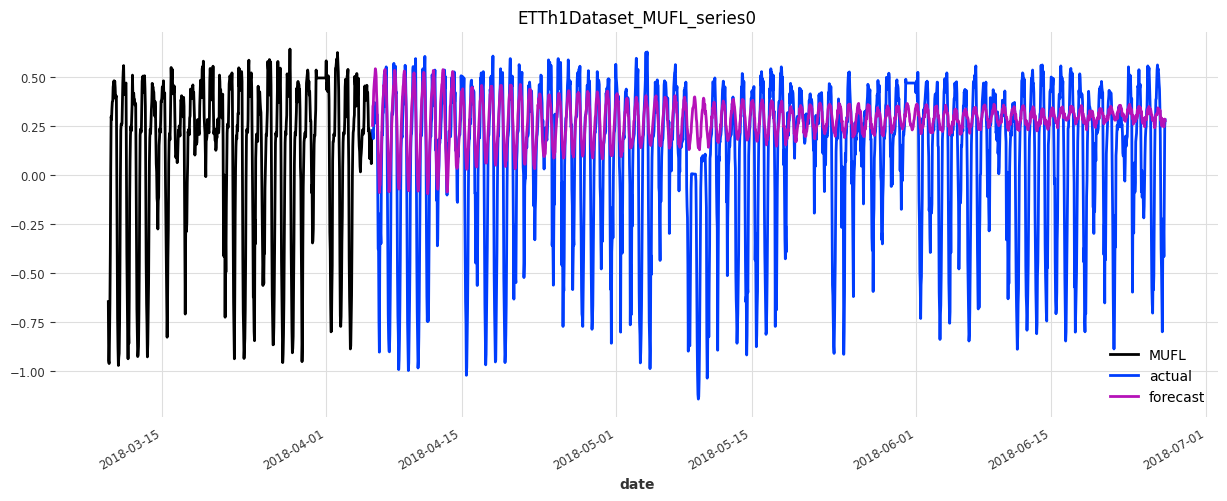

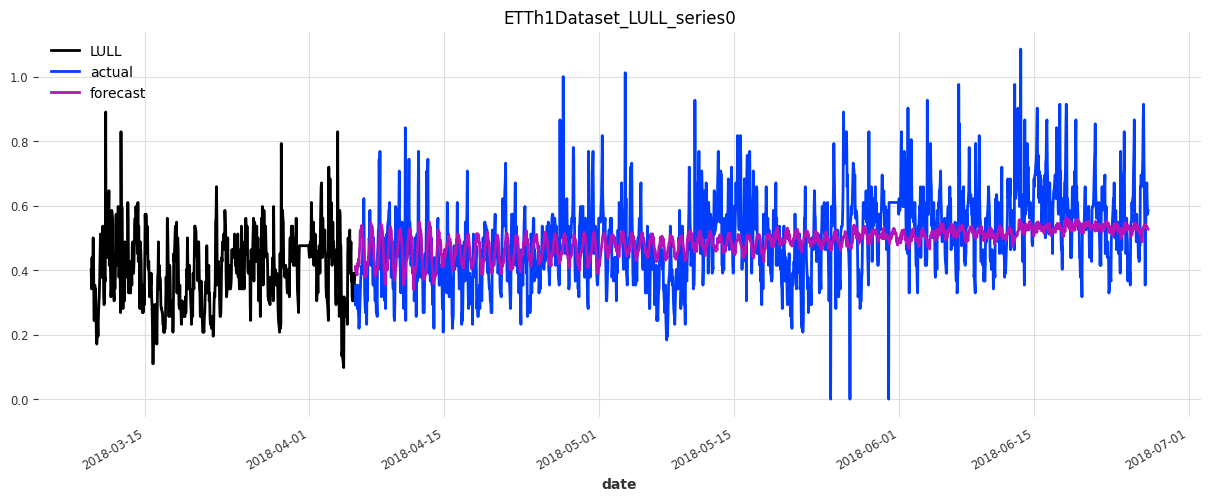

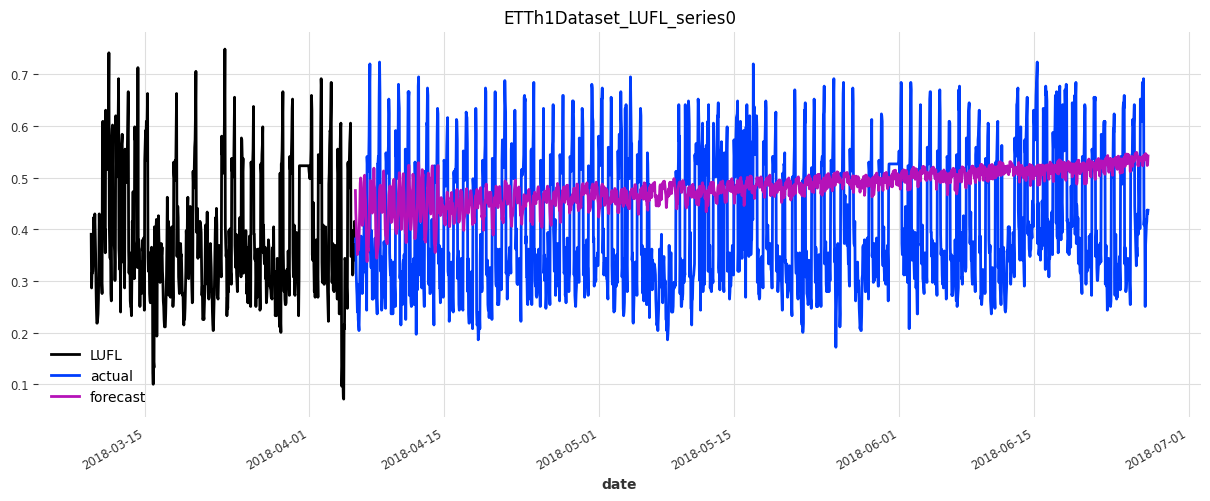

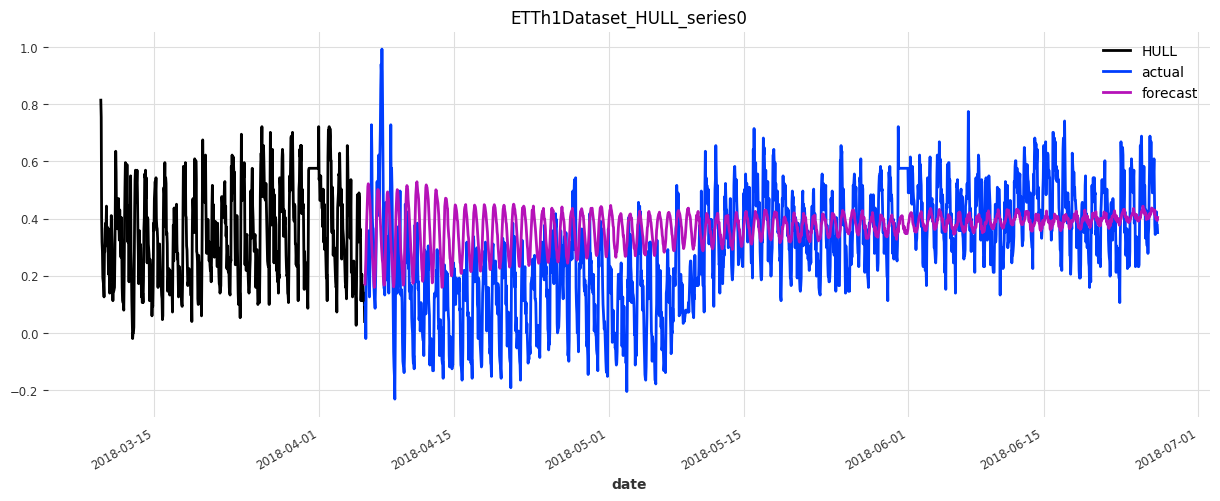

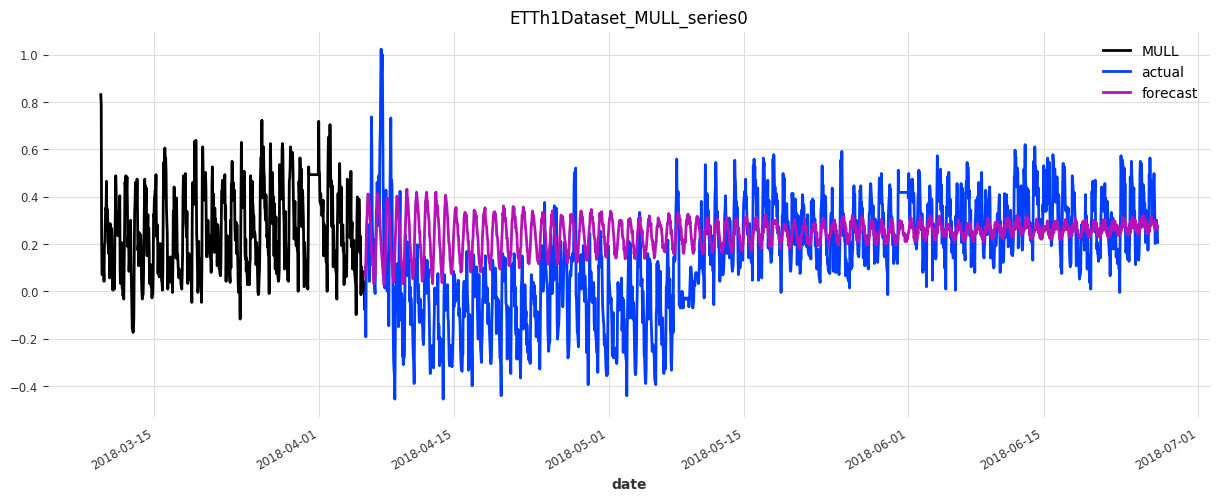

In [30]:
# pick series and components at random to plot 
max_series_to_plot = 5
max_comps_to_plot = 5


if n_components < max_comps_to_plot:
    max_comps_to_plot = n_components

comps_vec = np.random.randint(0, n_components, max_series_to_plot)
comp_names = train[0].columns.to_list()

if num_series < max_series_to_plot:
    max_series_to_plot = num_series

print("all components:", comp_names)
series_vec = np.random.randint(0, num_series, max_series_to_plot)

for idx in series_vec:
    for comp_id in comps_vec:
        comp_id = comp_names[comp_id]
        plt.figure(figsize=(15, 5))
        val[idx][comp_id][-(val_len//3):].plot()
        test[idx][comp_id].plot(label='actual')
        test_predictions[idx][comp_id].plot(label='forecast')
        plt.title(f"{dataset.__name__}_{comp_id}_series{idx}")
        plt.show()
        plt.close()